In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from matplotlib import patches as mpatches
import sys
sys.path.append('../../../src/')

import os

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import math 
from os import PathLike
from pathlib import Path
from scipy.stats import pearsonr, ttest_rel

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1}
# color_dict_label = {'Ethyl Butyrate': '#d95f02', 'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#7570b3', 
#                     '2-Heptanone' : '#1b9e77', 'Methyl Acetate': '#d95f02', 'Fenchone': '#7570b3', '2,3-Butanedione': '#e7298a'}
dict_odor = {}
rate = -0.12
offset = 0.6
dict_odor['Ethyl Butyrate'] = {'rate':rate, 'offset':offset, 'color': '#d95f02'}
dict_odor['Methyl Butyrate'] = {'rate':rate, 'offset':0.9, 'color': '#d95f02'}
dict_odor['Alpha-pinene'] = {'rate':rate, 'offset':offset, 'color': '#1b9e77'}
dict_odor['Amyl Acetate'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['Methyl Acetate'] = {'rate':rate, 'offset':offset, 'color': color1}
dict_odor['2,3-Butanedione'] = {'rate':rate, 'offset':offset, 'color': color4}
dict_odor['Fenchone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['2-Heptanone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 4 - manipulating cost of travelling and global statistics\results'


### Generating the dataset

In [2]:
date = datetime.date.today()
date_string = "9/9/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [3]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()
previous_experiment = 0
control_experiment = 0
for mouse in ['754570','754579','754567','754580','754559','754560','754577','754566','754570','754571','754572','754573','754574','754575', '754582','745302','745305','745301']:
    print(mouse)
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))

    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)

    # All this segment is to find the correct session without having the specific path
    for file_name in sorted_files:

        print(file_name)
        # Find specific session sorted by date
        session = file_name[-15:-7]
        if datetime.datetime.strptime(session, "%Y%m%d").date() < date:
            continue
        else:
            print('correct date found')
            
        # Recover data streams
        session_path = os.path.join(base_path, mouse, file_name)
        session_path = Path(session_path)
        try:
            data = parse.load_session_data(session_path)
        except:
            print('Error loading data')
              
        data['config'].streams['tasklogic_input'].load_from_file()
               
        # Parse data
        try:
            reward_sites, active_site, config = parse.parse_dataframe(data)
        except:
            print('Error parsing data')
            continue
        
        odor_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        odor_sites['perceived_reward_probability'] = reward_sites['after_choice_cumulative_rewards'] / (reward_sites['visit_number'] +1)
        
        # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['active_patch'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['active_patch'].max()
            
        odor_sites['engaged'] = odor_sites['active_patch'] <= last_engaged_patch  
        
        active_site = AddExtraColumns(odor_sites, active_site).add_time_previous_intersite_interpatch()
        active_site['duration_epoch'] = active_site.index.to_series().diff().shift(-1)
        active_site['mouse'] = mouse
        active_site['session'] = session       
        session_n+=1
        
        experiment = data['config'].streams.tasklogic_input.data['stage_name']
        if previous_experiment != experiment:
            within_session_number = 0
            previous_experiment = experiment
        else:
            within_session_number += 1

        if experiment == 'control':
            control_experiment += 1
            within_session_number = control_experiment
            
        active_site['within_session_number'] = within_session_number   
        active_site['session_number'] = session_n
        active_site['experiment'] = data['config'].streams.tasklogic_input.data['stage_name']

        summary_df = pd.concat([summary_df, active_site])

754570
754570_20240823T104815
754570_20240903T122712
754570_20240904T114053
754570_20240905T112958
754570_20240906T105852
754570_20240911T131919
correct date found
754570_20240912T110112
correct date found
754570_20240913T111333
correct date found
754570_20240916T111512
correct date found
754570_20240917T110655
correct date found
754570_20240918T113619
correct date found
754570_20240919T110023
correct date found
754570_20240920T104959
correct date found
754570_20240923T104700
correct date found
754570_20240924T110456
correct date found
754570_20240925T110635
correct date found
754570_20240926T105051
correct date found
754570_20240927T104722
correct date found
754570_20240930T104239
correct date found
754570_20241001T104318
correct date found
754570_20241002T111428
correct date found
754570_20241003T111937
correct date found
754570_20241004T110425
correct date found
754570_20241007T111914
correct date found
754570_20241008T110907
correct date found
754570_20241009T111732
correct date fo

In [4]:
summary_df.to_csv(os.path.join(data_path, 'batch_4.csv'))

# Results

### Retrieving the data

In [6]:
print('Loading')
summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'))
summary_df['perceived_reward_probability'] = summary_df['cumulative_rewards'] / (summary_df['visit_number'] +1)
summary_df = summary_df[(summary_df['experiment'] == 'data_collection')|(summary_df['experiment'] == 'friction')|(summary_df['experiment'] == 'control')]

Loading


In [7]:
summary_df = summary_df[(summary_df['mouse'] != 754573)&(summary_df['mouse'] != 754572)]
summary_df = summary_df[summary_df['engaged'] == True]

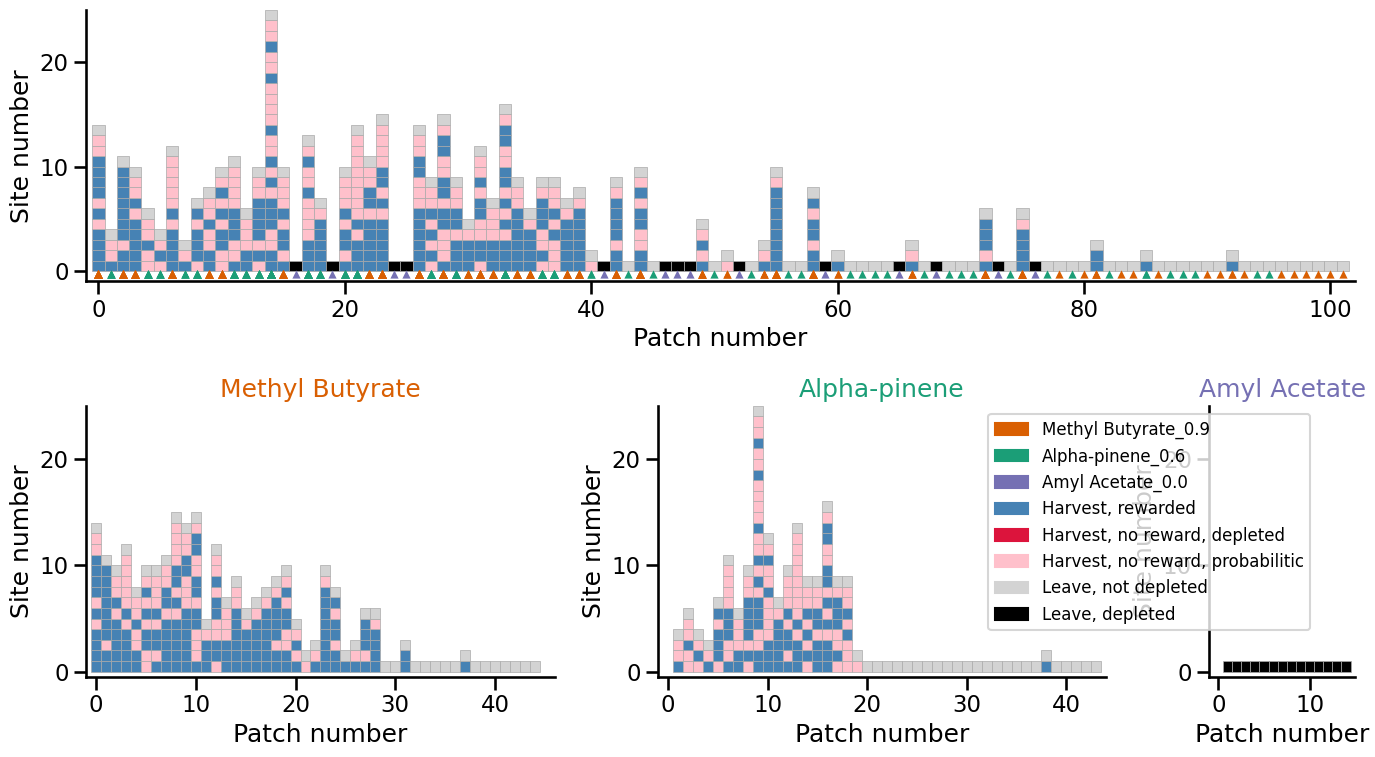

In [8]:
onesession = summary_df[(summary_df['session'] == 20241022) & (summary_df['mouse'] == 754580)]
plotting.segmented_raster_vertical(onesession.loc[onesession.label == 'RewardSite'], 'test', color_dict_label=color_dict_label)

### **During session  p(reward) leave values**

**Within session estimation of p(reward)**

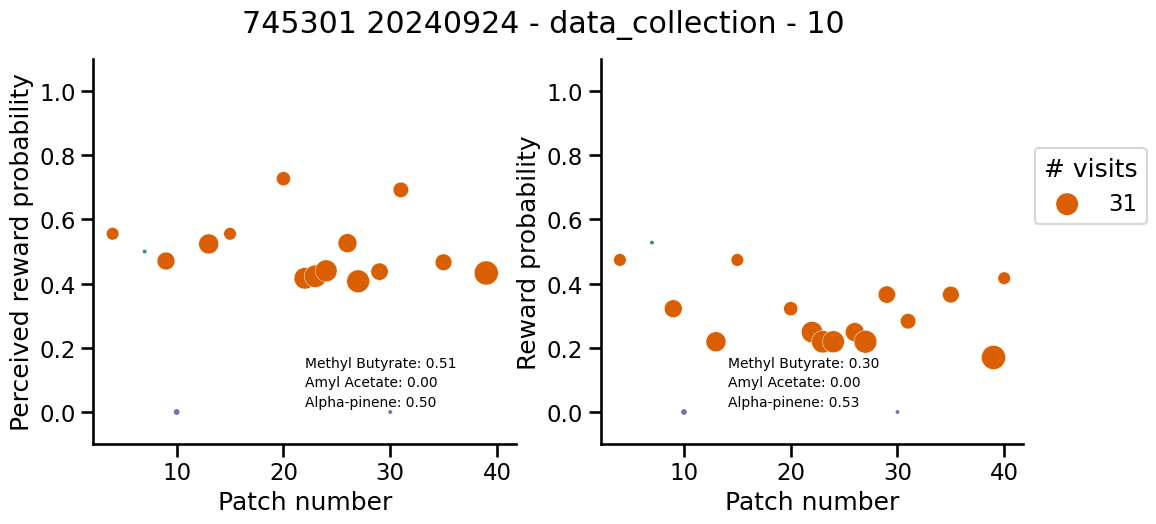

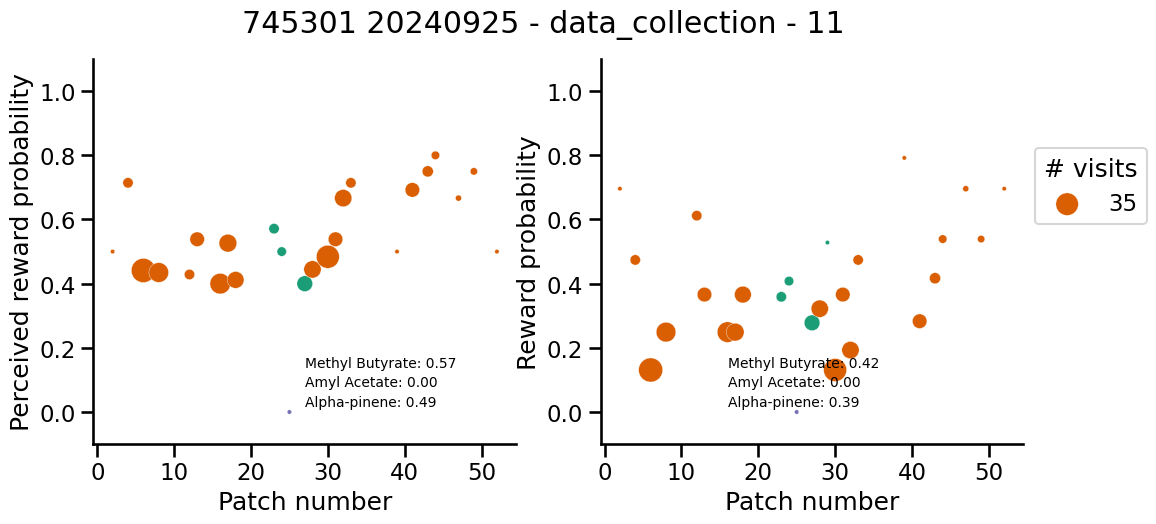

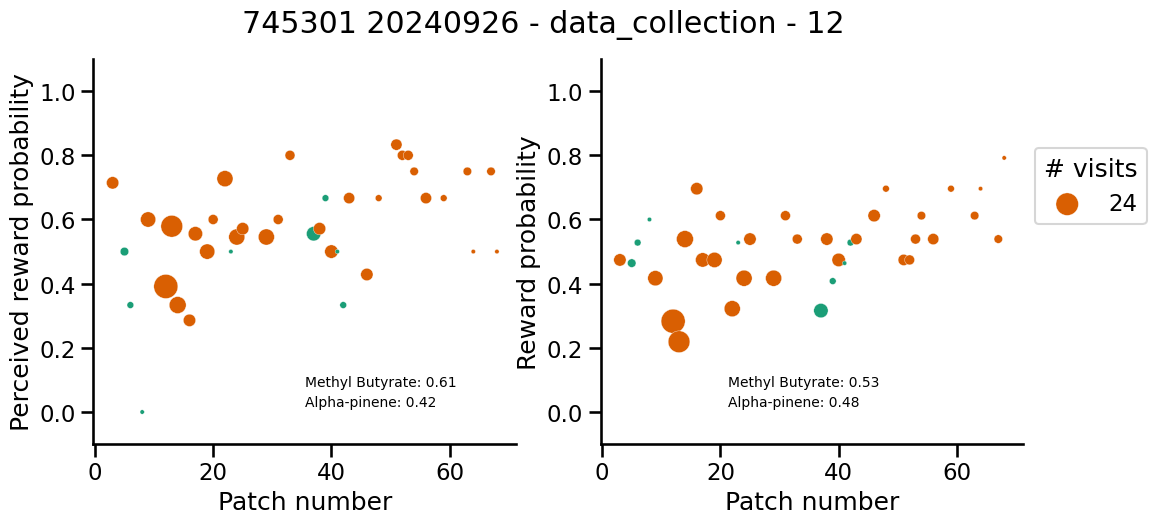

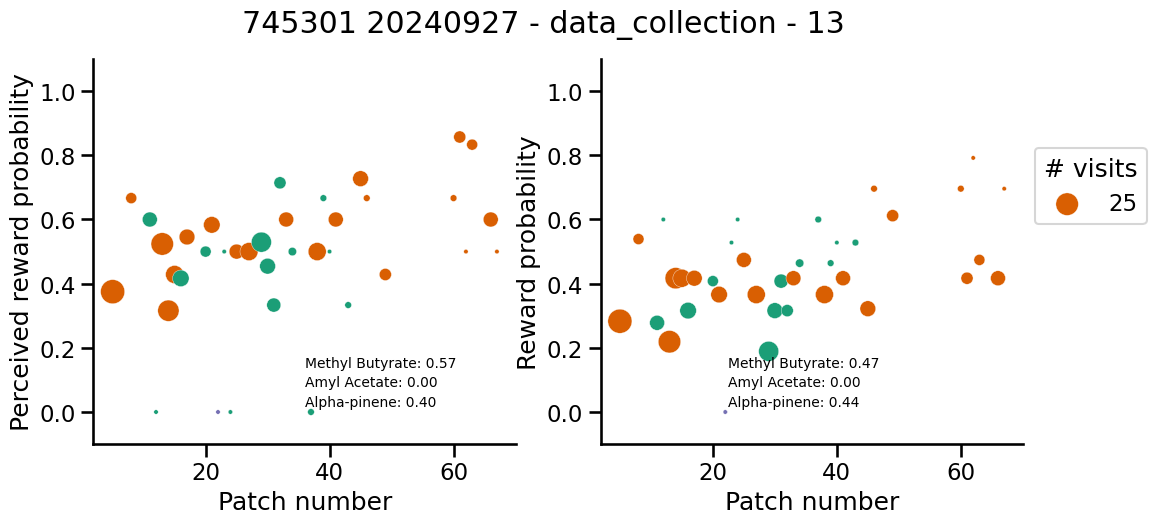

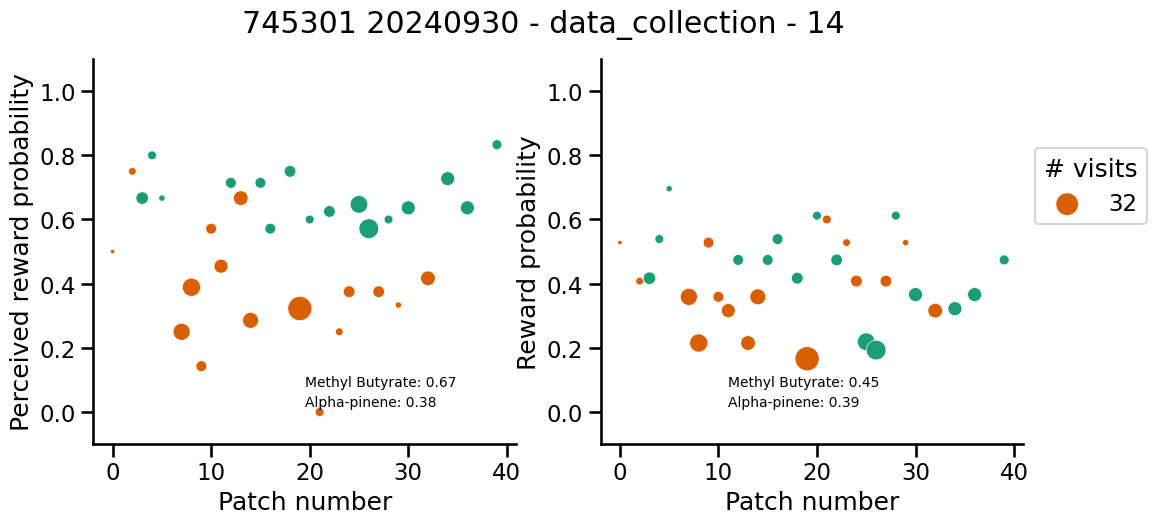

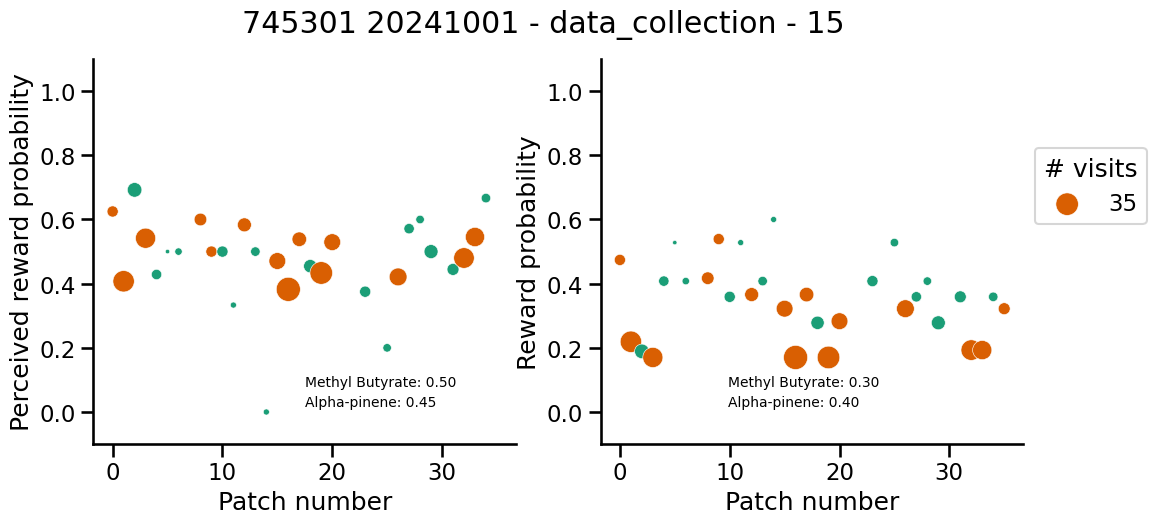

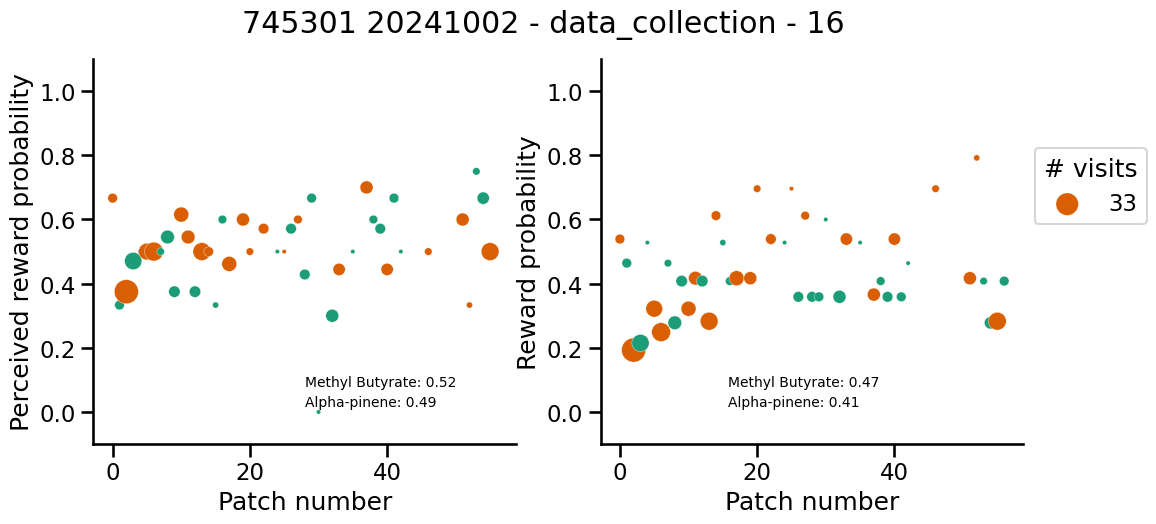

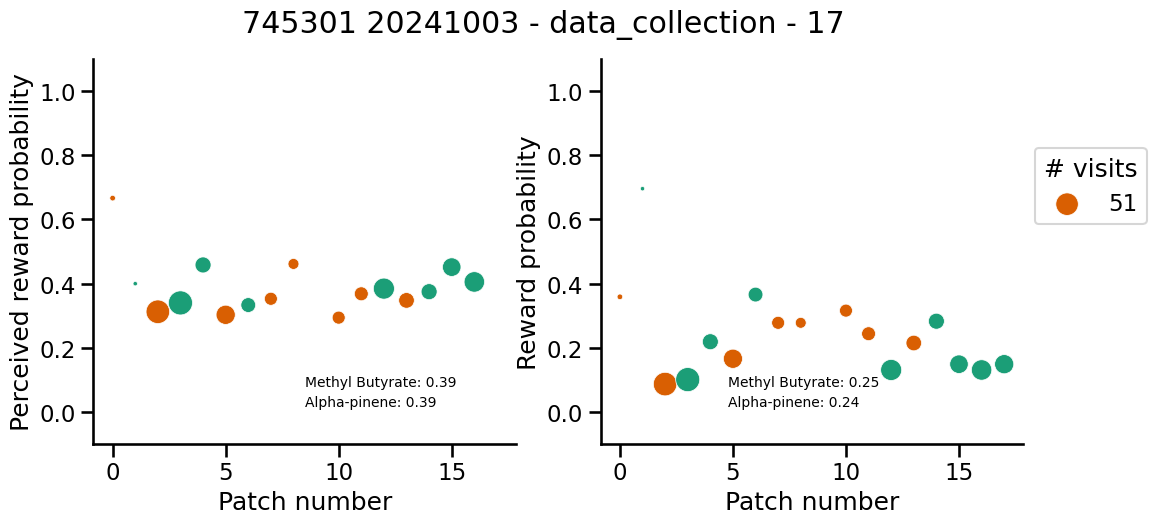

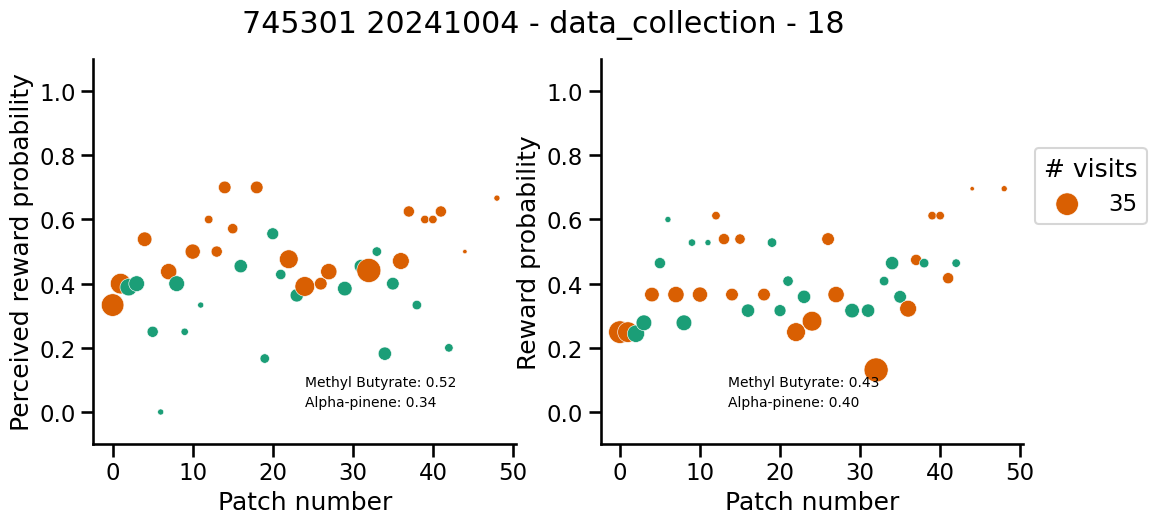

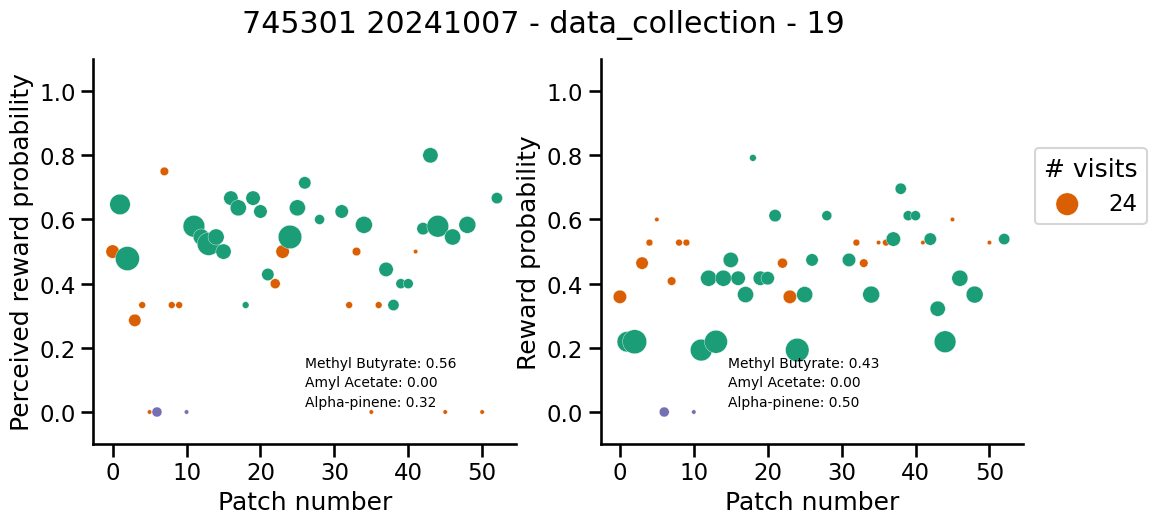

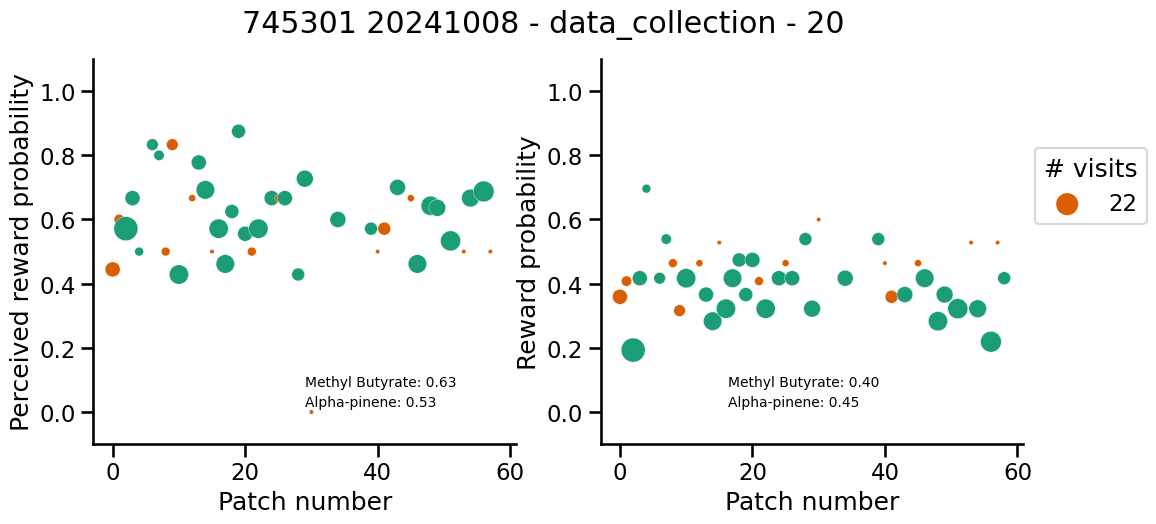

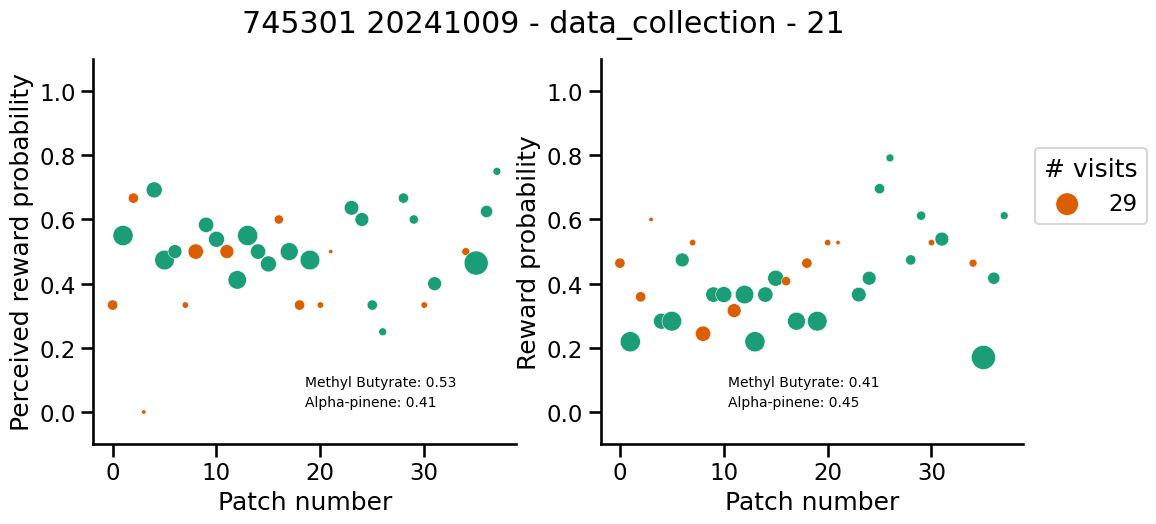

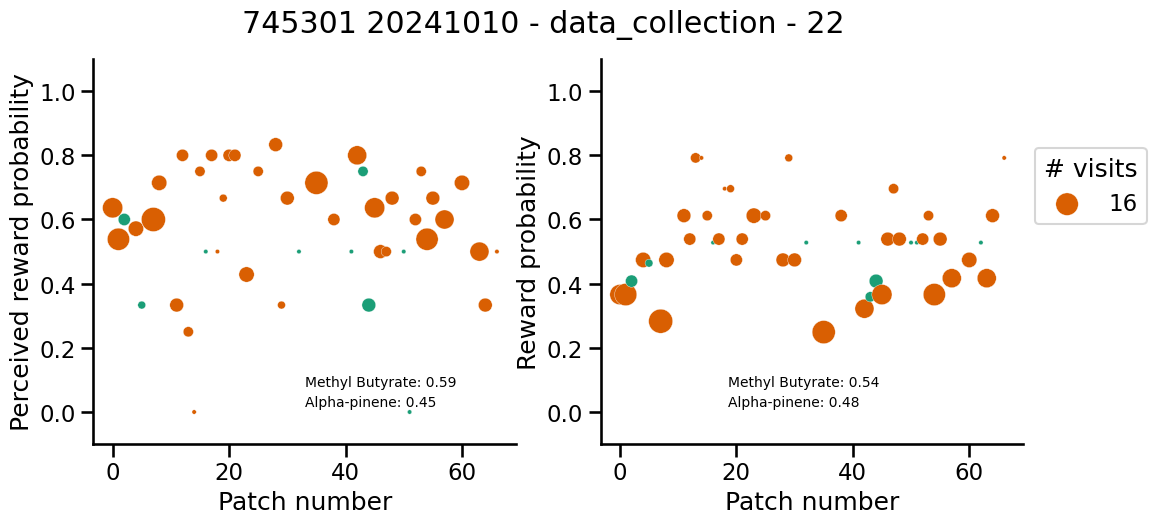

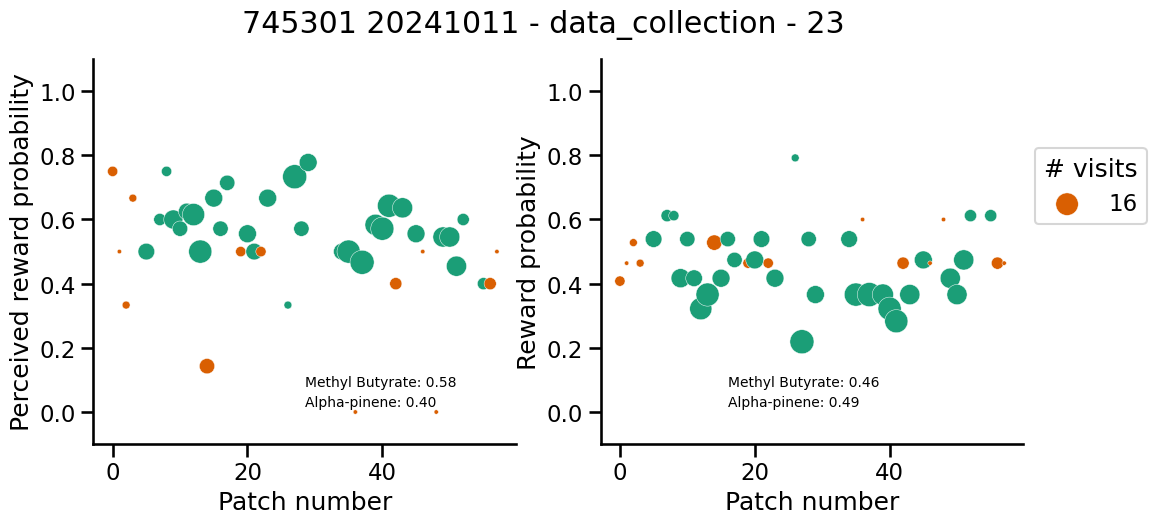

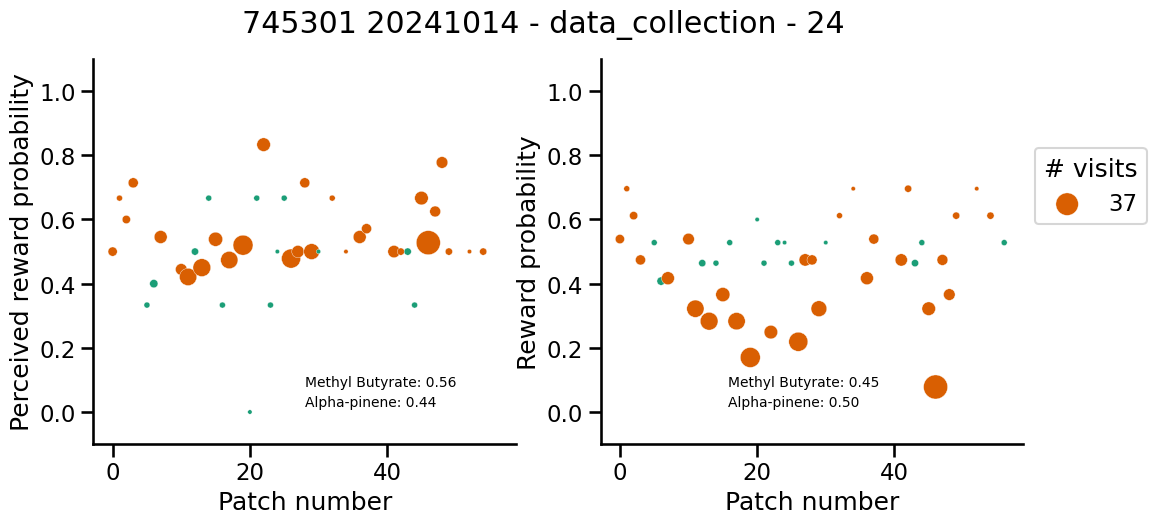

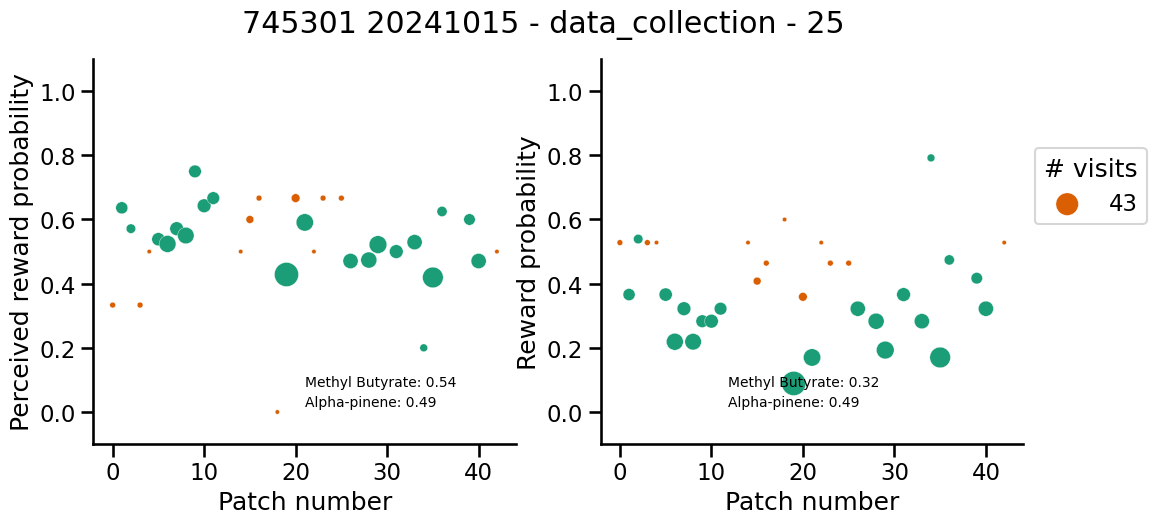

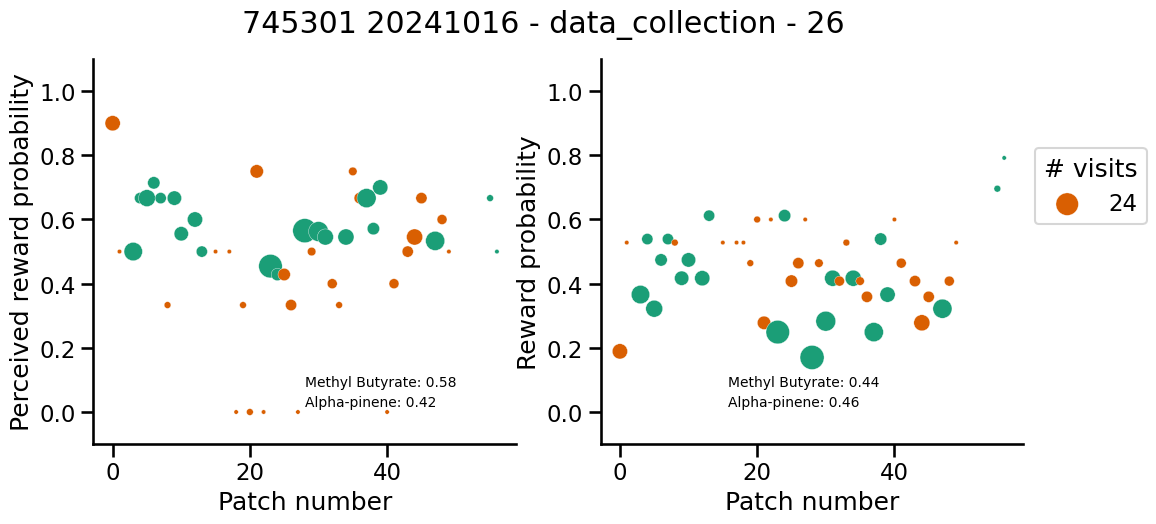

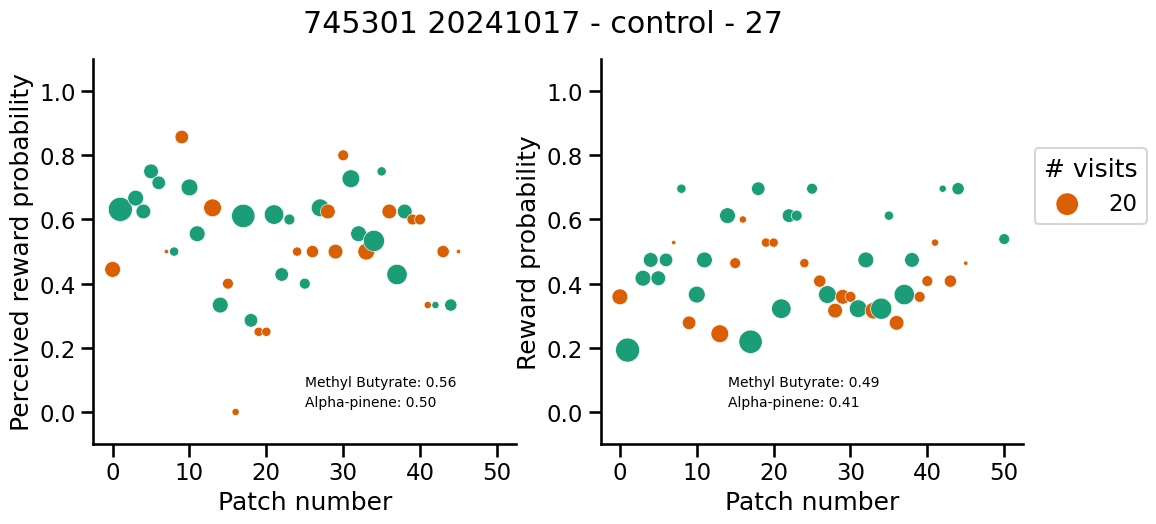

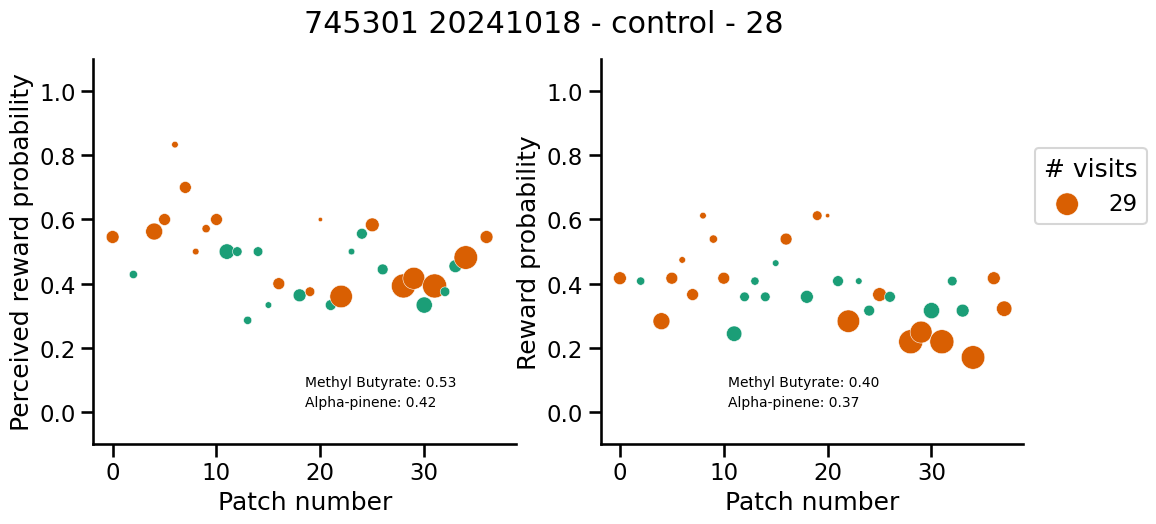

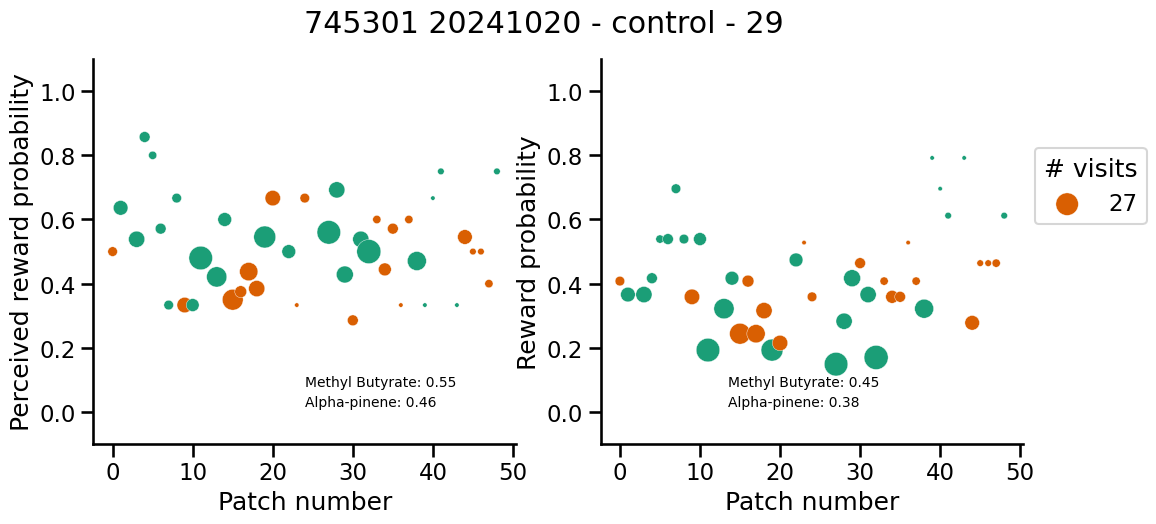

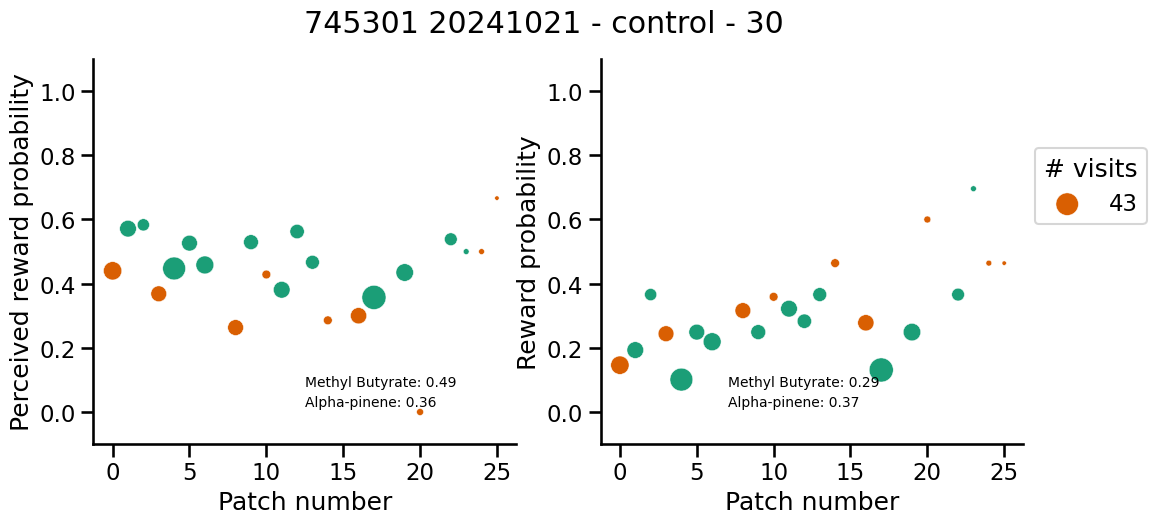

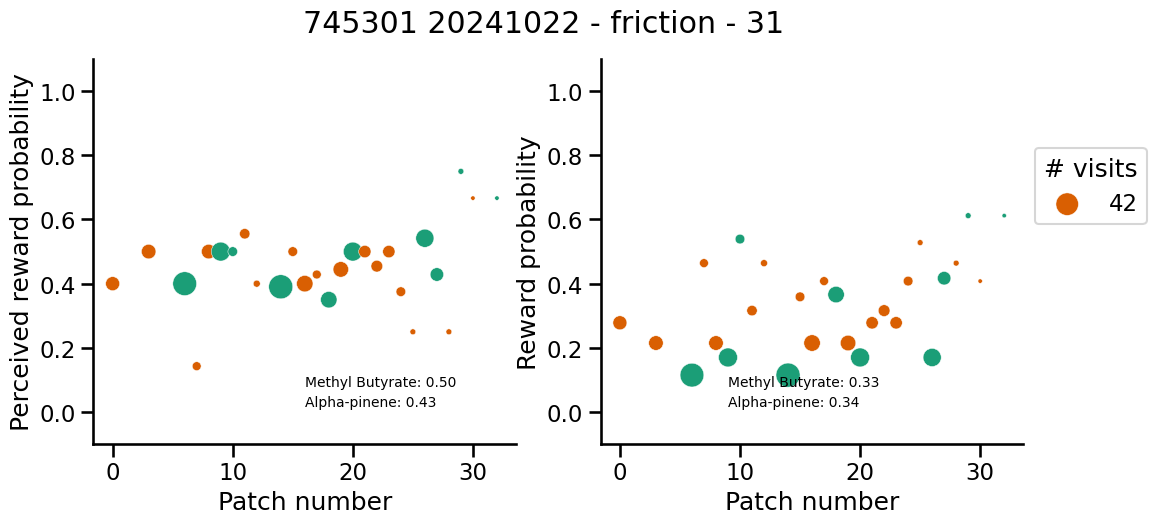

KeyboardInterrupt: 

In [9]:
for mouse_df in summary_df.groupby(['mouse']):
    mouse = mouse_df[1].mouse.unique()[0]
    for session_df in mouse_df[1].groupby(['session']):
        session = session_df[1].session.unique()[0]
        session_df = session_df[1]
        
        fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)

        df = session_df.loc[(session_df.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        df['visit_number'] = session_df.loc[(session_df.has_choice == True)].groupby(['active_patch', 'odor_label']).agg({'visit_number':'count'})['visit_number'].values[:len(df)]
        df = df.loc[df['visit_number']>1]
        if df.empty:
            continue
        
        sns.scatterplot(x='active_patch', y='perceived_reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[0], legend=False)
        ax[0].set_ylabel('Perceived reward probability')
        ax[0].set_xlabel('Patch number')
        ax[0].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(0.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.perceived_reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05

        # Same for the perceived reward probability
        df = session_df.loc[(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min', 'visit_number':'count'}).reset_index()
        df['visit_number'] += 1
        df = df.loc[df['visit_number']>2]

        sns.scatterplot(x='active_patch', y='reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[1])
        ax[1].set_ylabel('Reward probability')
        ax[1].set_xlabel('Patch number')
        ax[1].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(1.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05
        
        plt.legend(bbox_to_anchor=(1.0,0.8), loc='upper left', labels=[max(df.visit_number)], markerscale=1.3, title='# visits')
        plt.suptitle(f'{mouse} {session} - {session_df.experiment.unique()[0]} - {session_df.session_number.unique()[0]}')
        sns.despine()
        plt.show()


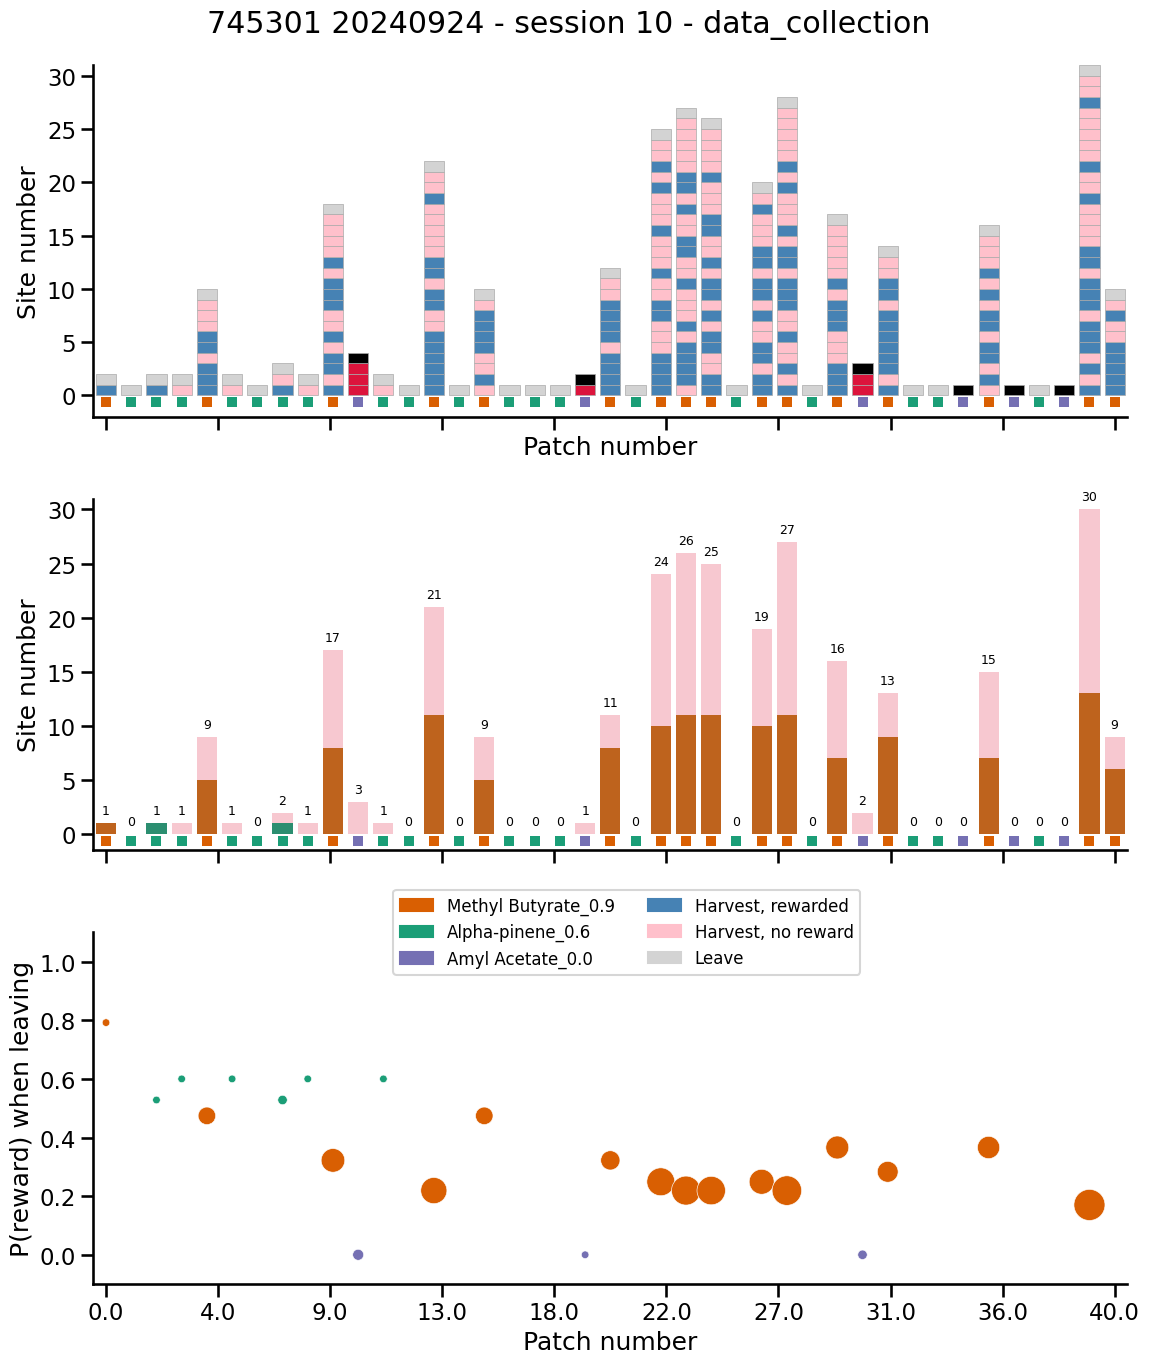

KeyboardInterrupt: 

In [10]:
with PdfPages(os.path.join(results_path, 'across_sessions_parameters_batch4.pdf')) as pdf:
    for mouse_df in summary_df.groupby(['mouse']):
        mouse = mouse_df[1].mouse.unique()[0]
        for session_df in mouse_df[1].groupby(['session']):
            session = session_df[1].session.unique()[0]
            session_df = session_df[1]
            fig, ax = plt.subplots(3,1,figsize=(12,14), sharex=True)

            reward_sites = summary_df.loc[(summary_df['session'] == session)&(summary_df['mouse'] == mouse)&(summary_df['label'] == 'RewardSite')]

            patch_number = len(reward_sites.active_patch.unique())
            number_odors = len(reward_sites['odor_label'].unique())

            list_odors = []
            for odor in reward_sites.odor_label.unique():
                list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
            grid = (np.array(list_odors)/patch_number)*number_odors

            for index, row in reward_sites.iterrows():
                if row['reward_delivered'] == 1 and row['has_choice'] == True:
                    color='steelblue'
                elif row['reward_delivered'] == 0 and row['has_choice'] == True:
                    color='pink'
                    if row['reward_available'] == 0:
                        color='crimson'
                else:
                    if  row['reward_available'] == 0:
                        color='black'
                        hatch = '/'
                    else:
                        color='lightgrey'
                    
                ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
                ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
                ax[0].set_xlim(-1,50)
                ax[0].set_xlabel('Patch number')
                ax[0].set_ylabel('Site number')
                
                # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
                ax[0].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)
                ax[1].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)

            odors = []
            for index, odor in enumerate(reward_sites['odor_label'].unique()):
                odors.append(mpatches.Patch(color=color_dict_label[odor], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

            label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
            label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
            label_4 = mpatches.Patch(color='lightgrey', label='Leave')

            odors.extend([label_2, label_3,label_4])
            plt.legend(handles=odors, loc='right', bbox_to_anchor=(0.75, 1), fontsize=12, ncol=2)
            ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

            summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
            summary.reset_index(inplace=True)

            sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None, legend=False)
            for p in ax[1].patches:
                ax[1].annotate(f'{int(p.get_height())}',  # The count
                            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                            ha='center', va='center', 
                            xytext=(0, 9), fontsize=9,  # 9 points vertical offset
                            textcoords='offset points')
            sns.barplot(x='active_patch', y='reward_delivered', hue='odor_label', palette= color_dict_label, data=summary, legend=False, ax=ax[1], errorbar=None)

            # Specifying the number of xticks
            num_ticks = 10  # Change this to the desired number of ticks
            xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

            # Specifying the xticks
            ax[1].set_xticks(xticks)
            # ax[1].set_xlim(-1,125)
            ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
            ax[1].set_ylabel('Site number')

            df = session_df.loc[(session_df.last_site == 1)&(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min','visit_number':'mean'}).reset_index()
            # sns.scatterplot(x='active_patch', y='reward_probability', color='b', s=50, marker='o',  zorder=10, hue='odor_label', palette=color_dict_label, data = df, ax = ax[2], legend=False)
            # sns.lineplot(x='active_patch', y='reward_probability', marker='',color='grey', alpha=0.5, data = df, ax = ax[2], legend=False)
            
            sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax[2], legend=False)
            
            ax[2].set_xlabel('Patch number')
            ax[2].set_ylabel('P(reward) when leaving')            
            ax[2].set_ylim(-0.1,1.1)
            
            plt.suptitle(f'{mouse} {session} - session {session_df.session_number.unique()[0]} - {session_df.experiment.unique()[0]}')
            sns.despine()
            plt.tight_layout()
            plt.show()
            pdf.savefig(fig)


## **General overview of main behavioral parameters**

In [11]:
experiment='friction'

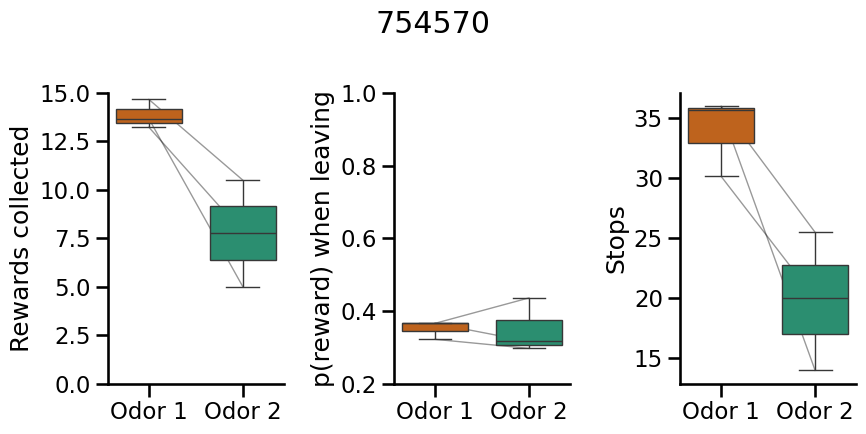

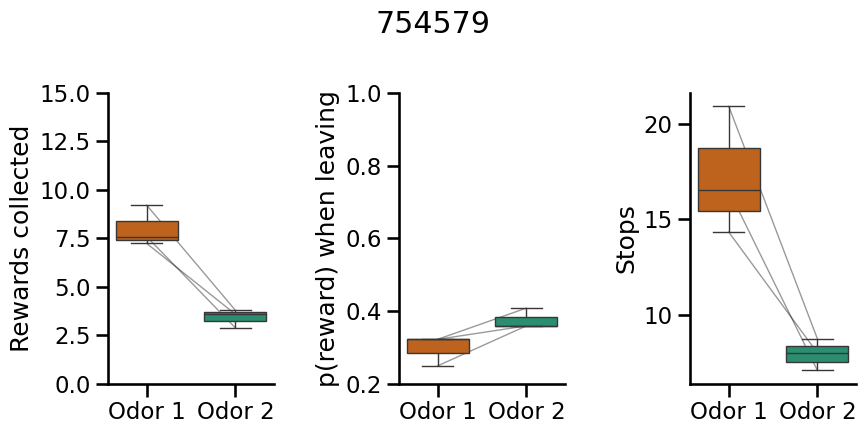

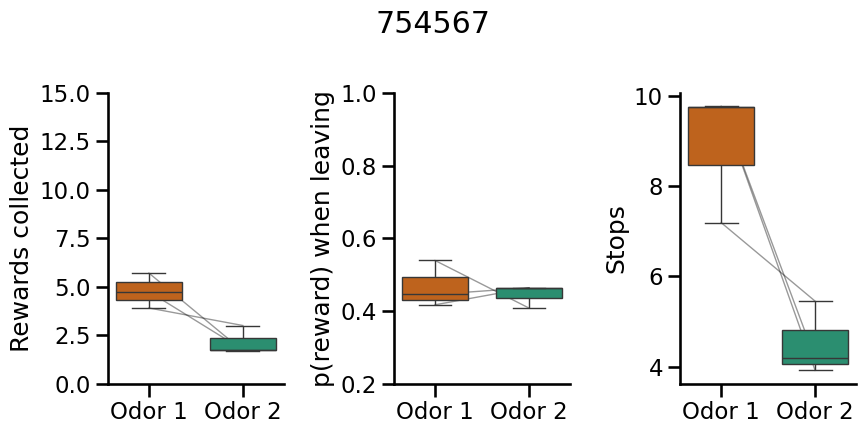

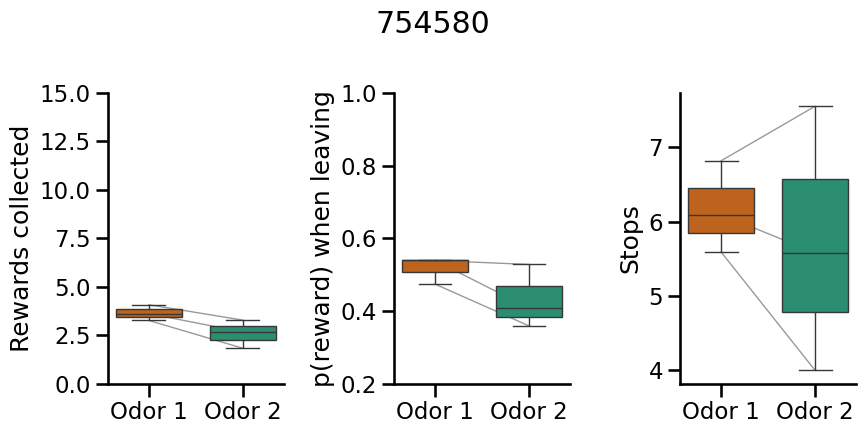

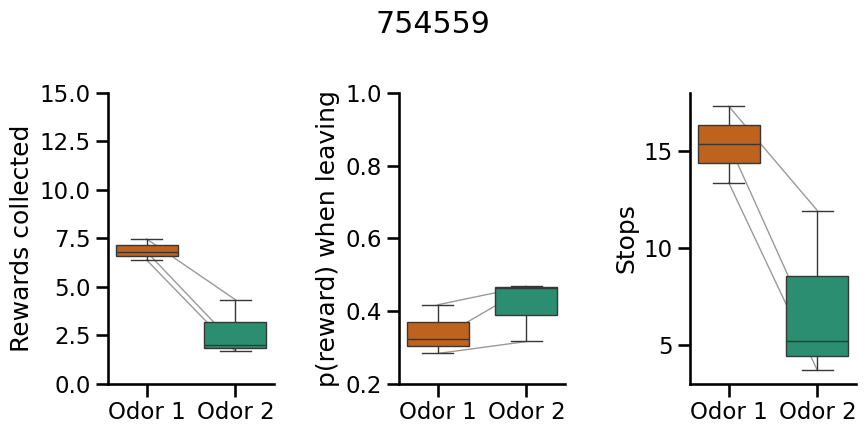

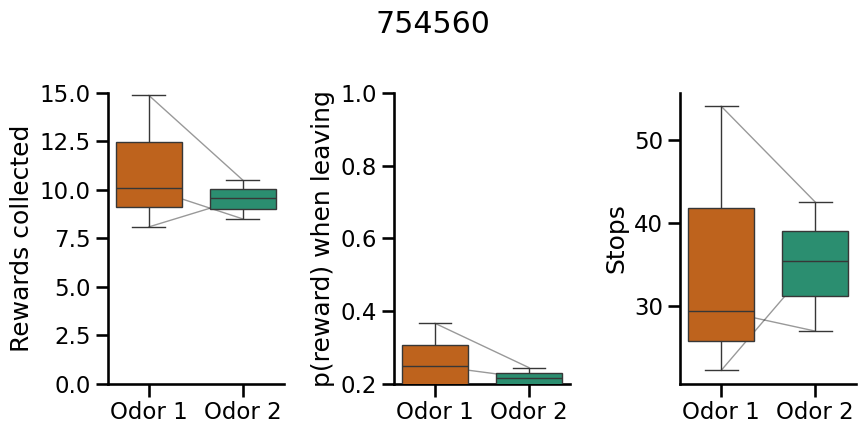

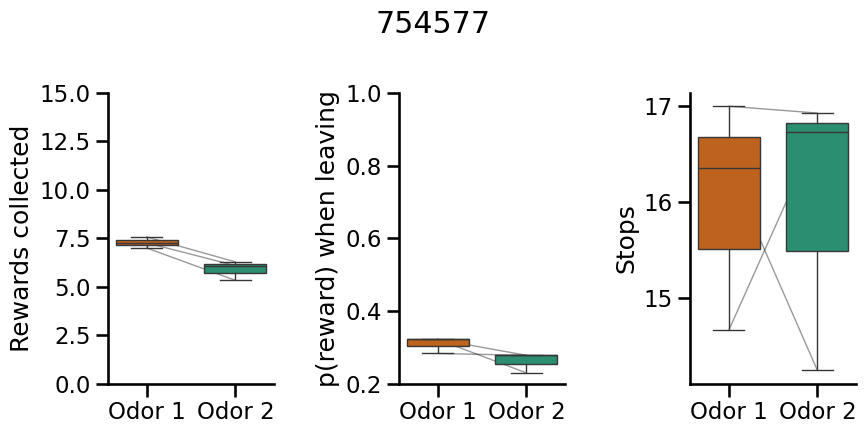

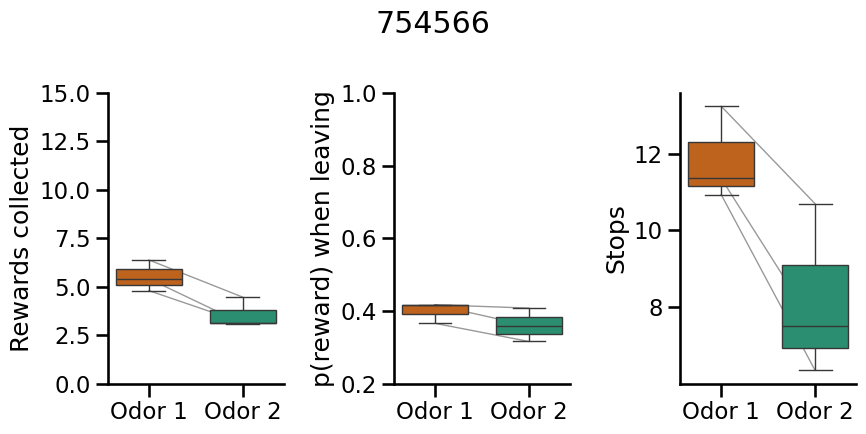

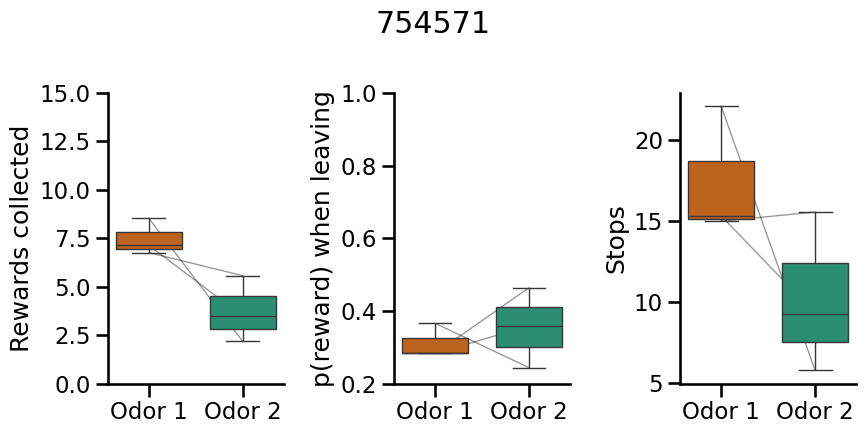

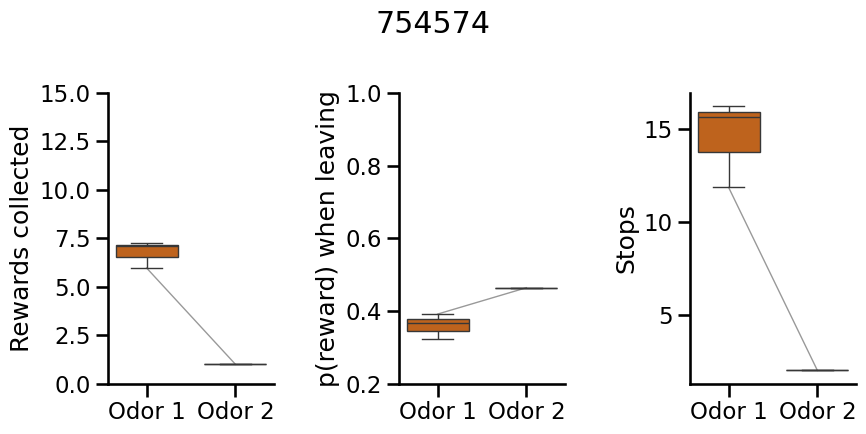

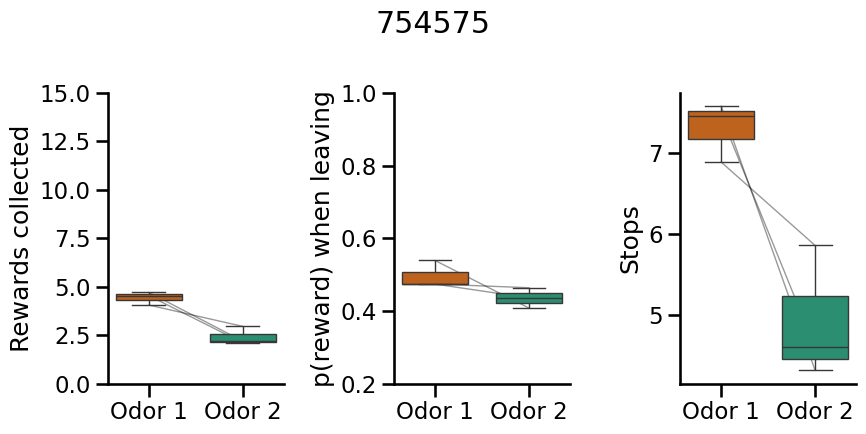

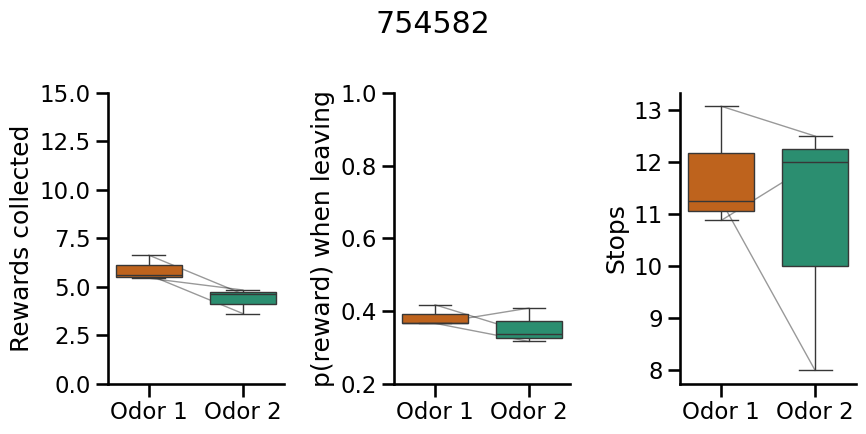

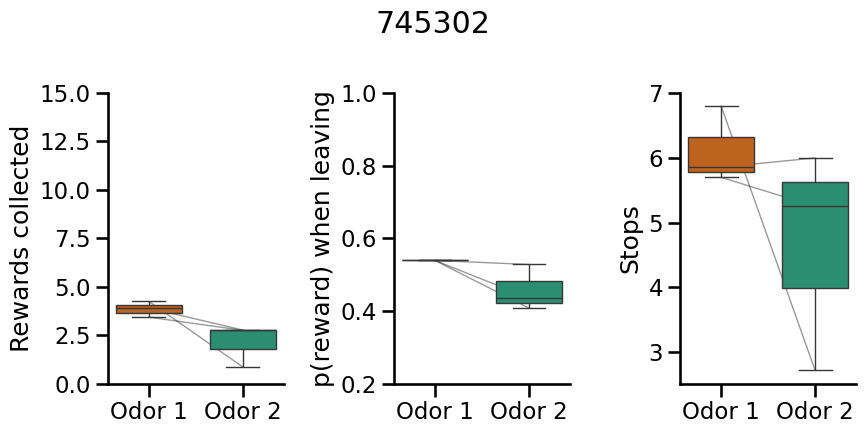

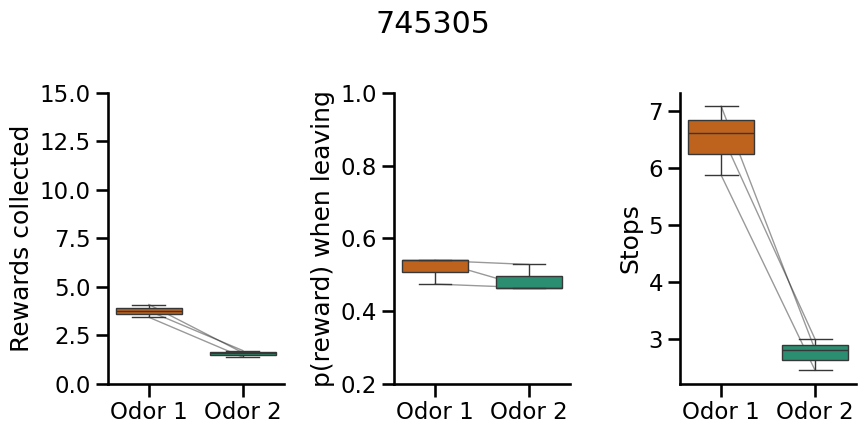

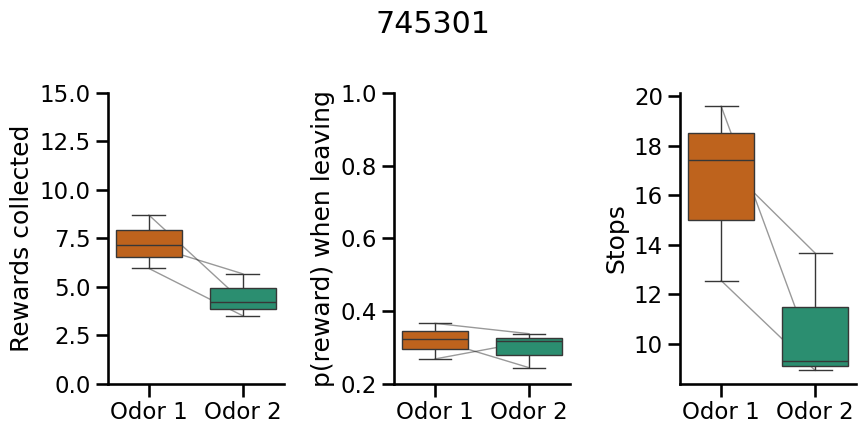

In [14]:
for mouse in summary_df.mouse.unique():    
    fig,ax = plt.subplots(1,3, figsize=(9,4.5))

    summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(groups).agg({'reward_delivered':'sum','visit_number':'count'}).reset_index()
    summary = summary.loc[summary.mouse == mouse]
    summary = summary.groupby(['session','odor_label','experiment']).agg({'reward_delivered':'mean','visit_number':'mean'})
    summary.reset_index(inplace=True)
    summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

    axes = ax[0]
    sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

    for session in summary.session.unique():
        y = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].reward_delivered.values
        x = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].odor_label.values
        axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    axes.set_ylabel('Rewards collected')
    axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
    axes.set_xlabel('')
    axes.set_ylim(0,15)

    summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
    summary = summary.loc[(summary.visit_number > 1)]
    summary = summary.loc[summary.mouse == mouse]

    summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'collected':'mean','reward_probability':'median', 'active_patch': 'nunique'}).reset_index()
    summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

    axes = ax[1]
    sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

    for session in summary.session.unique():
        y = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].reward_probability.values
        x = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].odor_label.values
        axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    axes.set_ylabel('p(reward) when leaving')
    axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
    axes.set_xlabel('')
    axes.set_ylim(0.2,1)

    # Stops --------------------------------
    summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment']).agg({'reward_delivered':'sum','visit_number':'count'})

    summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'visit_number':'mean'})
    summary.reset_index(inplace=True)
    summary = summary.loc[summary.mouse == mouse]
    summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

    axes = ax[2]
    sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes, fliersize=0)

    for session in summary.session.unique():
        y = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].visit_number.values
        x = summary.loc[(summary.session == session)&(summary['experiment']==experiment)].odor_label.values
        axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

    axes.set_ylabel('Stops')
    axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
    axes.set_xlabel('')
    # axes.set_ylim(0,8)

    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
    sns.despine()
    plt.suptitle(mouse)
    plt.tight_layout()
    # plt.savefig(results_path+f'/{mouse}_summary_general_results.svg', dpi=300, bbox_inches='tight')


**Across mice**

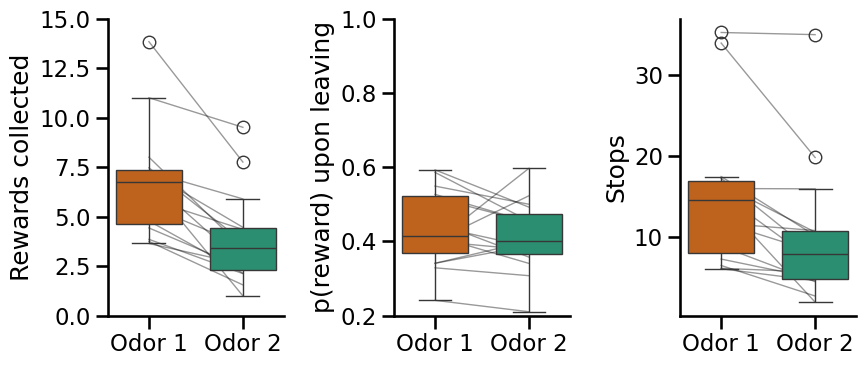

In [15]:
fig,ax = plt.subplots(1,3, figsize=(9,4))

summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', ]).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment'])['reward_delivered'].mean().reset_index()

axes = ax[0]
sns.boxplot(x='odor_label', y='reward_delivered', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].reward_delivered.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Rewards collected')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
axes.set_ylim(0,15)

summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'collected':'mean','reward_probability':'mean', 
                                                                              'active_patch': 'nunique', 'visit_number':'max'}).reset_index()
summary = summary.loc[summary.visit_number >= 1]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment'])['reward_probability'].mean().reset_index()

axes = ax[1]
sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].reward_probability.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('p(reward) upon leaving')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
# axes.set_yticks([0.0, 0.25, 0.5, 0.75,1])
axes.set_xlabel('')
axes.set_ylim(0.2,1)

# Stops --------------------------------
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment']).agg({'visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]
summary = summary.groupby(['mouse','odor_label' , 'experiment'])['visit_number'].mean().reset_index()

axes = ax[2]
sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, data=summary.loc[summary['experiment']==experiment], order=['Methyl Butyrate', 'Alpha-pinene'],legend=False, zorder=10, width =0.7, ax=axes)

for mouse in summary.mouse.unique():
    y = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].visit_number.values
    x = summary.loc[(summary.mouse == mouse)&(summary['experiment']==experiment)].odor_label.values
    axes.plot(x, y, marker='', linestyle='-', color='black', alpha=0.4, linewidth=1)

axes.set_ylabel('Stops')
axes.set_xticks([0,1], ['Odor 1', 'Odor 2'])
axes.set_xlabel('')
# axes.set_ylim(0,8)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
sns.despine()

plt.tight_layout()
plt.savefig(results_path+f'/rewards_collected_all_tall.svg', dpi=300, bbox_inches='tight')


## **Time spent in the interpatch**

In [16]:
print('Loading')
summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'))
summary_df = summary_df[(summary_df['experiment'] == 'data_collection')|(summary_df['experiment'] == 'friction')|(summary_df['experiment'] == 'control')]

Loading


In [17]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 1)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment'])['reward_probability'].mean().reset_index()
summary = summary.loc[summary.experiment == experiment]
summary = summary.groupby('mouse').agg({'reward_probability':'mean'}).reset_index()

In [18]:
summary_df['next_site'] = summary_df['Seconds'].shift(-1)
summary_df['time_spent'] =  summary_df['next_site'] - summary_df.Seconds
test_df = summary_df.copy()
test_df.set_index('Seconds', inplace=True)
test_df = test_df.loc[test_df['label'] == 'InterPatch']
summary['time_spent'] = test_df.loc[test_df.experiment == experiment].groupby(['mouse']).time_spent.median().reset_index()['time_spent']

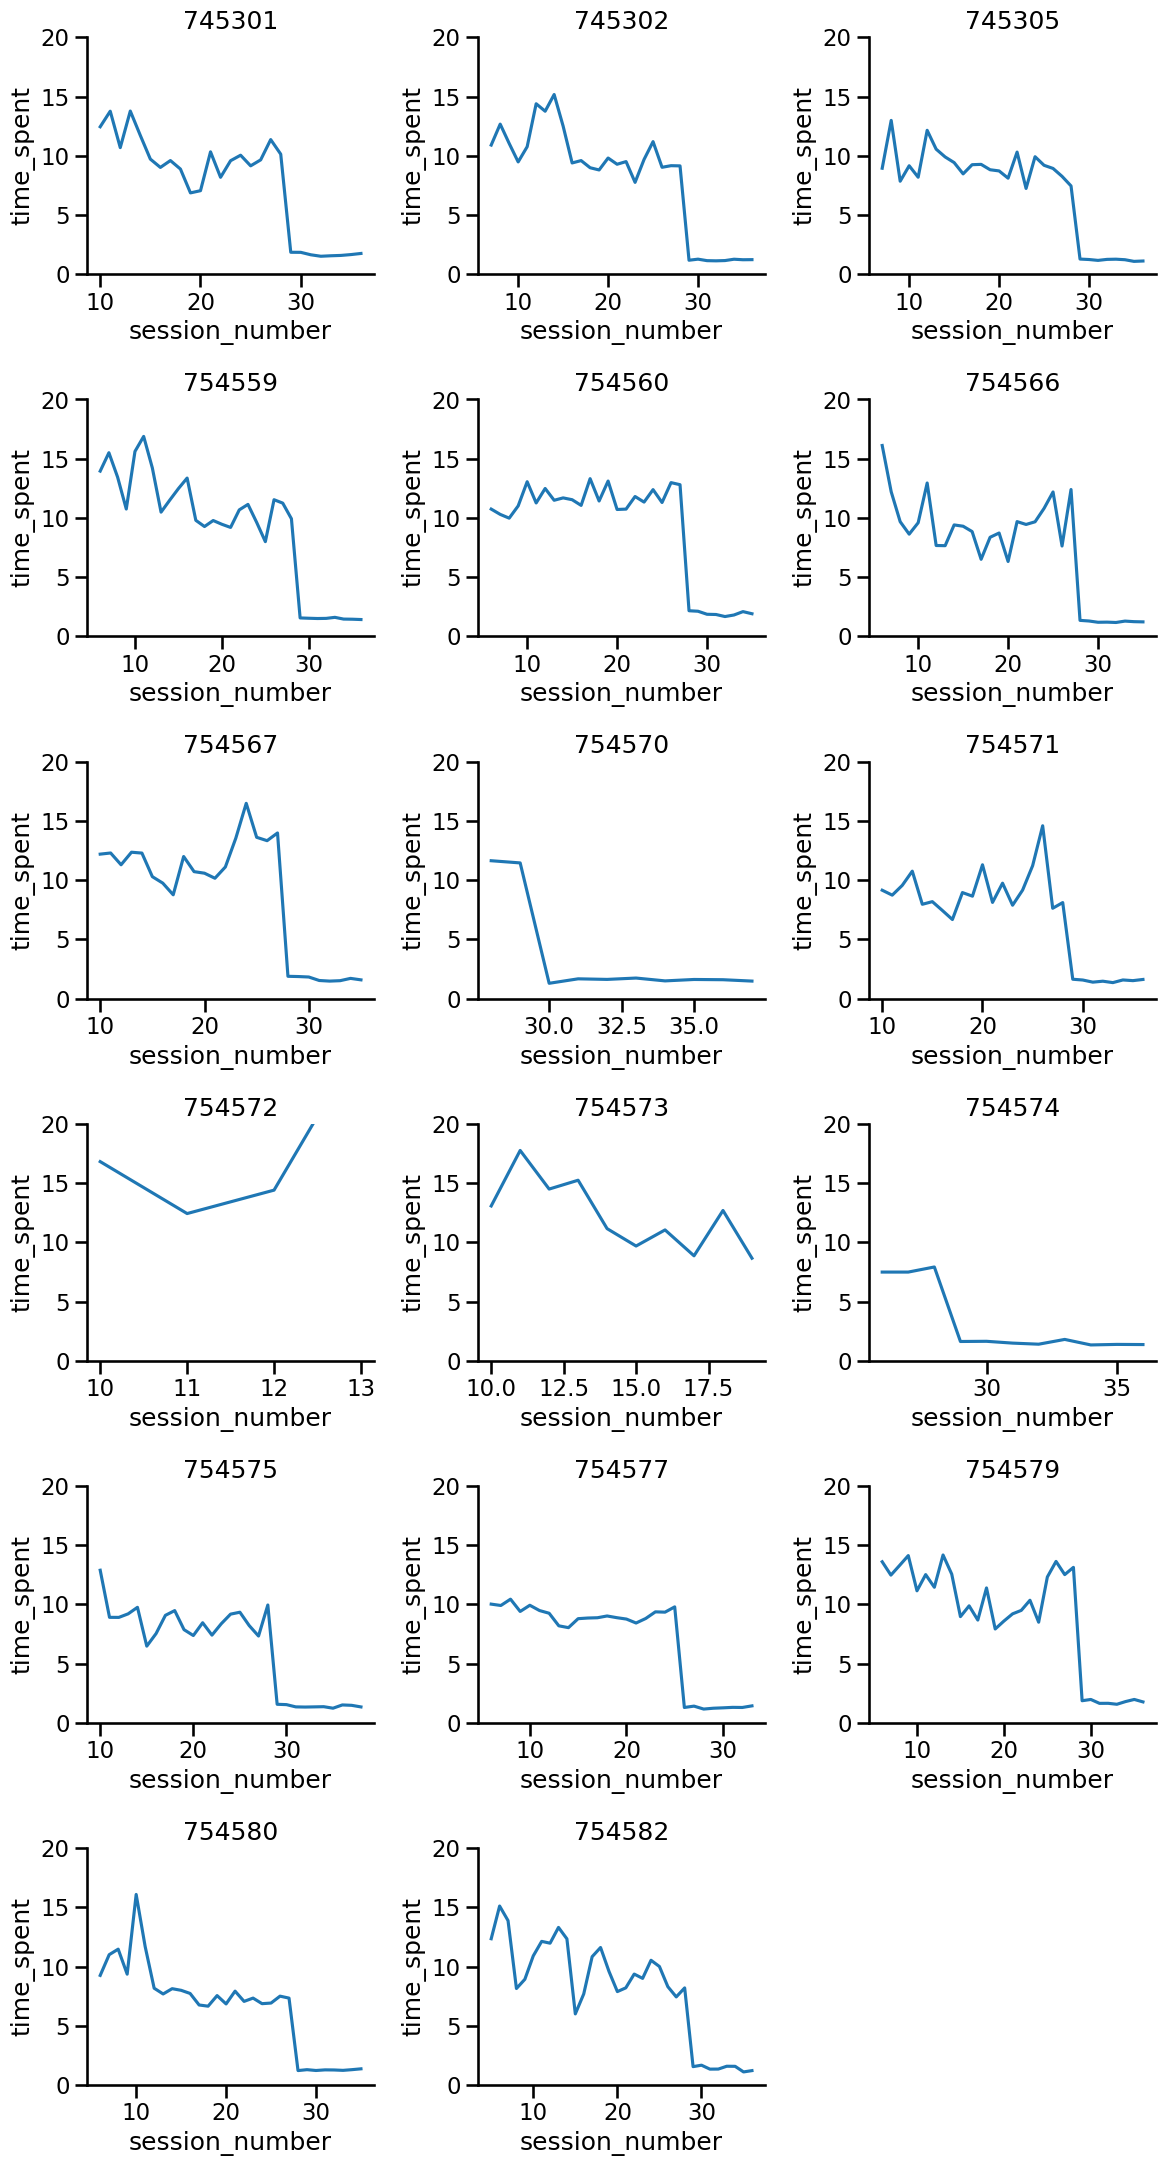

In [19]:
df = test_df.groupby(['mouse','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 3, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_number', y='time_spent', markers=True)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,20)
plt.tight_layout()
plt.show()

Correlation coefficient (pandas): -0.5392606467738472
Correlation coefficient (scipy): -0.5392606467738471
P-value: 0.038032343241406356


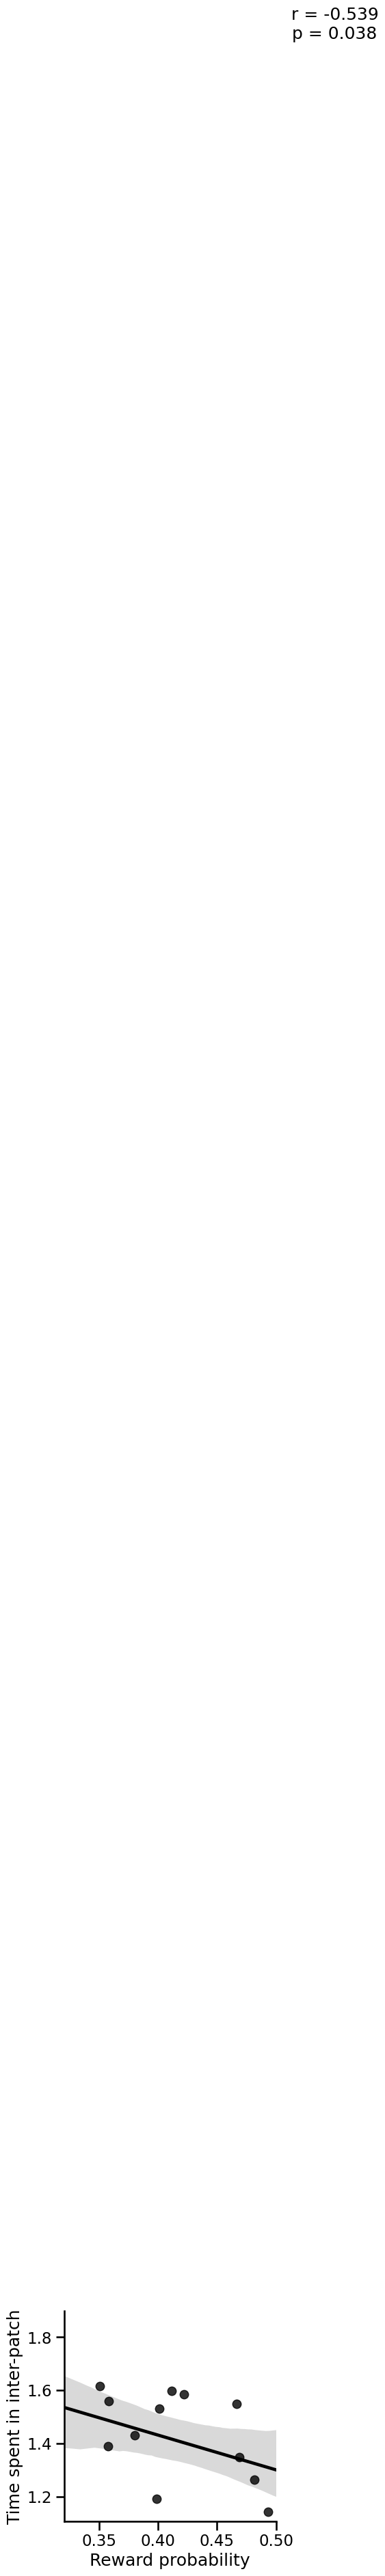

In [20]:
# Assuming summary DataFrame is already defined
# Calculate the correlation coefficient using pandas
correlation_matrix = summary[['reward_probability', 'time_spent']].corr()
correlation_coefficient = correlation_matrix.loc['reward_probability', 'time_spent']
print(f"Correlation coefficient (pandas): {correlation_coefficient}")

# Calculate the correlation coefficient and p-value using scipy
correlation_coefficient, p_value = pearsonr(summary['reward_probability'], summary['time_spent'])
print(f"Correlation coefficient (scipy): {correlation_coefficient}")
print(f"P-value: {p_value}")

fig = plt.figure(figsize=(4, 4))
# Plot the regression plot
sns.regplot(data=summary, x='reward_probability', y='time_spent', color='black')
plt.text(0.55, 10.5, f"r = {correlation_coefficient:.3f}\np = {p_value:.3f}", ha='center', va='center')
plt.xlabel('Reward probability')
plt.ylabel('Time spent in inter-patch')
plt.xlim(0.32, 0.5)
sns.despine()
fig.savefig(results_path+f'/time_spent_vs_reward_probability.svg', dpi=300, bbox_inches='tight')

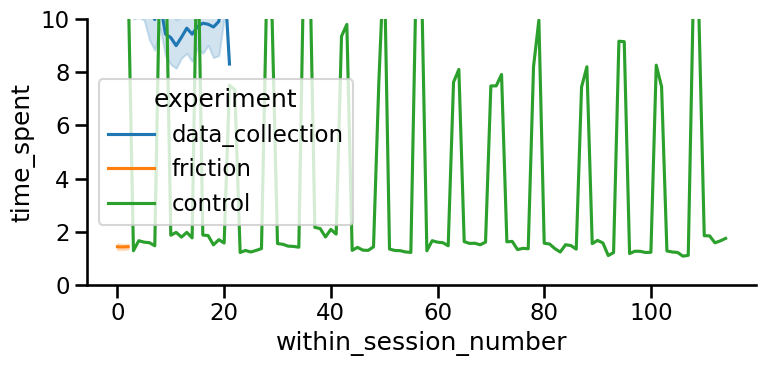

In [21]:
df = summary_df.loc[summary_df.label == 'InterPatch'].groupby(['mouse','within_session_number', 'experiment']).time_spent.median().reset_index()
fig = plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='within_session_number', y='time_spent', hue='experiment', markers=True)
sns.despine()
plt.ylim(0,10)
plt.tight_layout()
plt.show()

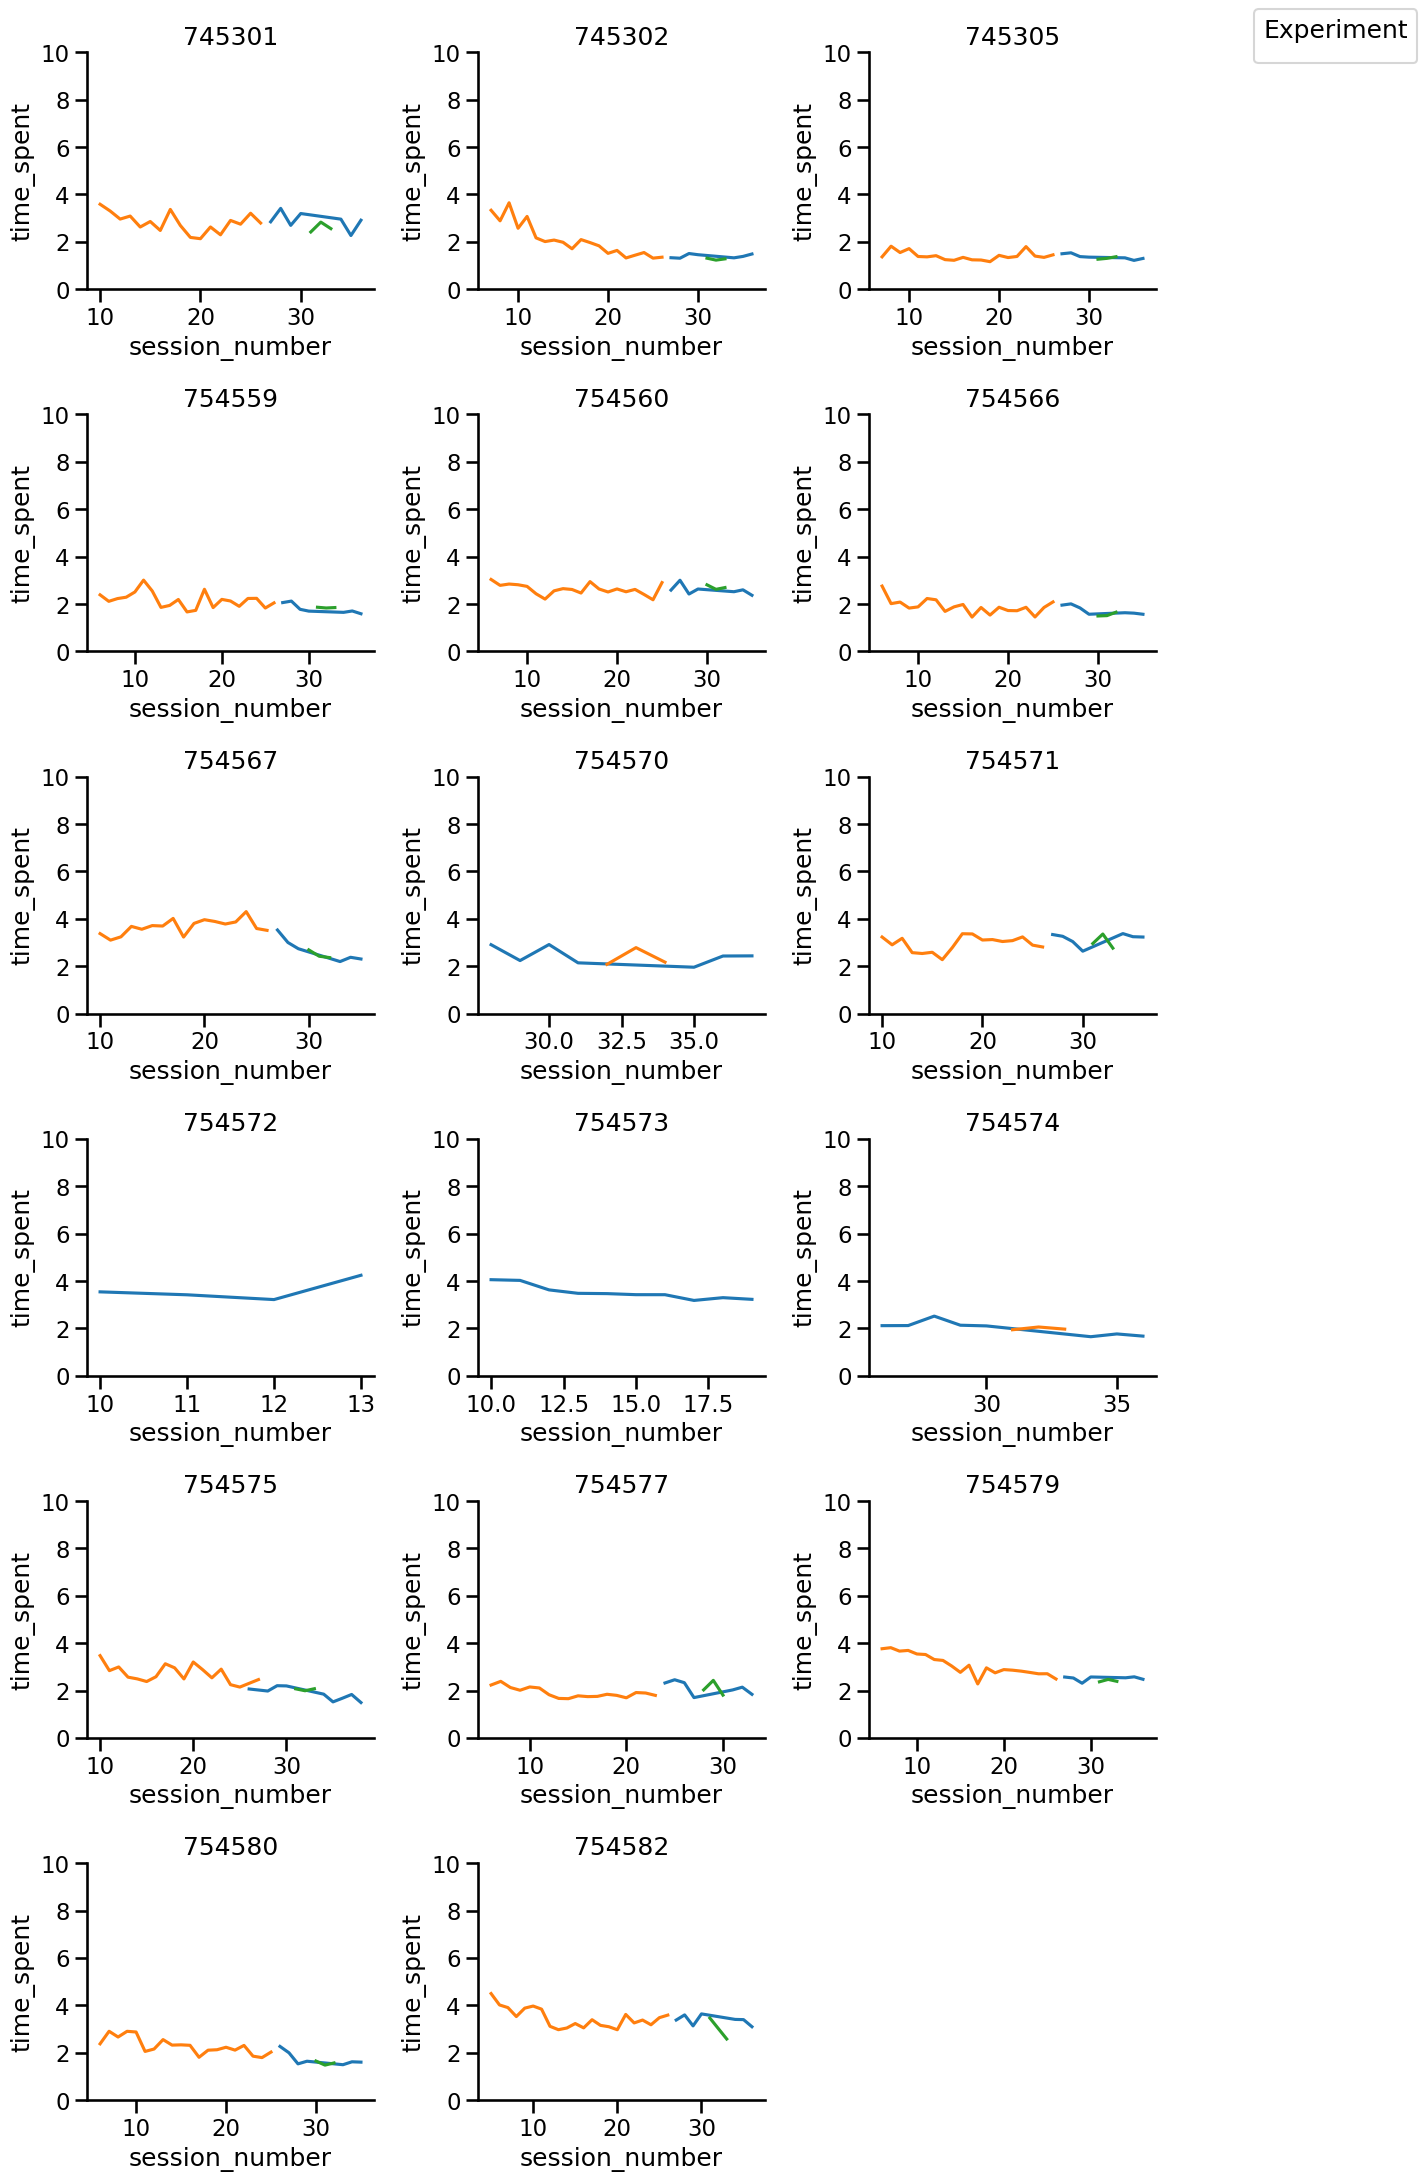

In [22]:
df = summary_df.groupby(['mouse','experiment','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
axes = []
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 3, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_number', y='time_spent', hue='experiment', markers=True, legend=False)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,10)
    axes.append(ax)
# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Experiment')
plt.tight_layout()
plt.show()

## **P(reward)**

In [13]:
groups = ['session','mouse','active_patch','odor_label','experiment']

In [23]:
summary_df.loc[(summary_df.last_site == 1)&(summary_df.visit_number != 0)]

Seconds       label  start_position  length  friction  \
29175   1.278198e+06  RewardSite     1883.016264    50.0       0.0   
29209   1.278319e+06  RewardSite     3675.897110    50.0       0.0   
29255   1.278471e+06  RewardSite     6003.129330    50.0       0.0   
29267   1.278519e+06  RewardSite     6741.731397    50.0       0.0   
29309   1.278675e+06  RewardSite     8883.699352    50.0       0.0   
...              ...         ...             ...     ...       ...   
664288  2.150739e+06  RewardSite    50769.816197    50.0       0.0   
664309  2.150814e+06  RewardSite    51988.512110    50.0       0.0   
664330  2.150883e+06  RewardSite    53111.391787    50.0       0.0   
664354  2.150970e+06  RewardSite    54798.595109    50.0       0.0   
664374  2.151039e+06  RewardSite    56162.719202    50.0       0.0   

       previous_epoch  active_patch  visit_number has_choice  \
29175       InterSite           0.0          17.0      False   
29209       InterSite           1.0          15.0      False   
29255       InterSite           2.0          21.0      False   
29267       InterSite           3.0           4.0      False   
29309       InterSite           4.0          19.0      False   
...               ...           ...           ...        ...   
664288      InterSite          29.0          25.0      False   
664309      InterSite          30.0           8.0      False   
664330      InterSite          31.0           8.0      False   
664354      InterSite          33.0           7.0      False   
664374      InterSite          35.0           5.0      False   

        reward_delivered  ...  perceived_reward_probability  engaged  \
29175                0.0  ...                      0.388889     True   
29209                0.0  ...                      0.437500     True   
29255                0.0  ...                      0.363636     True   
29267                0.0  ...                      0.000000     True   
29309                0.0  ...                      0.400000     True   
...                  ...  ...                           ...      ...   
664288               0.0  ...                      0.500000     True   
664309               0.0  ...                      0.555556     True   
664330               0.0  ...                      0.555556     True   
664354               0.0  ...                      0.625000     True   
664374               0.0  ...                      0.500000     True   

        duration_epoch   mouse   session  within_session_number  \
29175         1.697984  754570  20241017                      1   
29209         0.988000  754570  20241017                      1   
29255         1.764992  754570  20241017                      1   
29267         5.279008  754570  20241017                      1   
29309         1.420000  754570  20241017                      1   
...                ...     ...       ...                    ...   
664288        2.357024  745301  20241027                    114   
664309        1.937024  745301  20241027                    114   
664330        1.431008  745301  20241027                    114   
664354        1.745984  745301  20241027                    114   
664374        1.738016  745301  20241027                    114   

        session_number  experiment     next_site  time_spent  
29175               28     control  1.278200e+06    1.697984  
29209               28     control  1.278320e+06    0.988000  
29255               28     control  1.278473e+06    1.764992  
29267               28     control  1.278524e+06    5.279008  
29309               28     control  1.278676e+06    1.420000  
...                ...         ...           ...         ...  
664288              36     control  2.150741e+06    2.357024  
664309              36     control  2.150816e+06    1.937024  
664330              36     control  2.150885e+06    1.431008  
664354              36     control  2.150972e+06    1.745984  
664374              36     control  2.15

In [24]:
summary_df.loc[(summary_df.last_site == 1)&(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(groups).agg({'reward_delivered':'sum','visit_number':'count'}).reset_index()

Empty DataFrame
Columns: [session, mouse, active_patch, odor_label, experiment, reward_delivered, visit_number]
Index: []

### **P(reward) across sessions and across experiments**

#### Per mouse

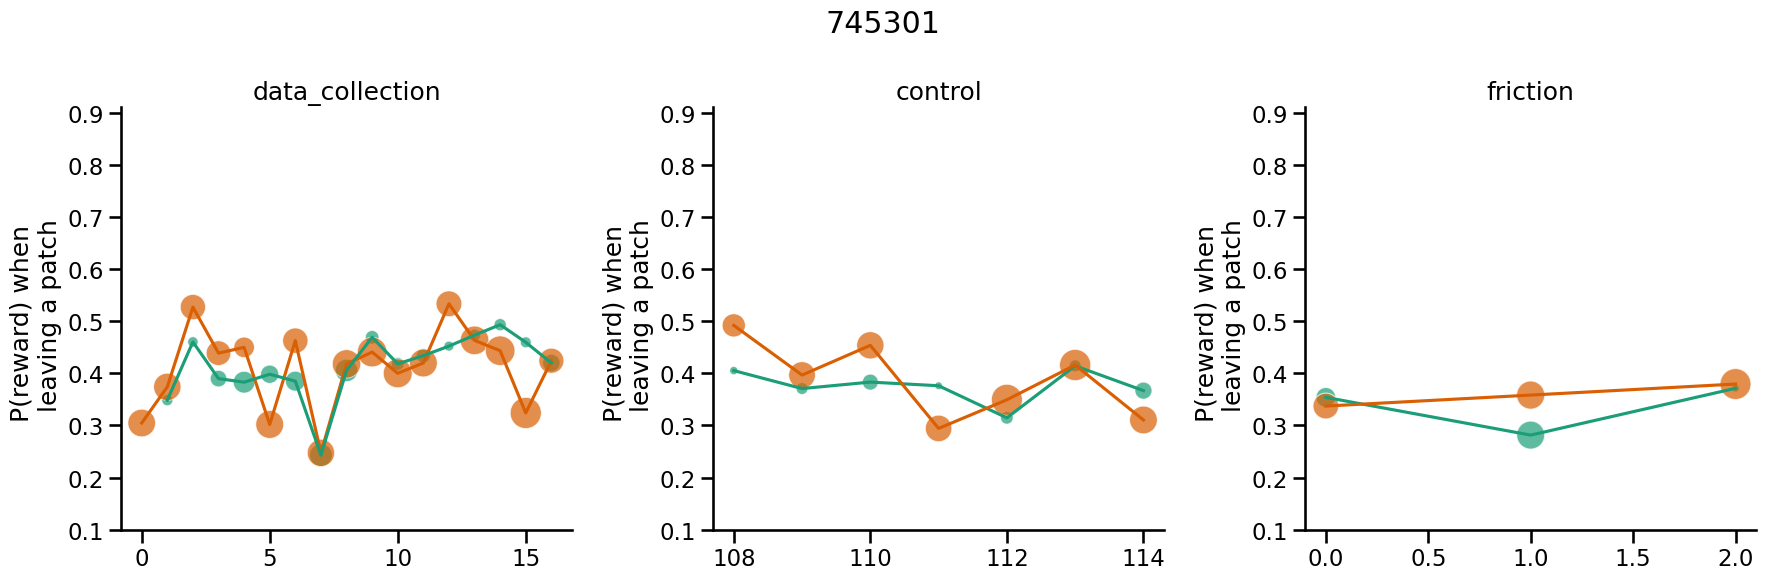

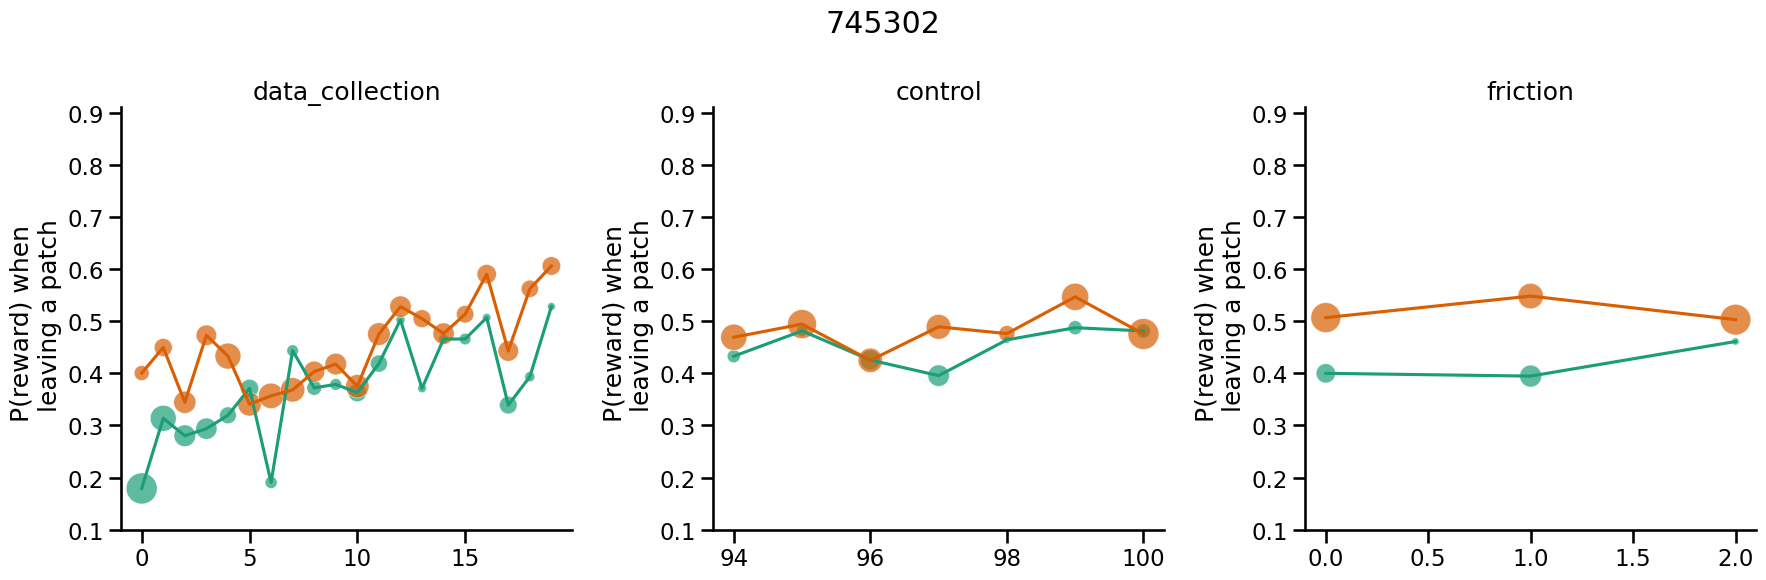

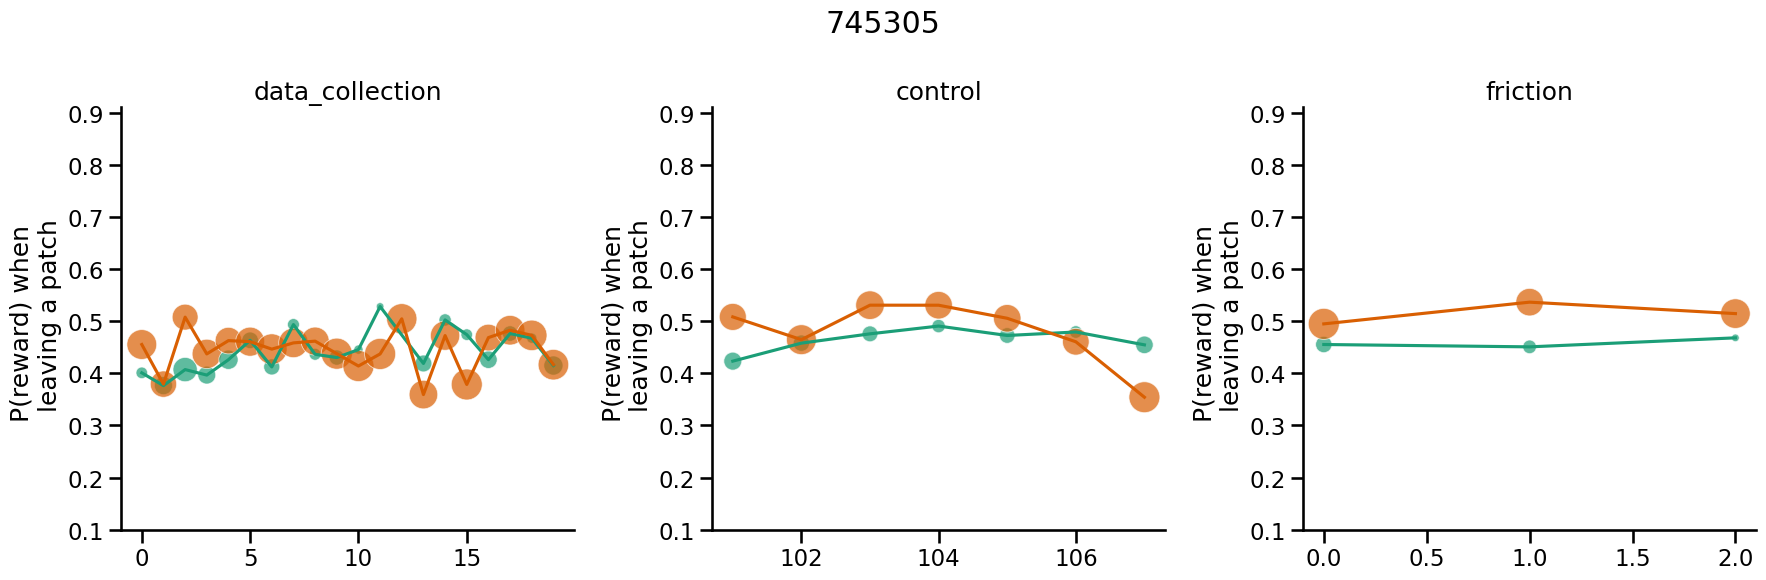

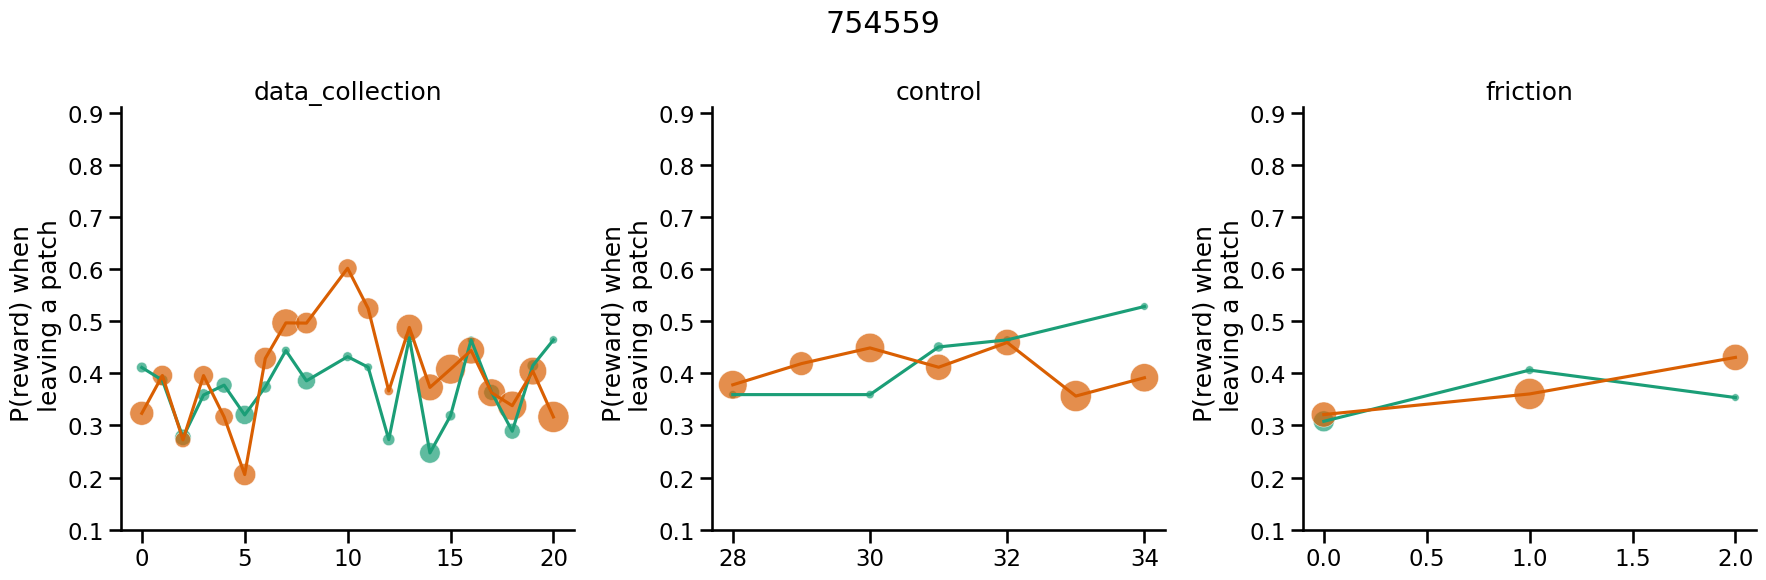

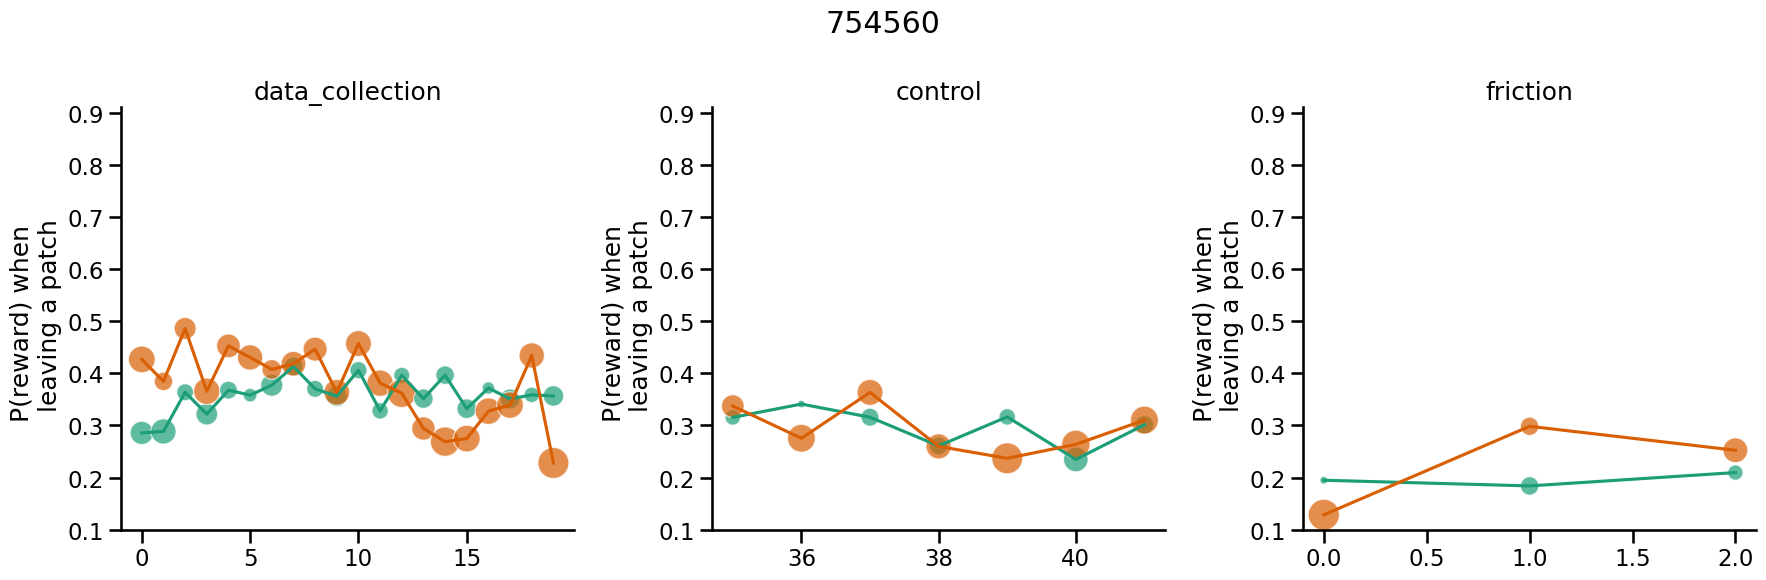

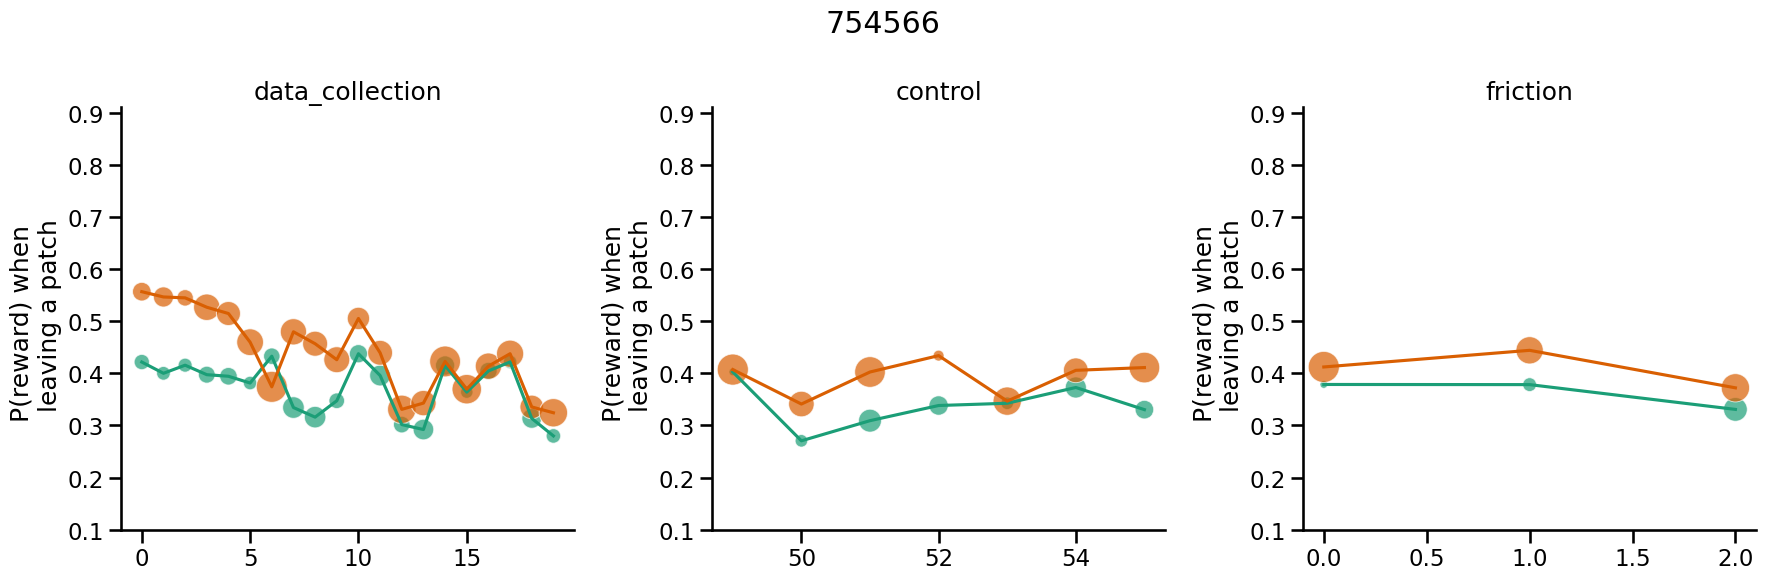

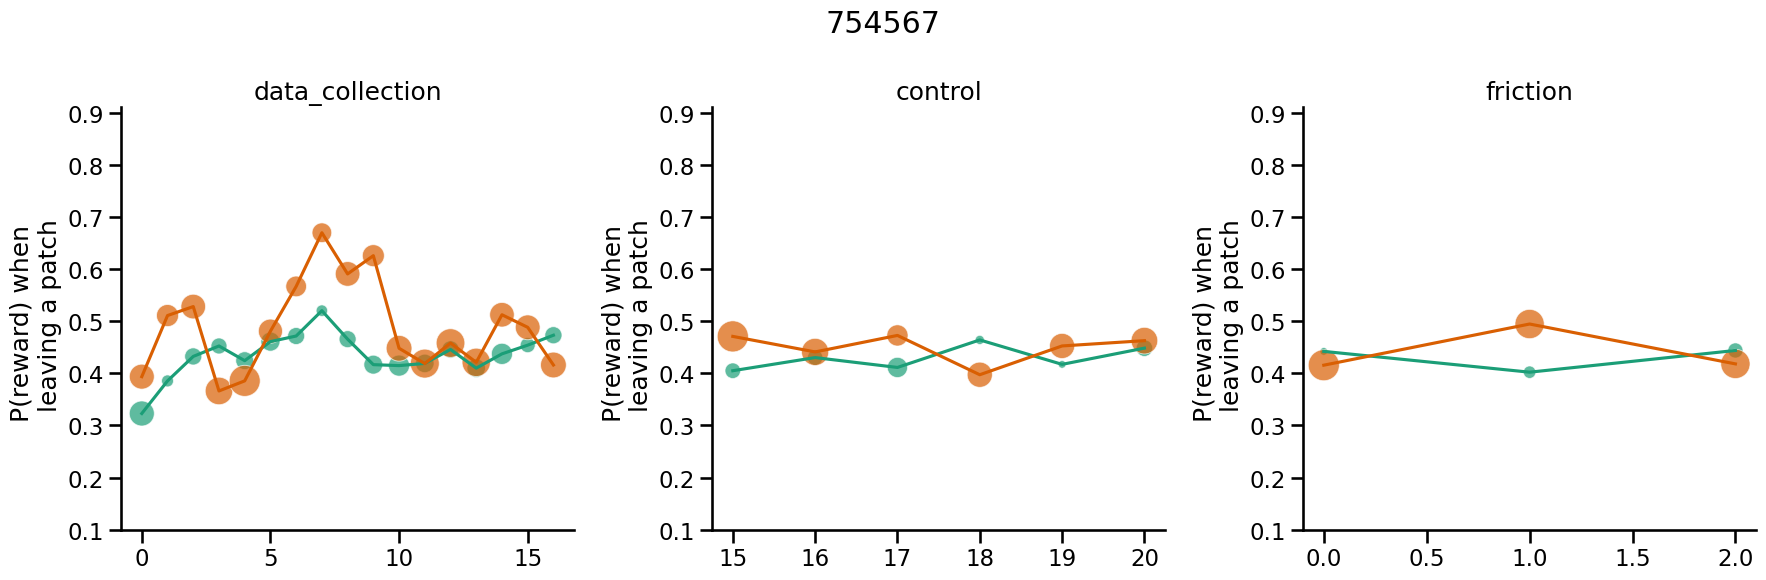

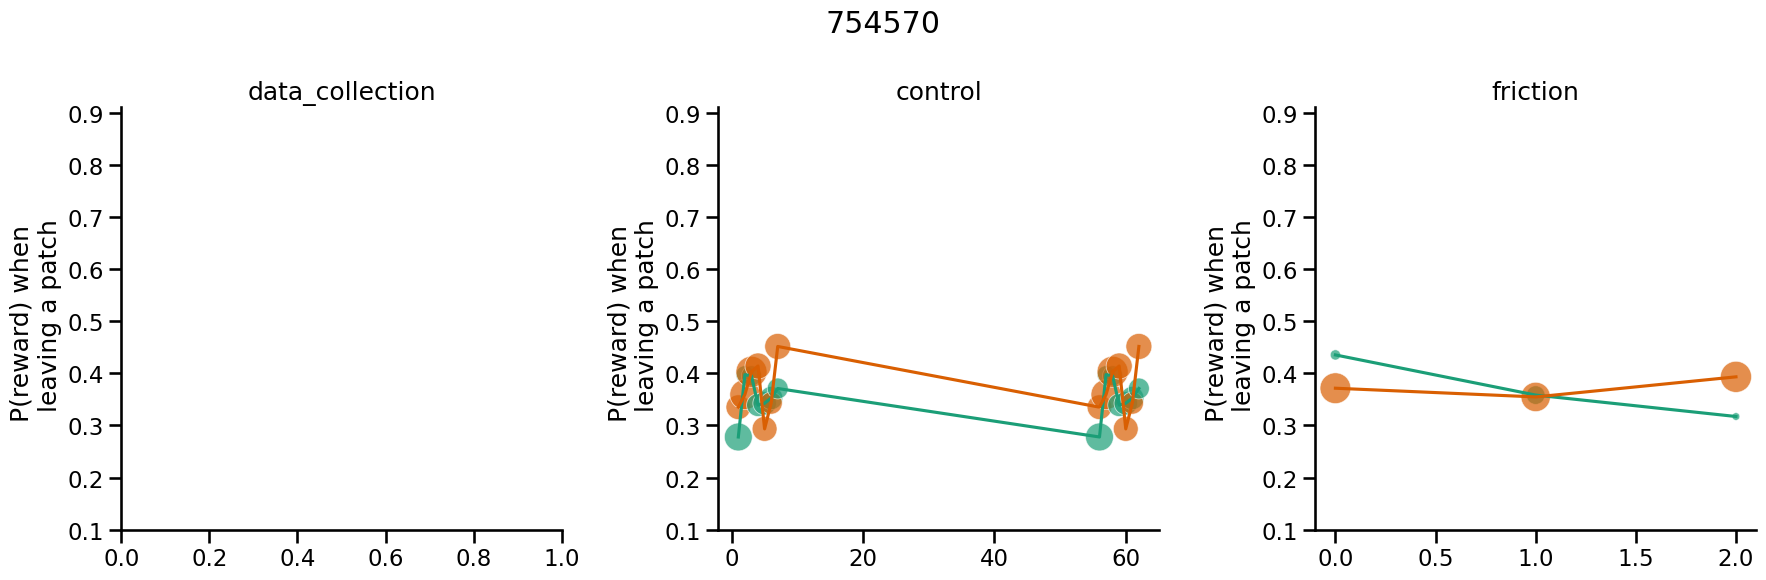

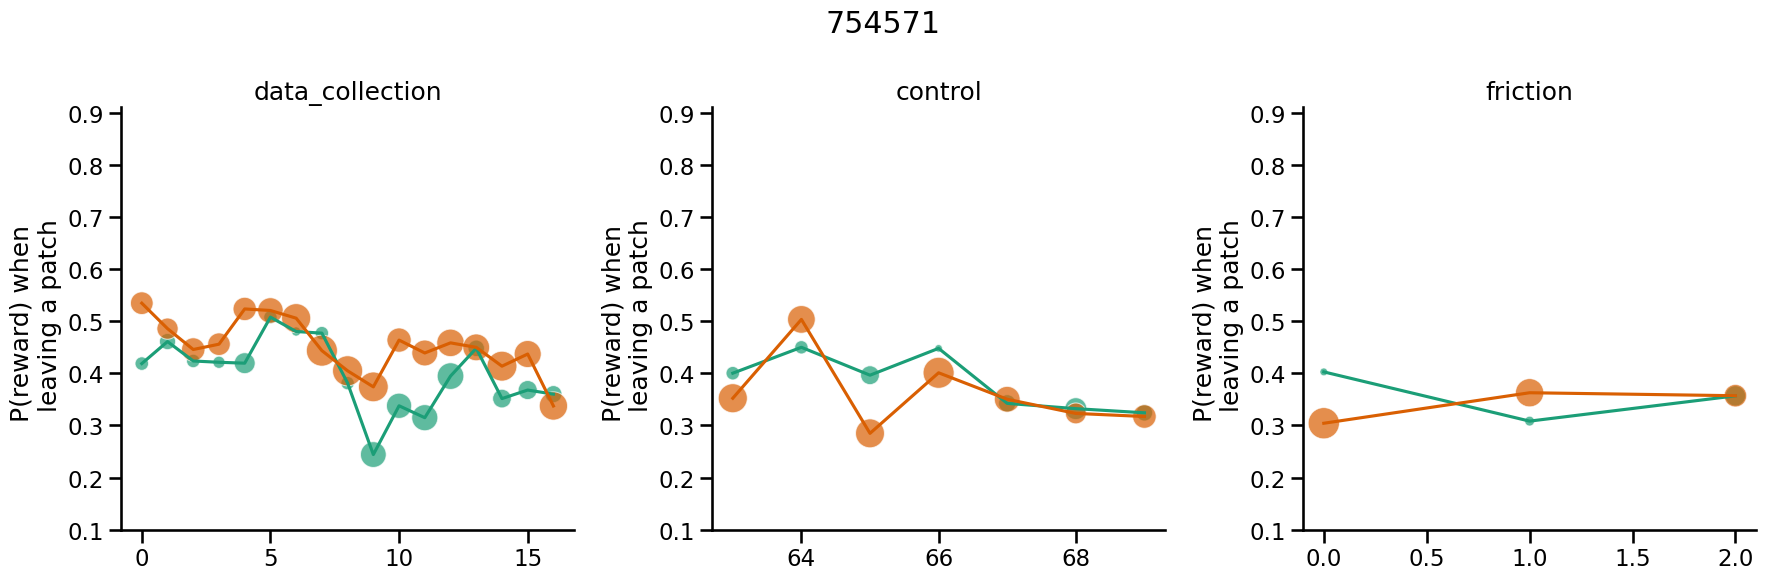

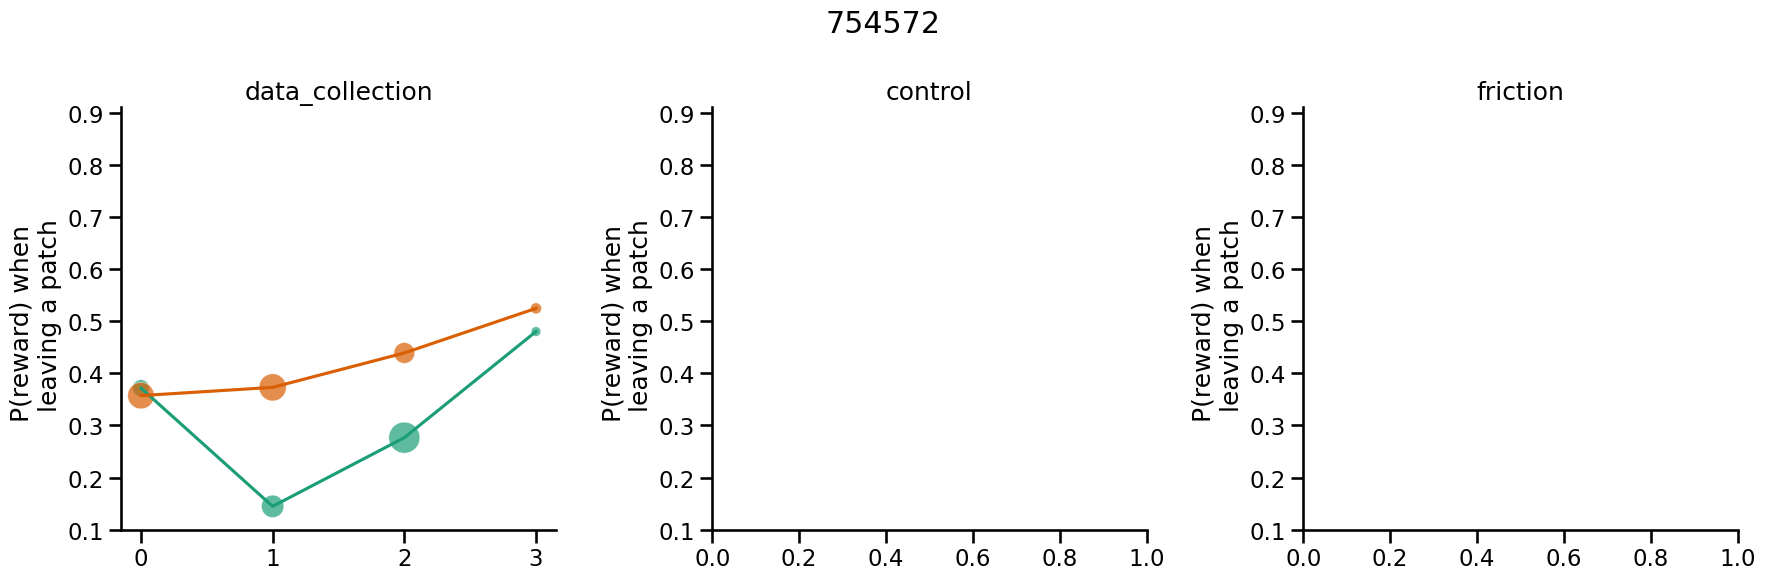

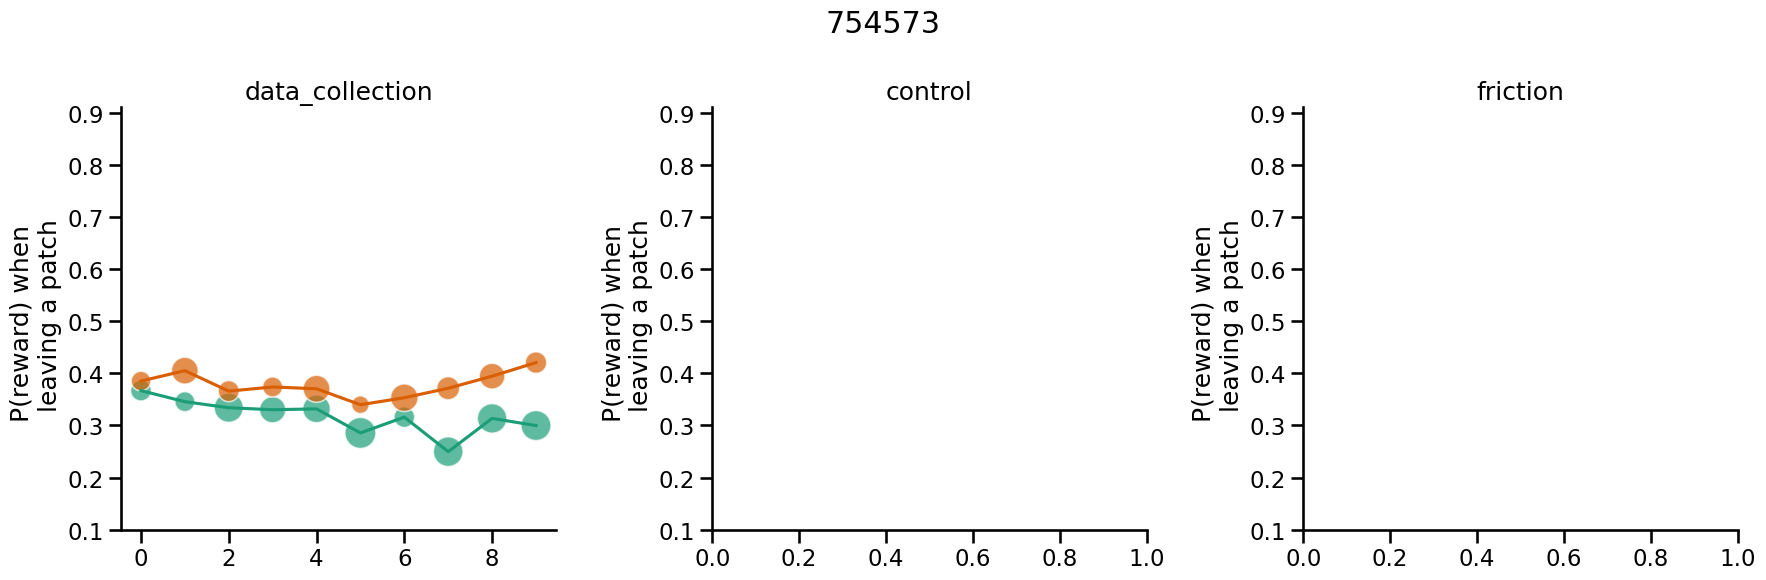

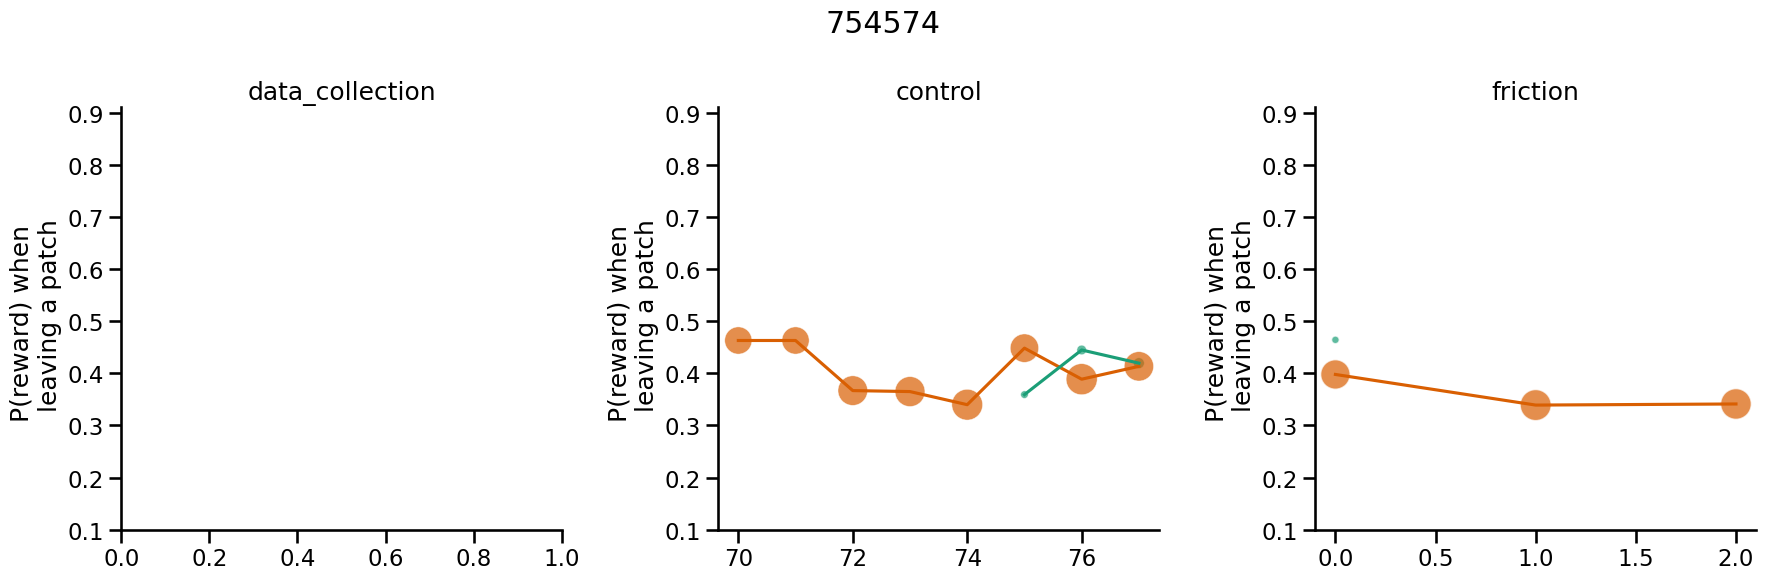

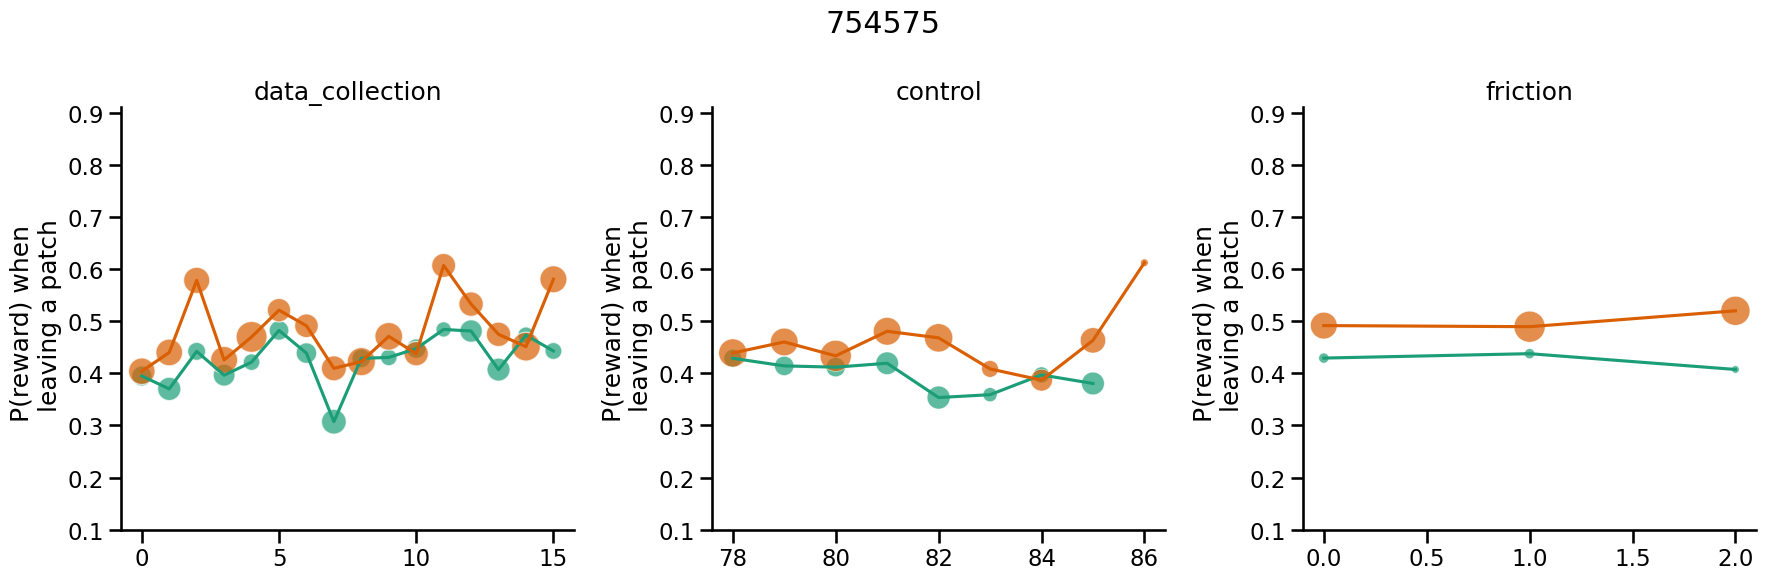

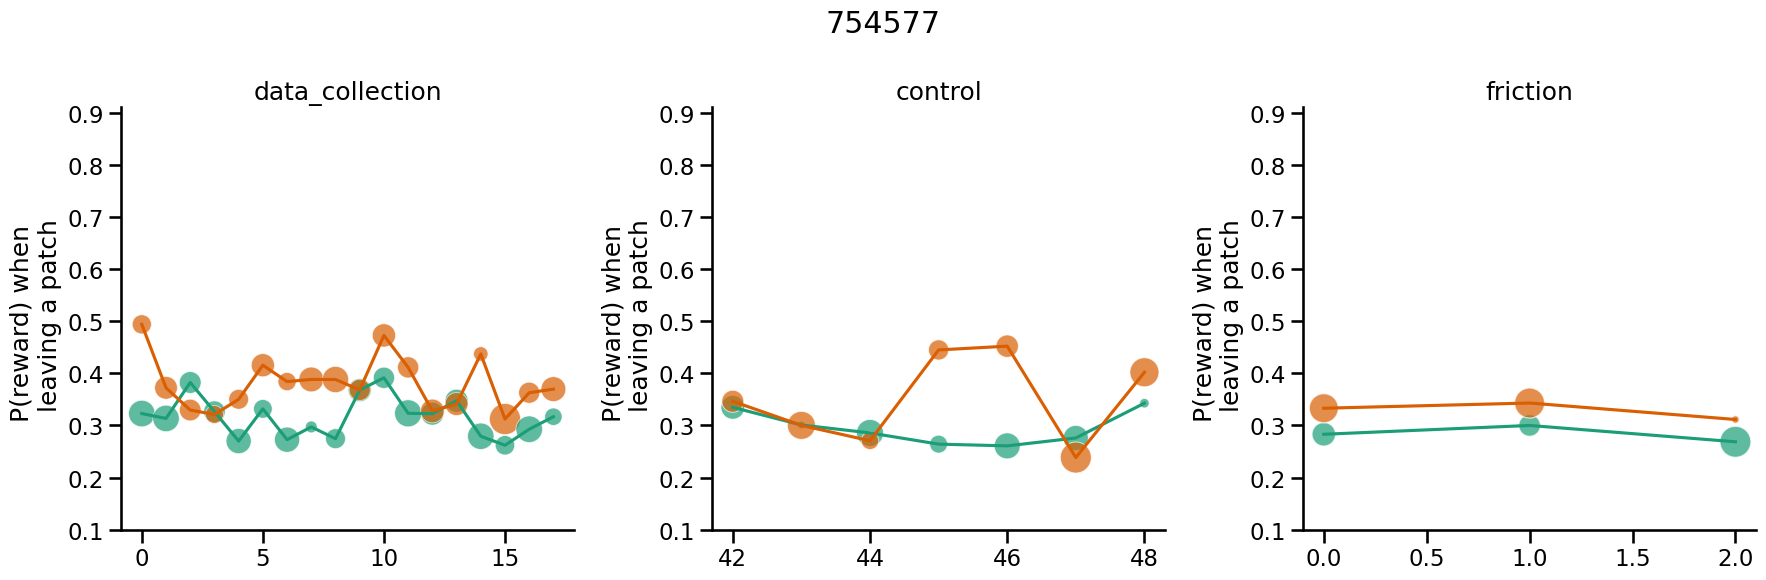

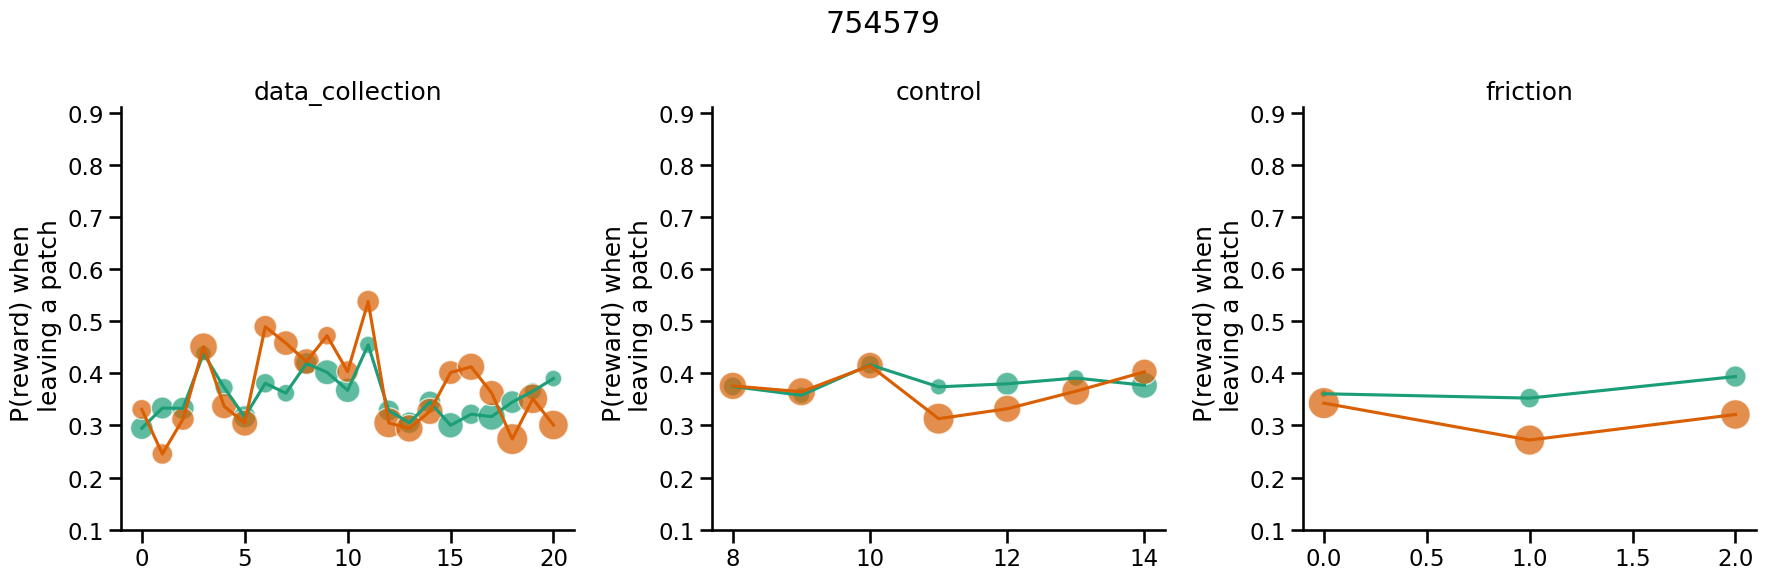

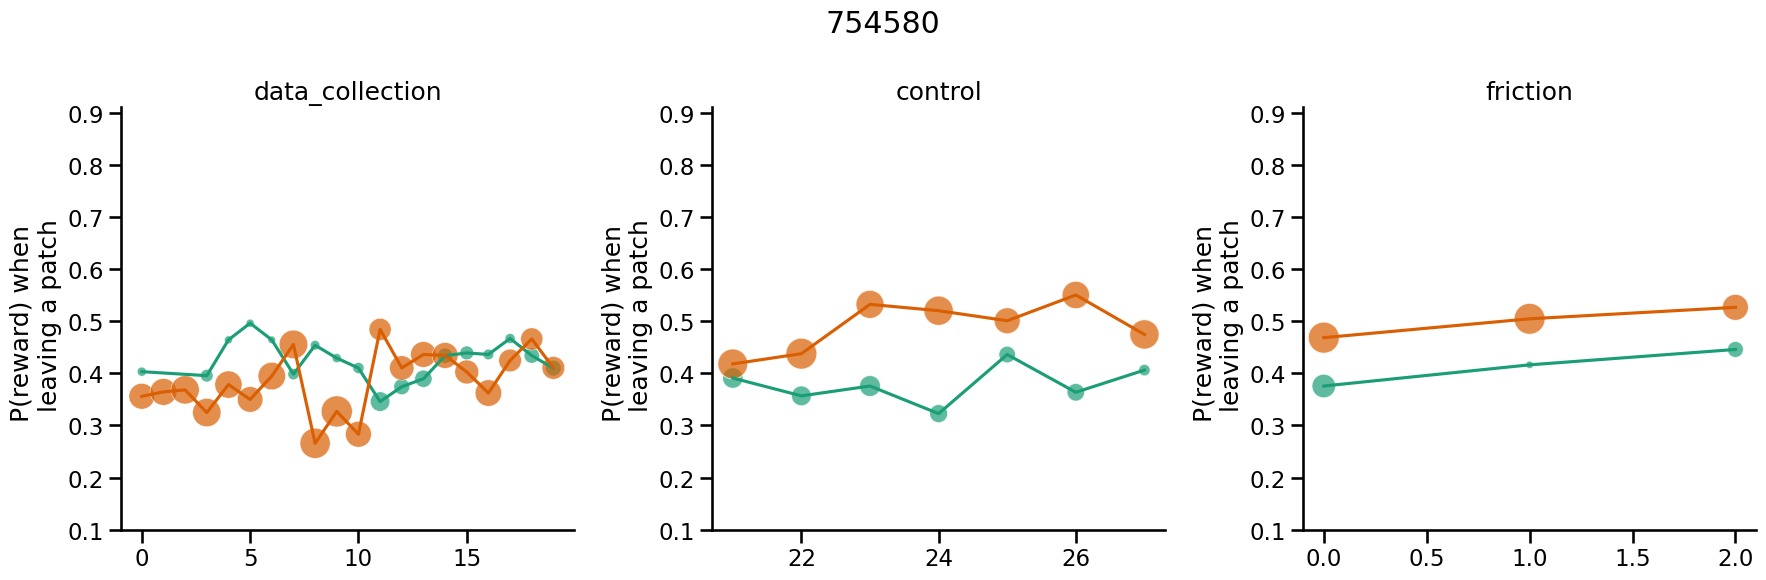

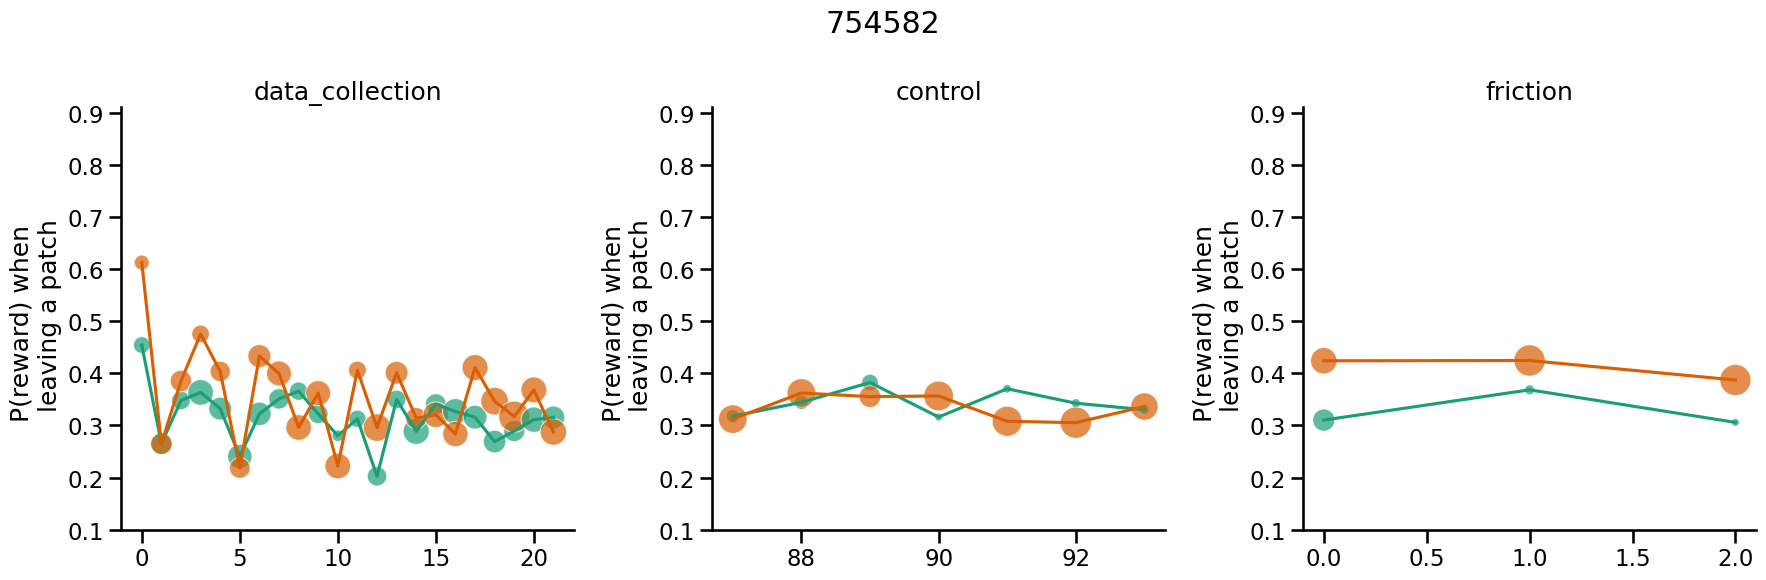

In [25]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 2)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['data_collection', 'control', 'friction']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='', ax=ax)

        plt.title(f'{experiment}')

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()

# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

#### Average across mice

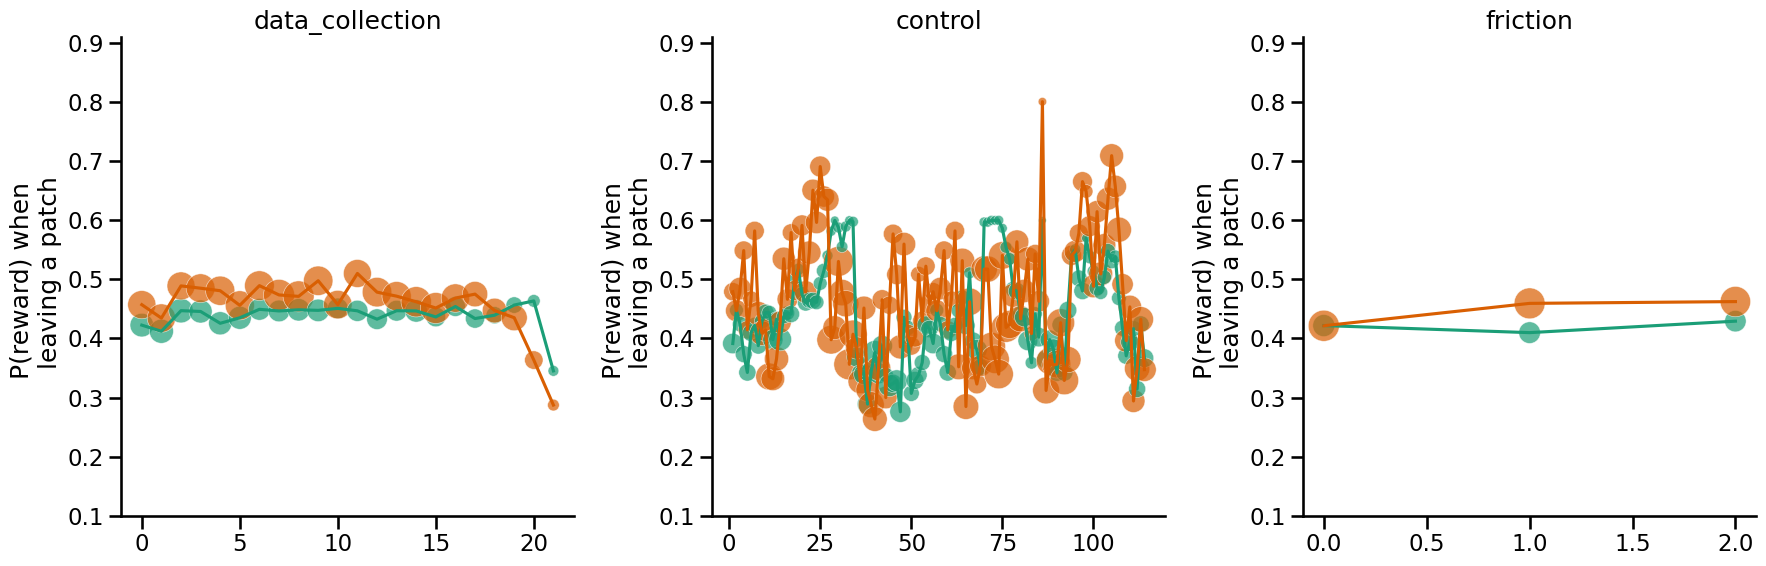

In [26]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 0)]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()
summary = summary.groupby(['within_session_number','odor_label','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

fig = plt.figure(figsize=(18,6))

# print(summary.loc[summary.mouse == mouse])
# print('\n')
for i, experiment in enumerate(['data_collection', 'control', 'friction']):
    ax = plt.subplot(1, 3, i + 1)
        
    sns.scatterplot(summary.loc[(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

    sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)], marker='', ax=ax)

    plt.title(f'{experiment}')

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    plt.ylim(0.10,0.91)
    sns.despine()
    
# plt.suptitle(f'{mouse}')
plt.tight_layout()
plt.show()

fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

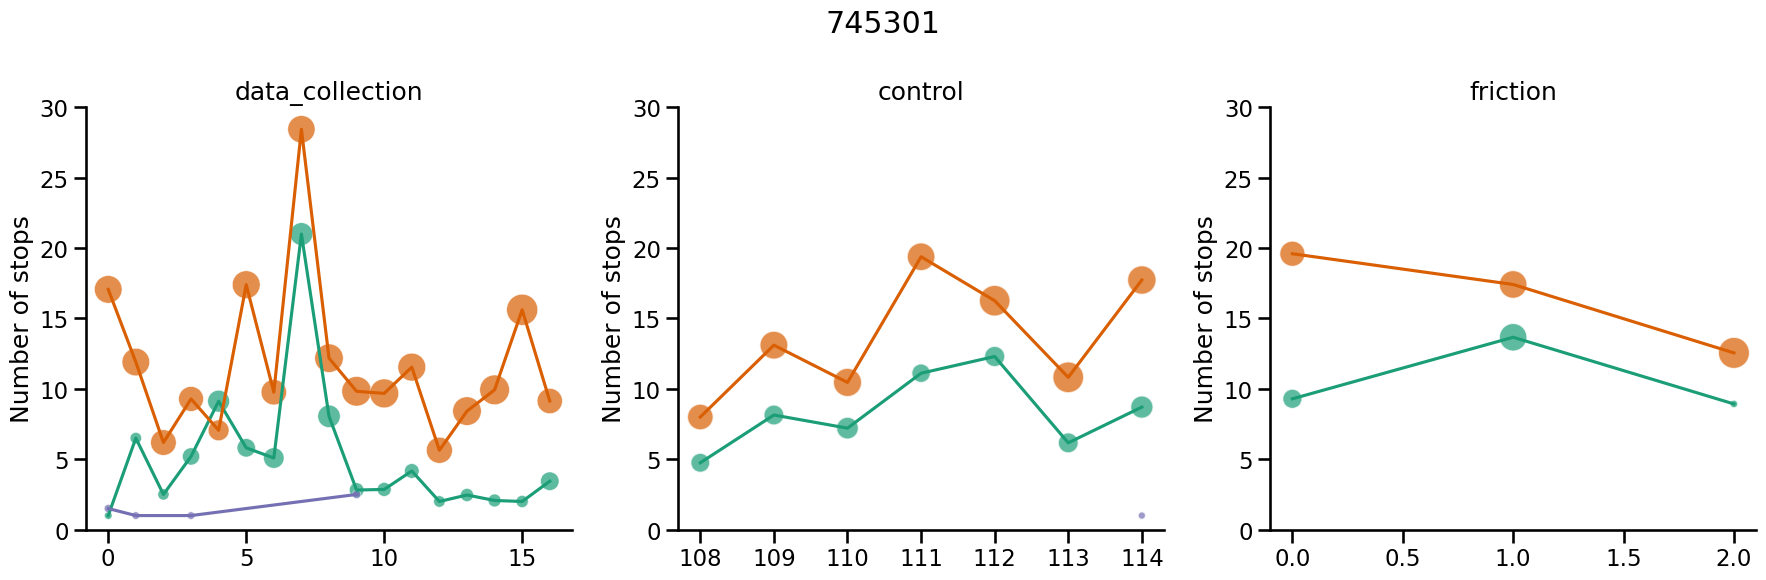

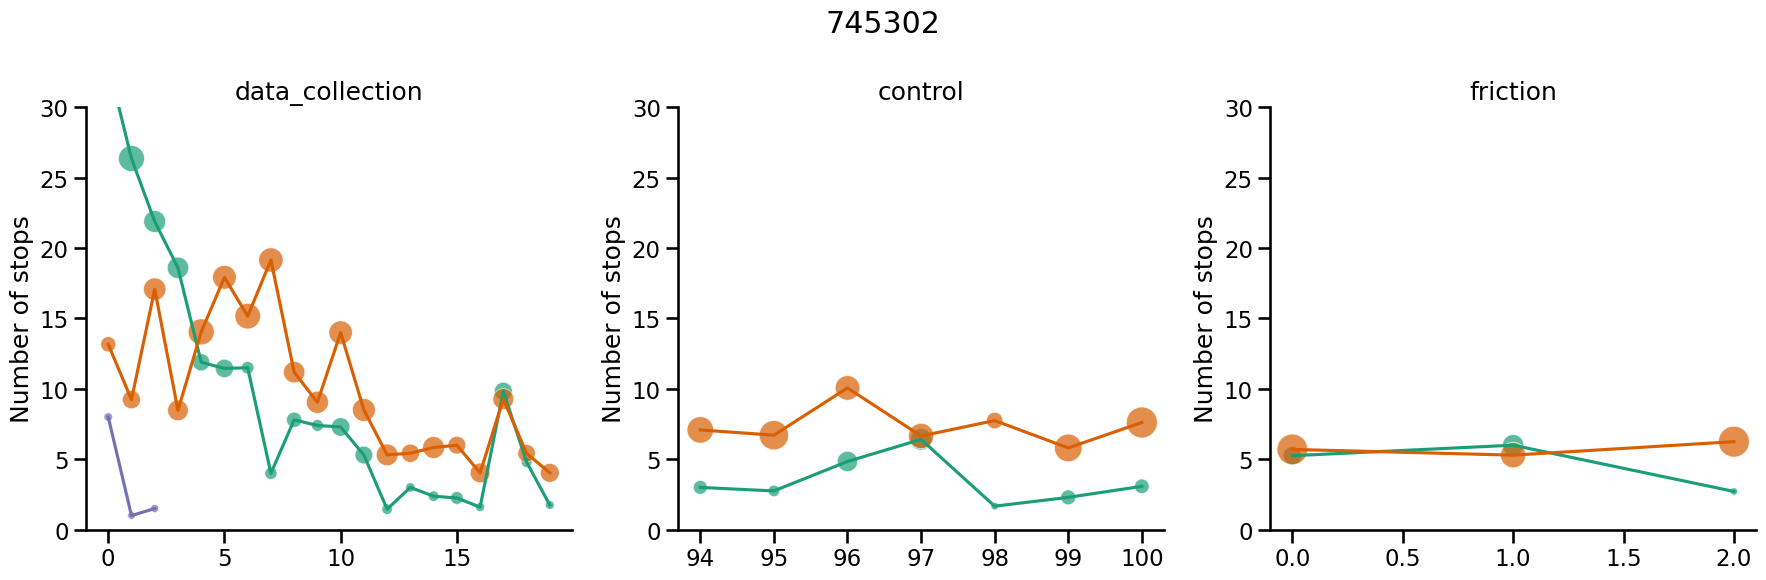

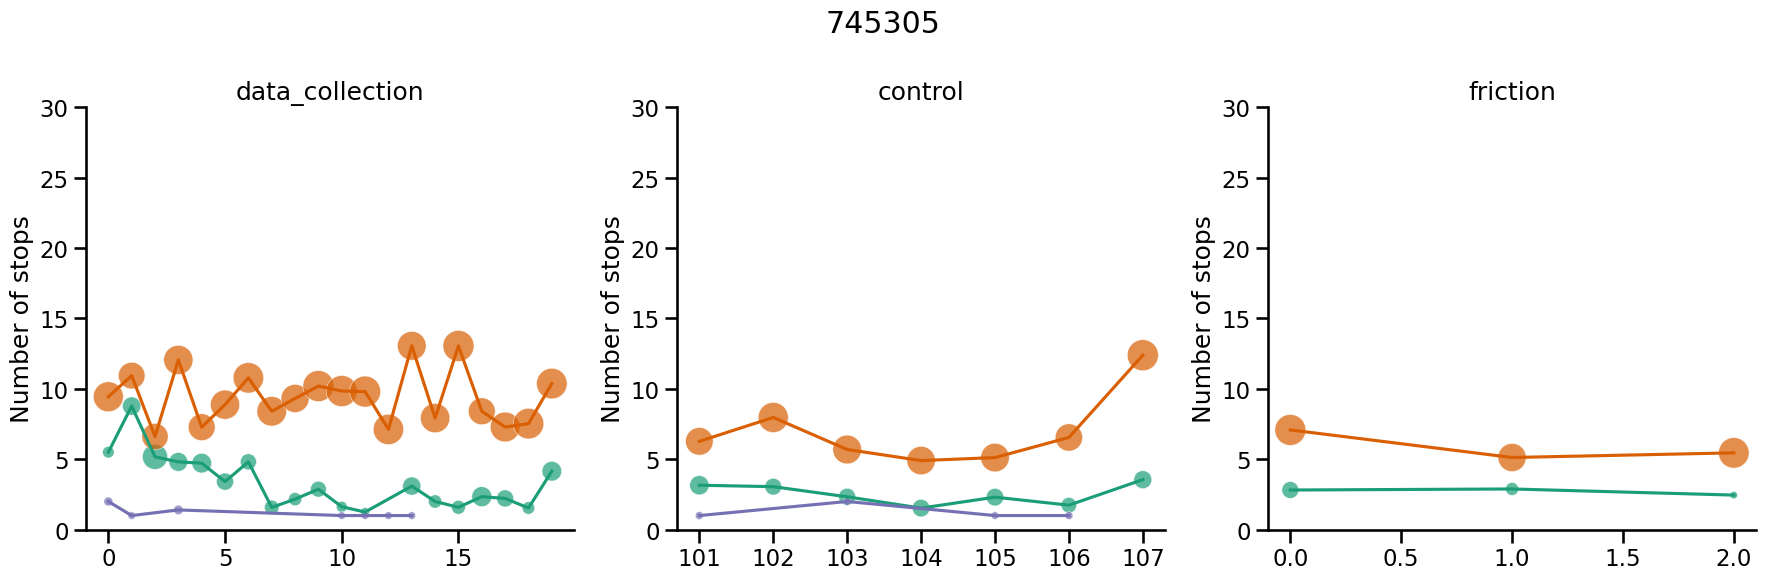

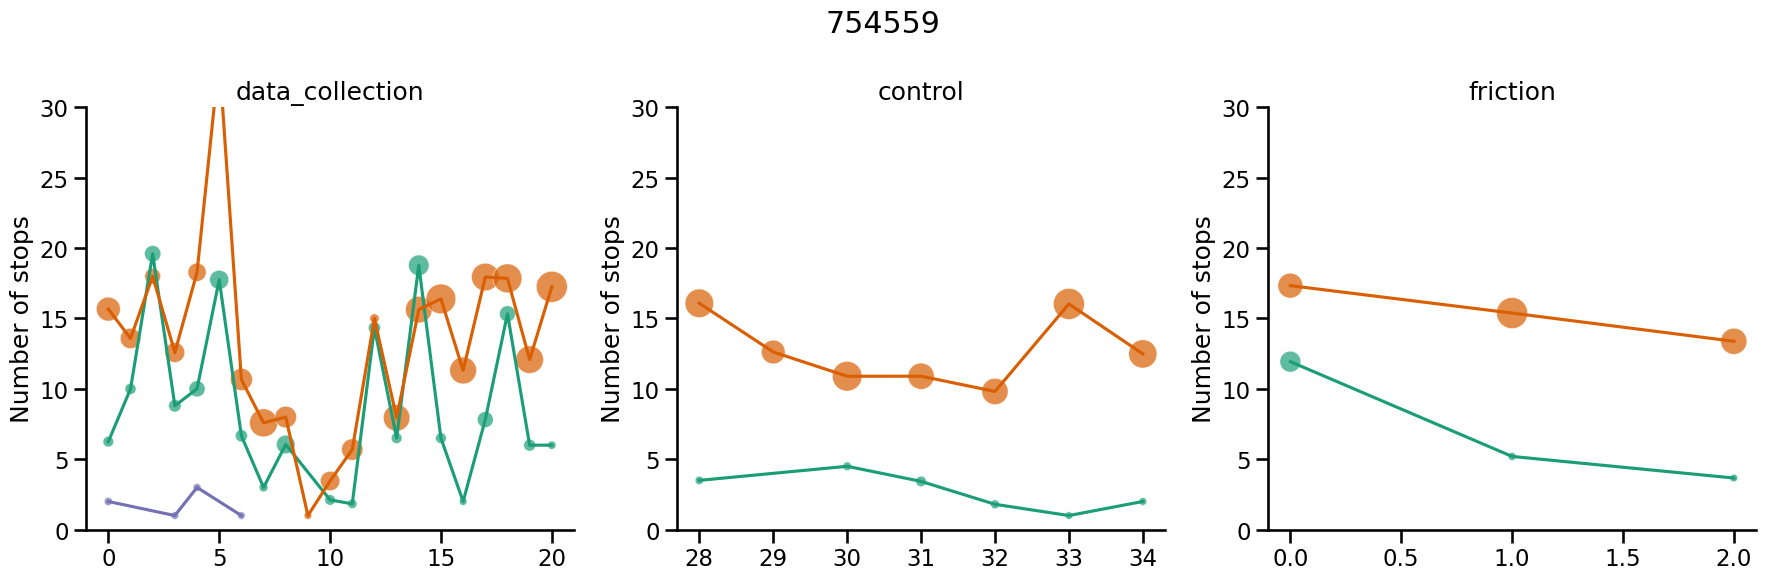

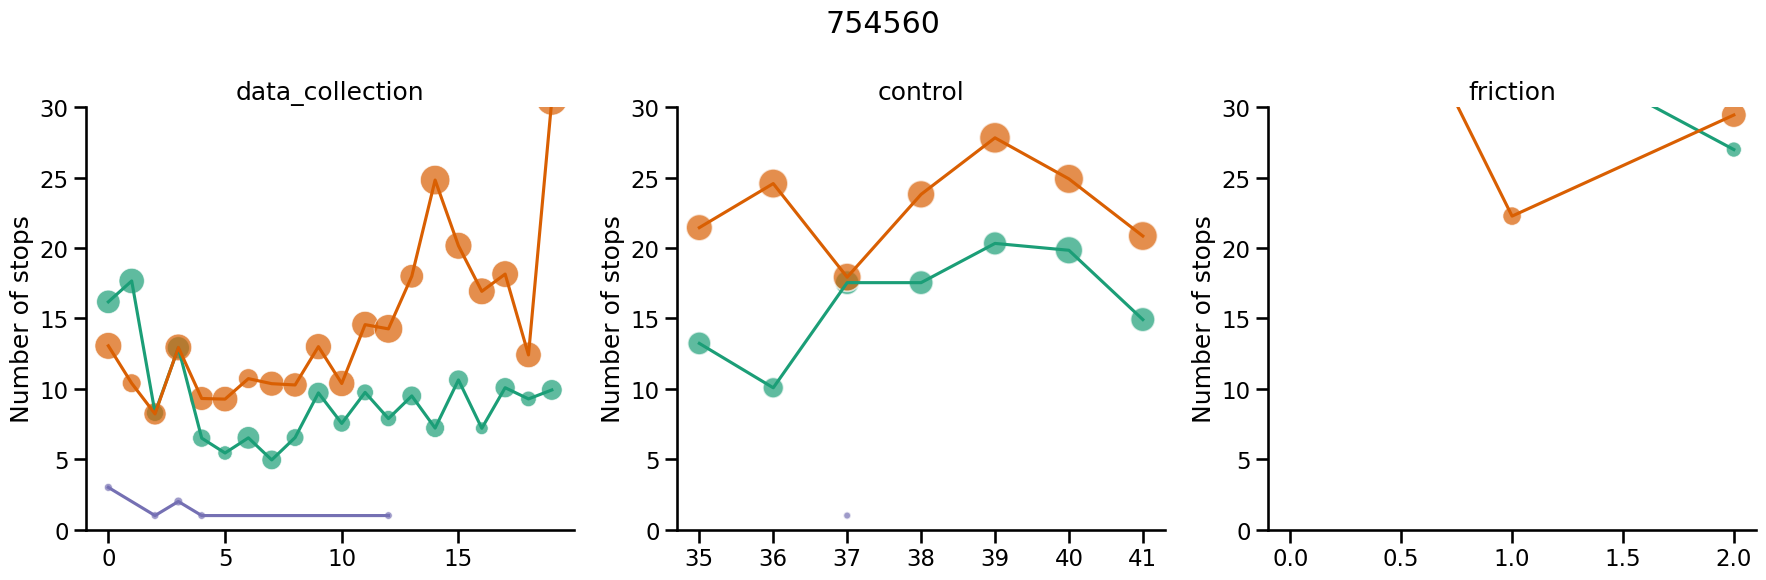

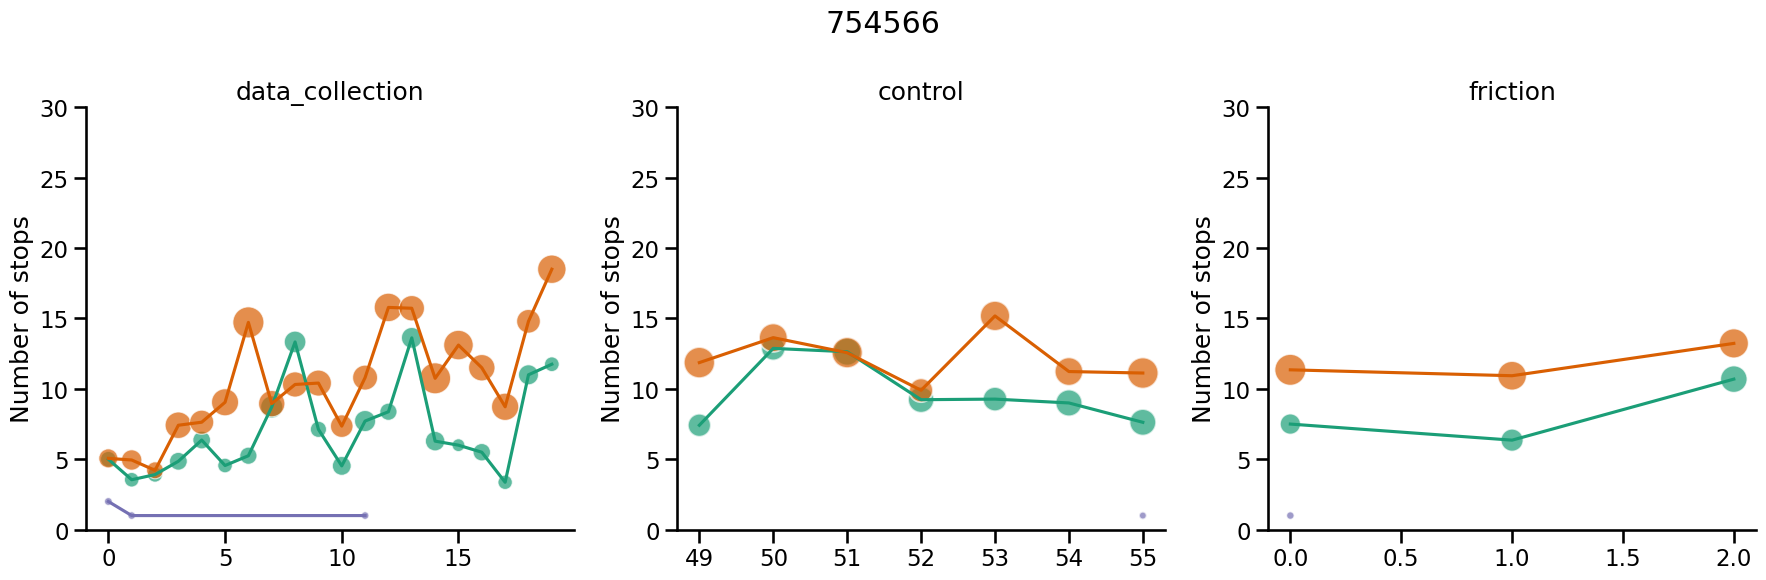

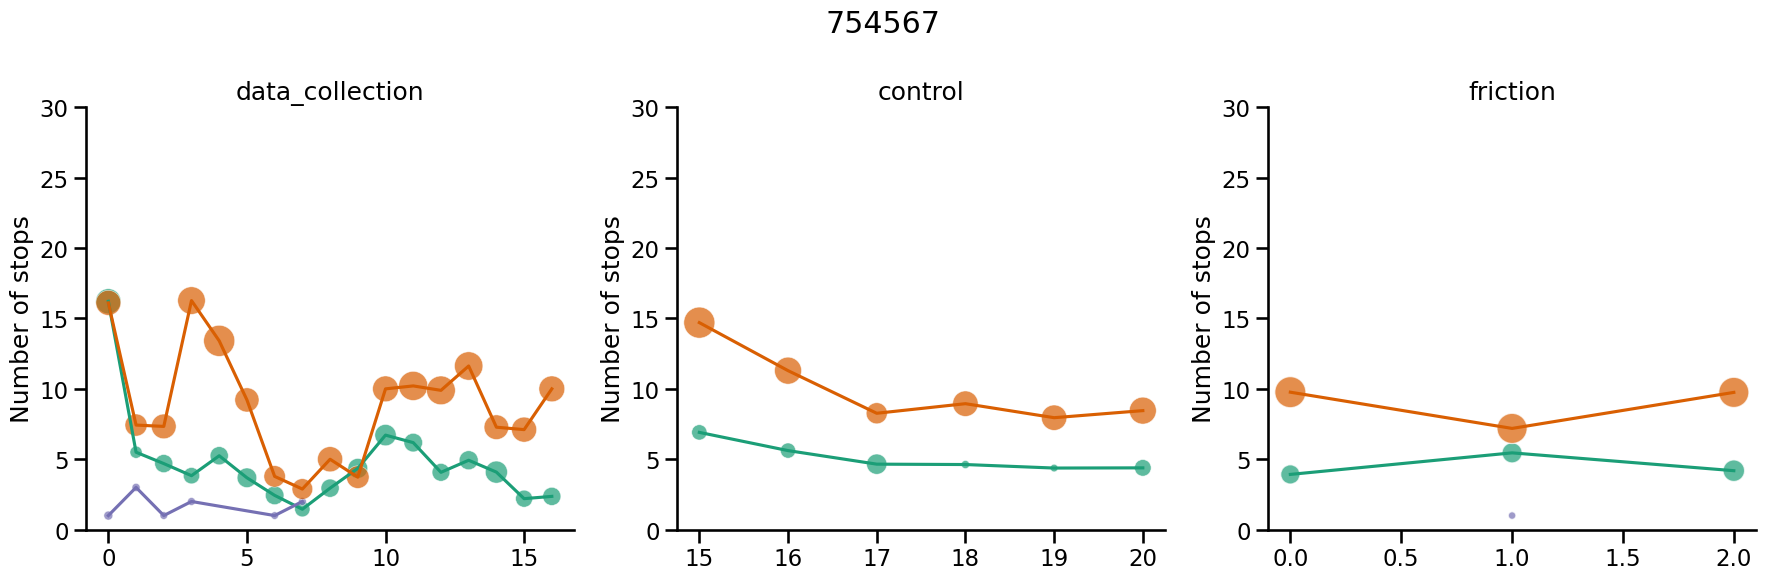

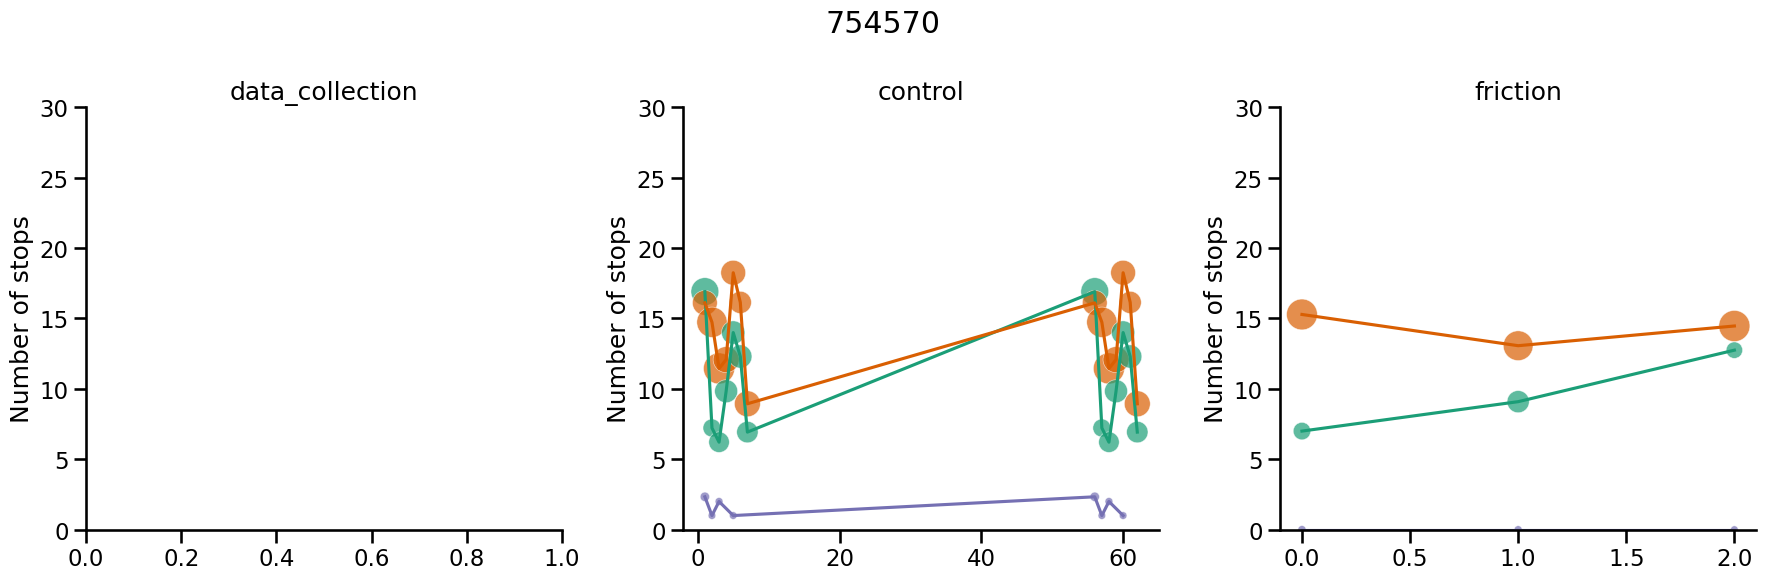

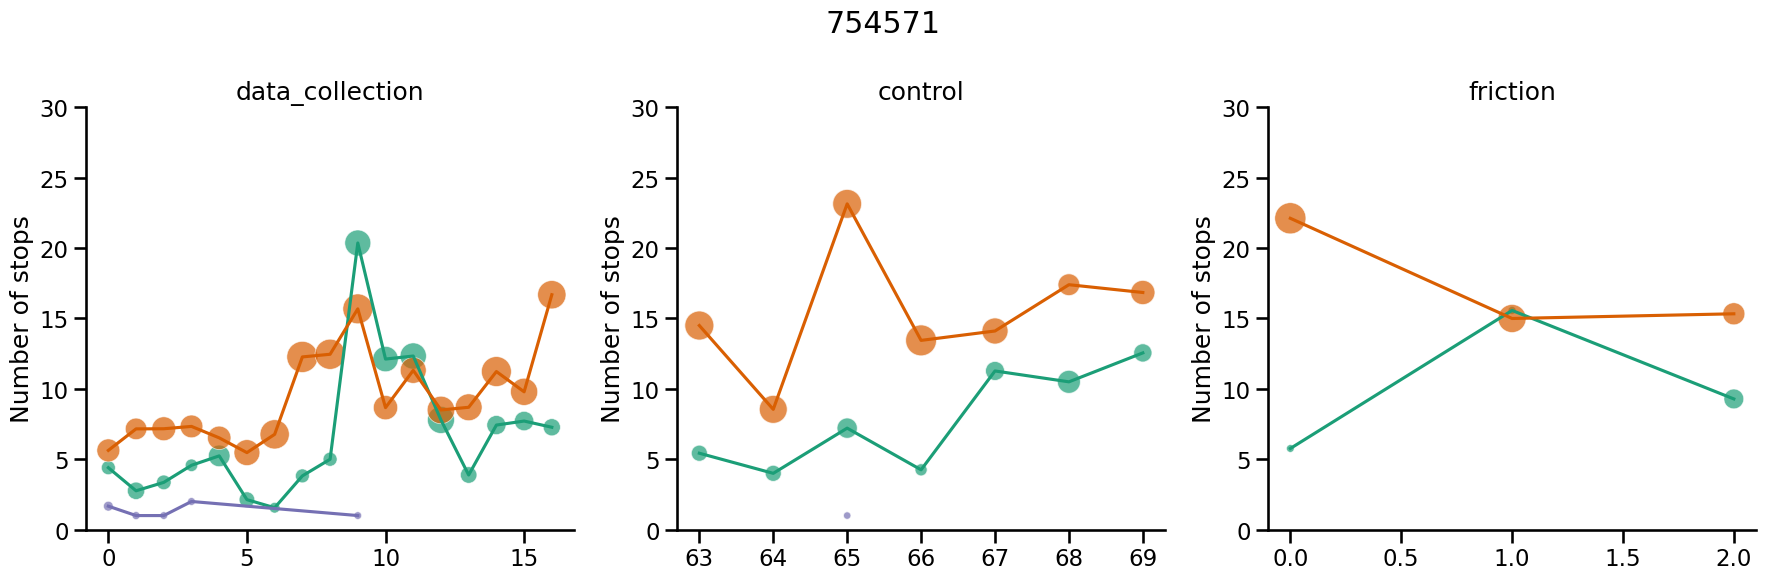

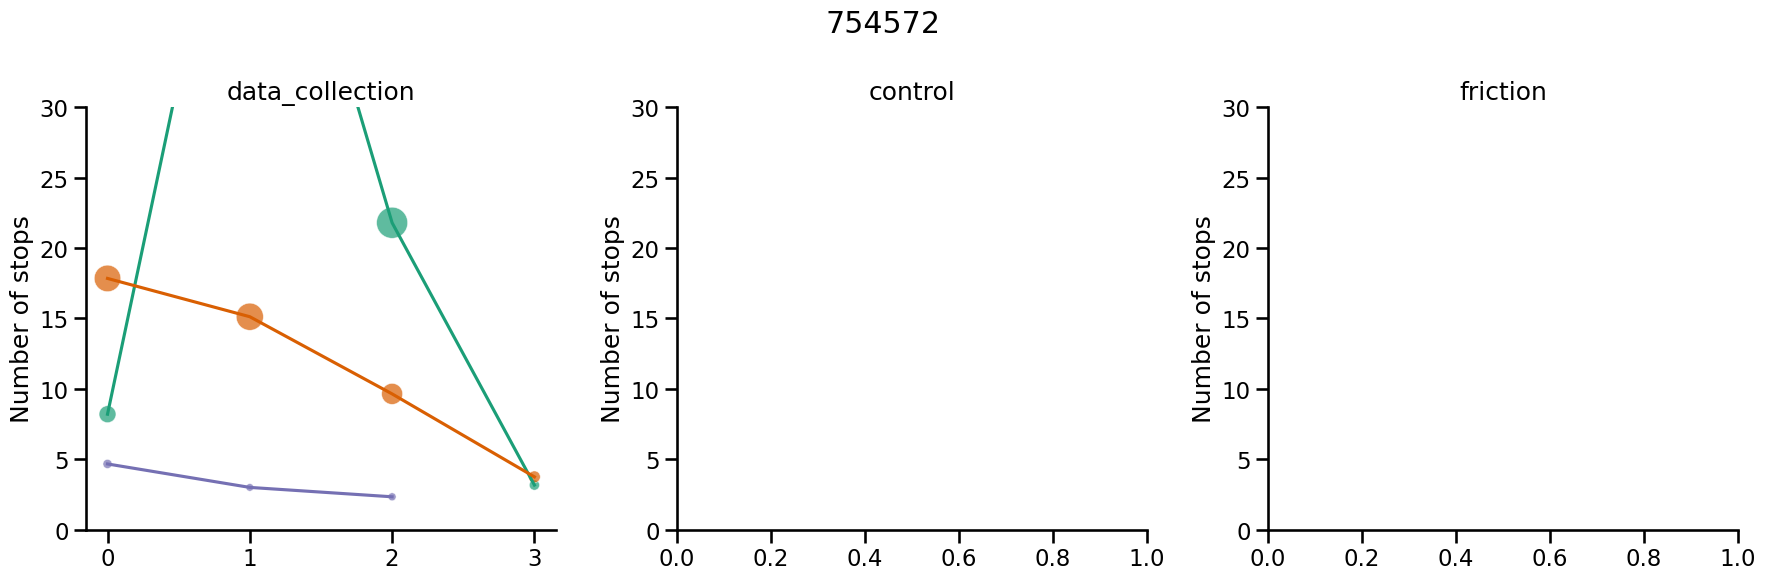

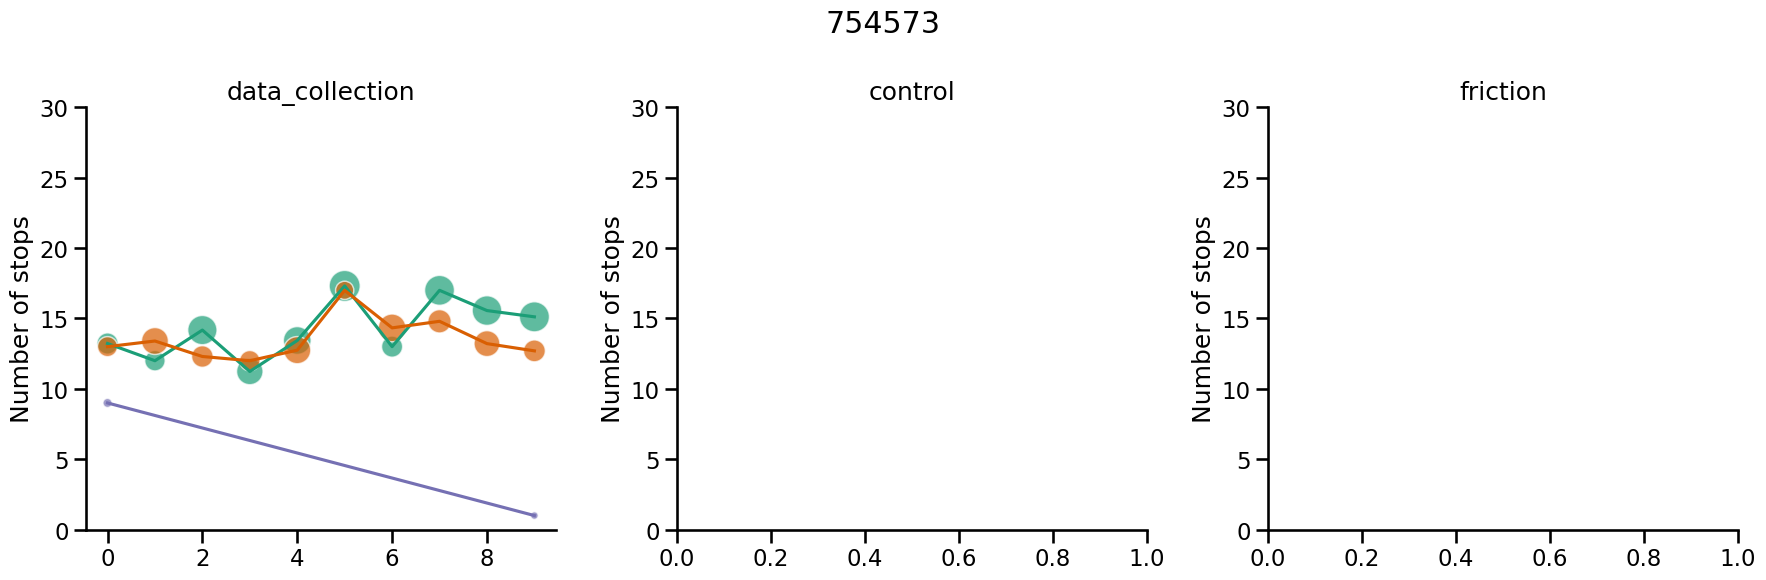

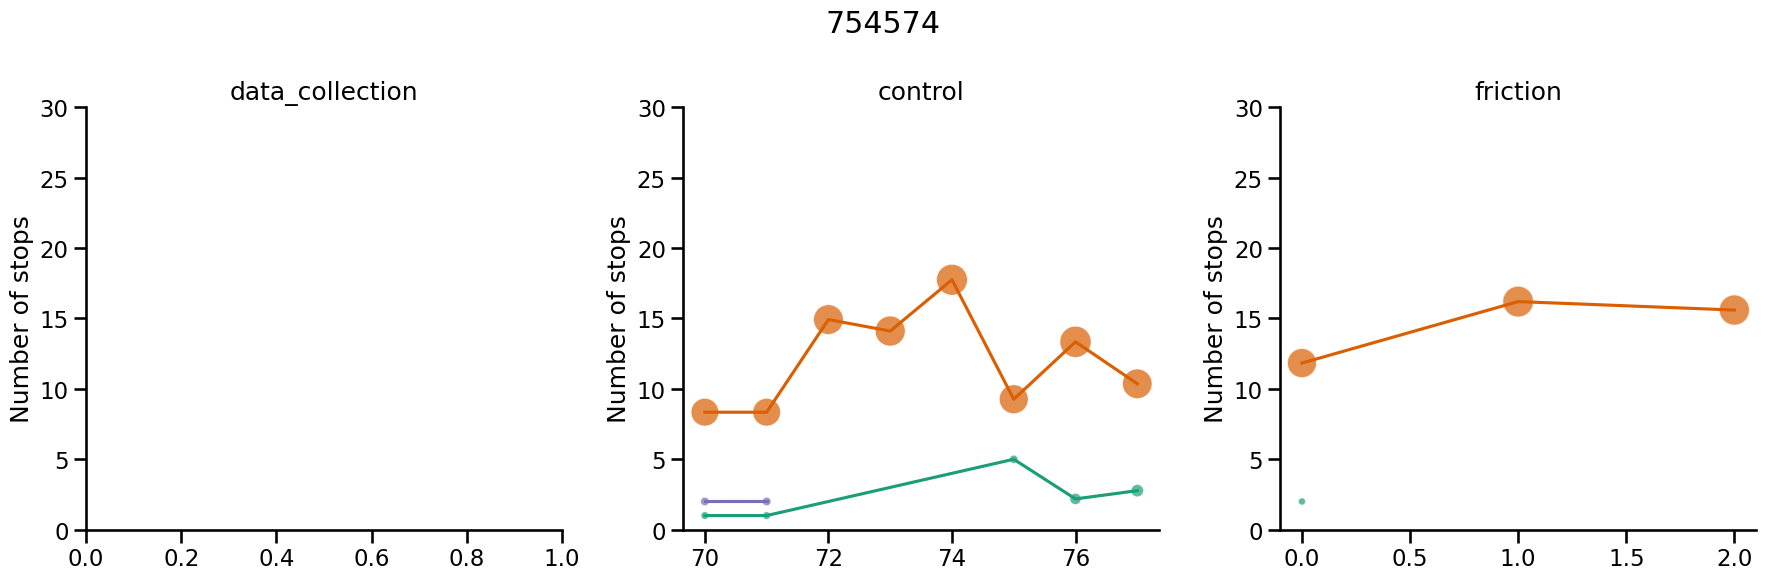

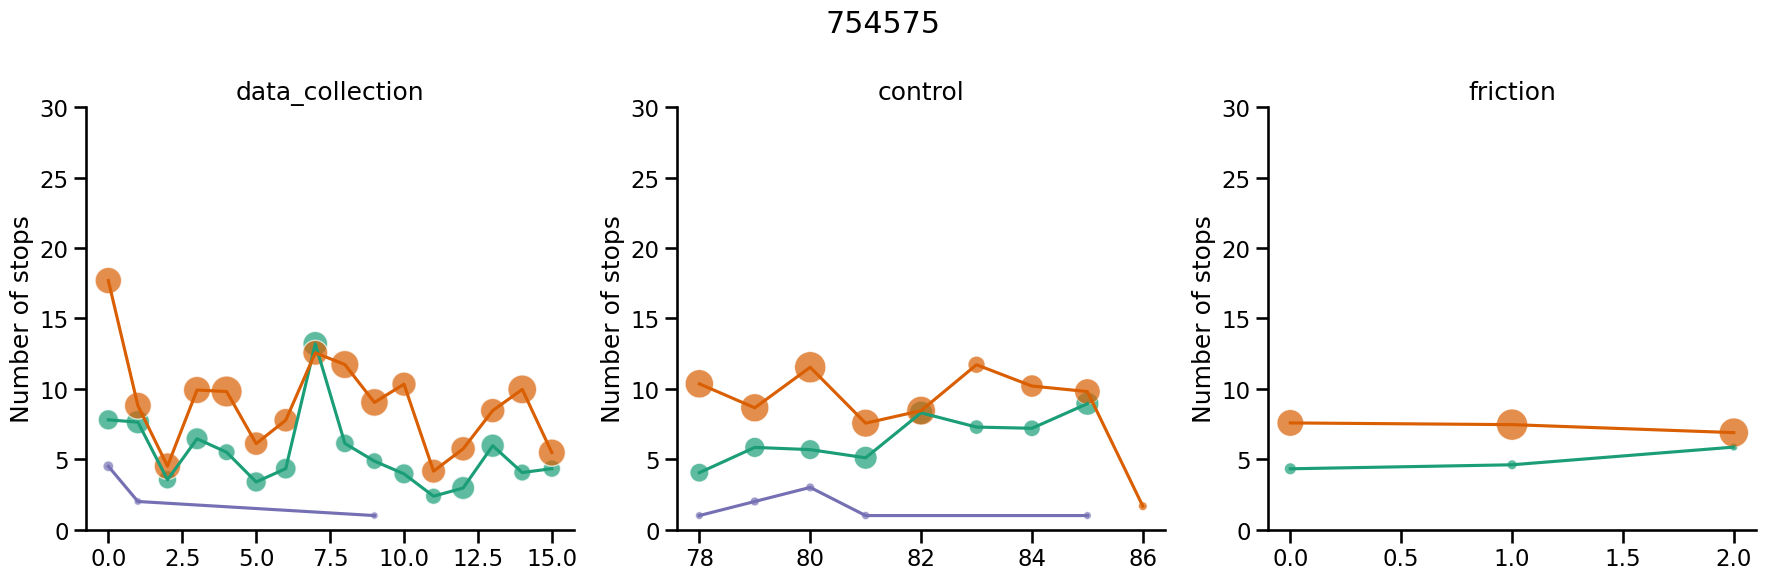

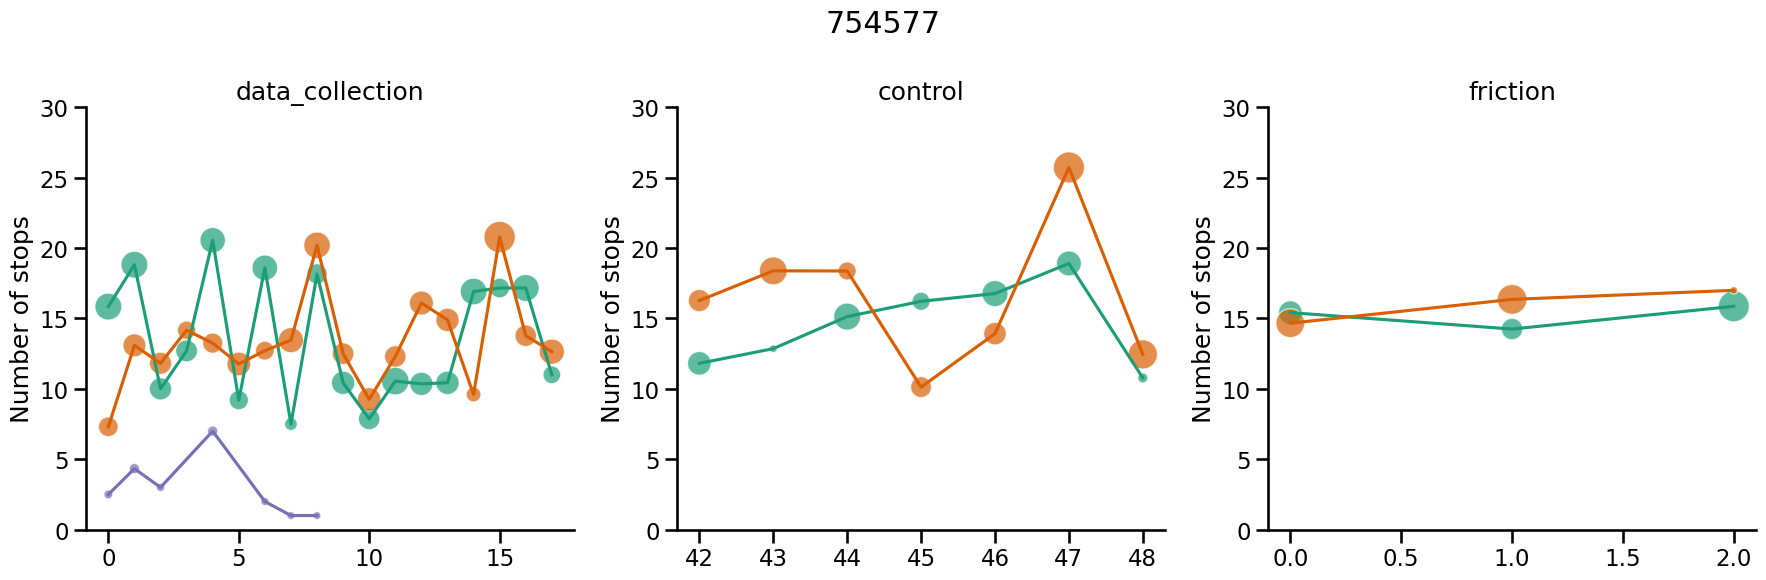

KeyboardInterrupt: 

In [28]:
summary = (
    summary_df.loc[summary_df.has_choice == True]
    .groupby(['within_session_number', 'mouse', 'odor_label', 'active_patch', 'experiment'])
    .agg(
        visit_number=('visit_number', 'count'),
        reward_probability=('reward_probability', 'mean'),
        stops=('visit_number', 'max')
    )
    .reset_index()
)
summary = summary.loc[(summary.visit_number > 1)]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean', 'stops':'mean'}).reset_index()
 
for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['data_collection', 'control', 'friction']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='stops', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

        sns.lineplot(x='within_session_number', y='stops', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='', ax=ax)

        plt.title(f'{experiment}')

        plt.xlabel('')
        plt.ylabel('Number of stops')
        plt.ylim(0,30)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()

# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

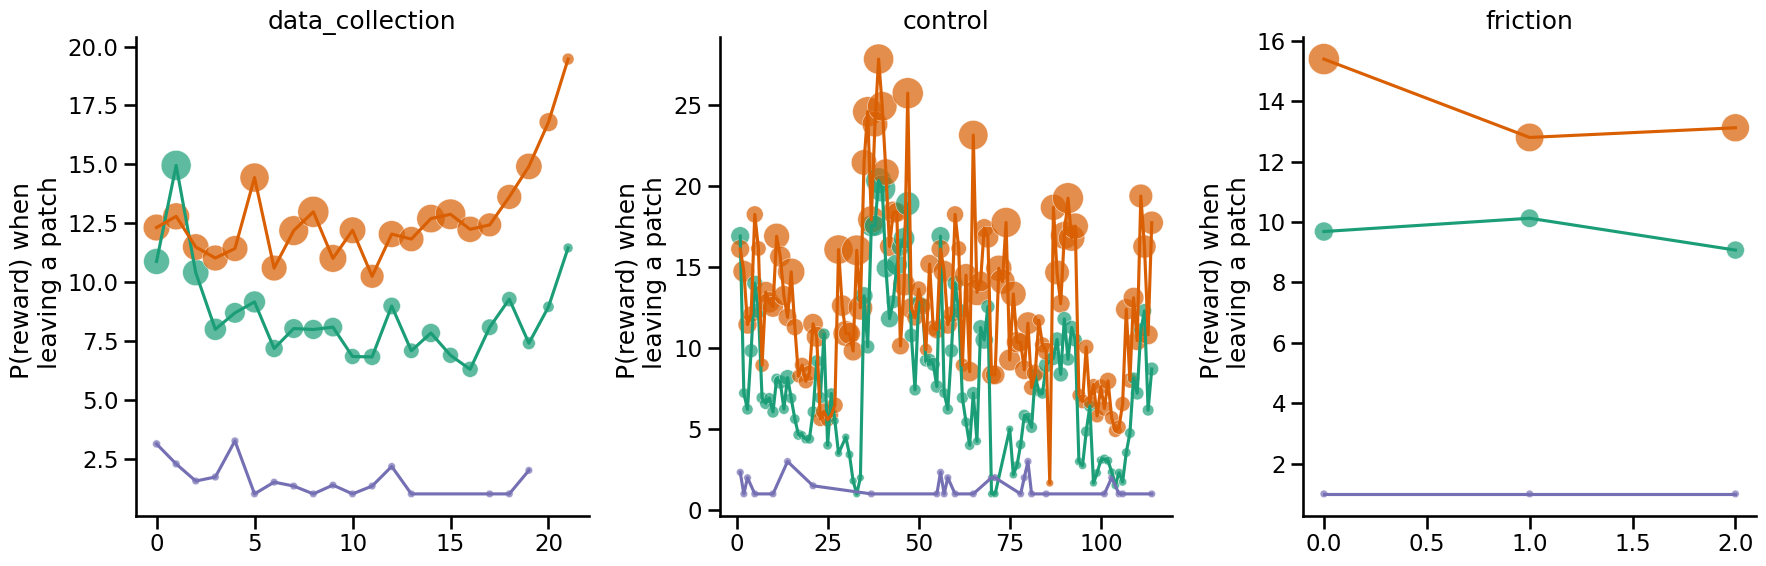

In [29]:
summary = (
    summary_df.loc[summary_df.has_choice == True]
    .groupby(['within_session_number', 'mouse', 'odor_label', 'active_patch', 'experiment'])
    .agg(
        visit_number=('visit_number', 'sum'),
        reward_probability=('reward_probability', 'mean'),
        stops=('visit_number', 'max')
    )
    .reset_index()
)
summary = summary.loc[(summary.visit_number > 0)]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean', 'stops':'mean'}).reset_index()
summary = summary.groupby(['within_session_number','odor_label','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean',
                                                                                    'stops':'mean'}).reset_index()

fig = plt.figure(figsize=(18,6))

# print(summary.loc[summary.mouse == mouse])
# print('\n')
for i, experiment in enumerate(['data_collection', 'control', 'friction']):
    ax = plt.subplot(1, 3, i + 1)
        
    sns.scatterplot(summary.loc[(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='stops', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

    sns.lineplot(x='within_session_number', y='stops', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)], marker='', ax=ax)

    plt.title(f'{experiment}')

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    sns.despine()
    
# plt.suptitle(f'{mouse}')
plt.tight_layout()
plt.show()

fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

### **Average of p(reward) within experiment**

#### **Across animals**

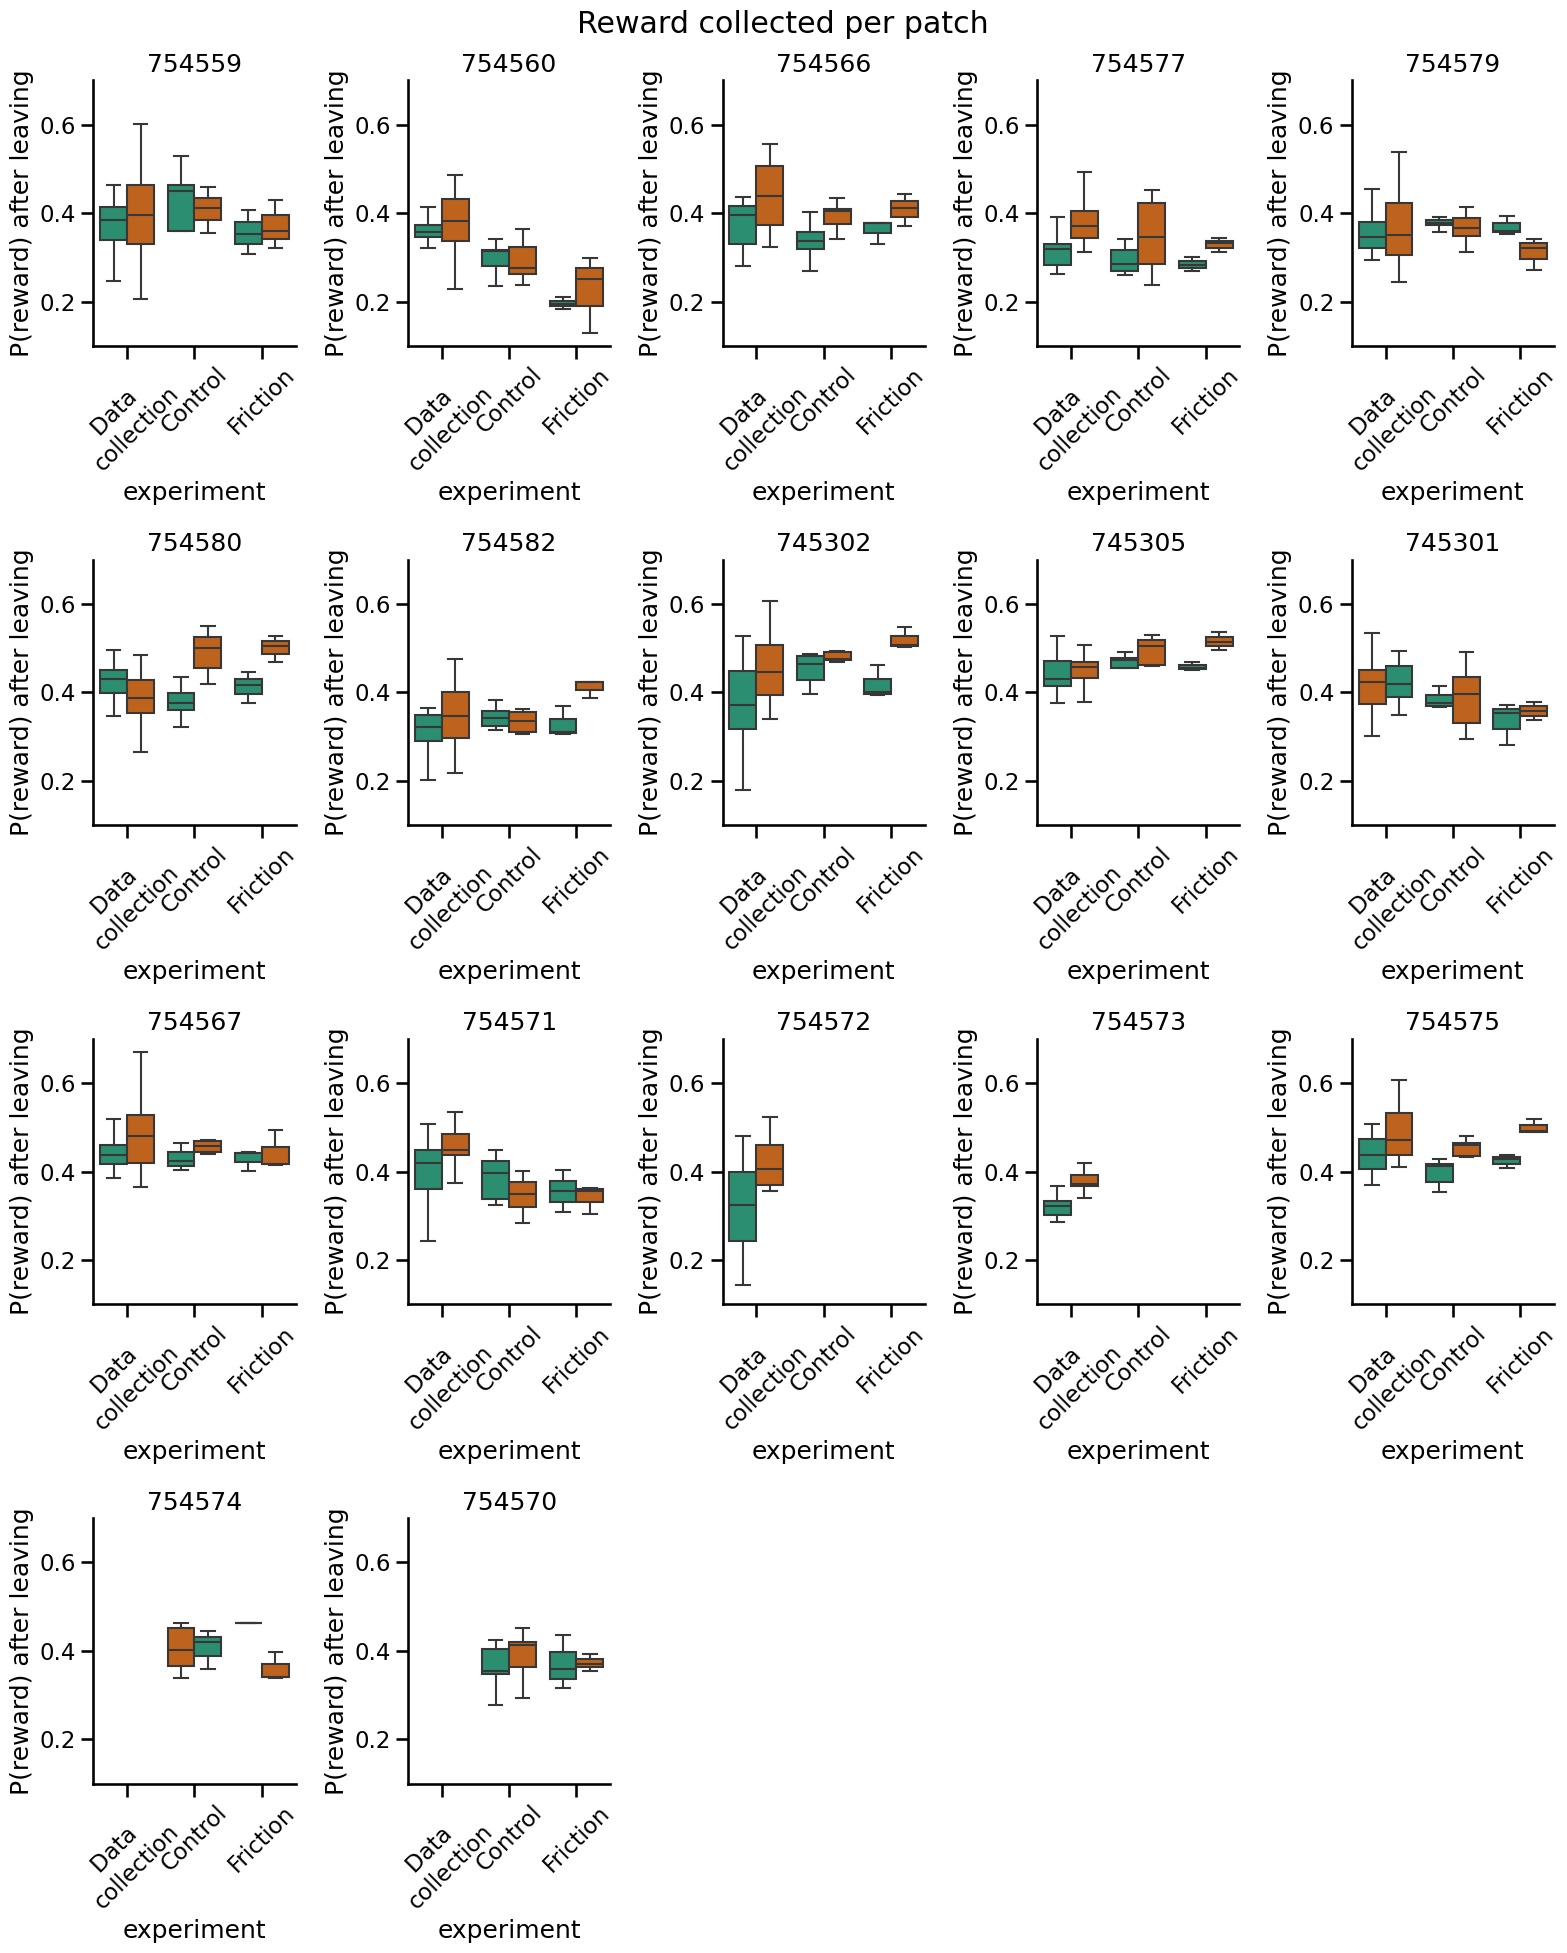

In [30]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 2)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 20))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 5, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['data_collection', 'control', 'friction']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_probability', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['data_collection', 'control', 'friction'])  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Data \ncollection', 'Control', 'Friction'], rotation = 45)
    plt.ylabel('P(reward) after leaving')
    plt.ylim(0.1, 0.7)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

#### Average of animals

In [ ]:
summary = (
    summary_df.loc[summary_df.has_choice == True]
    .groupby(['within_session_number', 'mouse', 'odor_label', 'active_patch', 'experiment'])
    .agg(
        visit_number=('visit_number', 'count'),
        reward_probability=('reward_probability', 'mean'),
        stops=('visit_number', 'max')
    )
    .reset_index()
)
summary = summary.loc[(summary.visit_number > 1)]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'reward_probability':'median', 'active_patch': 'nunique', 
                                                                               'stops' : 'mean'}).reset_index()
# summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 20))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 5, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['data_collection', 'control', 'friction']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='stops', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)], hue_order=['Methyl Butyrate', 'Alpha-pinene'],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['data_collection', 'control', 'friction'])  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Data \ncollection', 'Control', 'Friction'], rotation = 45)
    plt.ylabel('P(reward) after leaving')
    # plt.ylim(0.1, 0.7)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

## Experienced curves across experiments

**Average across experiments per mouse**

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        fig, ax = plt.subplots(1,3,figsize=(13, 5))
        i = 0
        # for odor in dict_odor.keys():
        for odor in summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)].odor_label.unique():

            odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
            odor_df = odor_df.loc[(odor_df.visit_number_count >= 3.0)]

            sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
            
            if odor_df.empty:
                i +=1
                continue
            
            # Plot exponential curve
            popt, pcov = curve_fit(exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

            ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
            ax[i].set_ylim(-0.1,1.1)
            ax[i].set_title(odor)
            ax[i].set_xlabel('Total rewarded stops in patch')
            ax[i].set_ylabel('Percent Rewarded')

            i +=1

        sns.despine()
        plt.suptitle(f'{mouse} {experiment}')
        plt.tight_layout()
        plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


**Average per mouse**

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    i=0
    extra = 0.0
    fig, ax = plt.subplots(1,3,figsize=(13, 5))
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        # for odor in dict_odor.keys():
        odor_df = summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
        odor_df = odor_df.loc[(odor_df.odor_label != 'Amyl Acetate')&(odor_df.odor_label != 'Fenchone')]
        odor_df = odor_df.loc[(odor_df.visit_number_count >= 5.0)]

        sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', hue='odor_label', palette=color_dict_label, ax=ax[i])
    
        # Plot exponential curve
        extra = 0
        for odor in odor_df.odor_label.unique():
            extra += 0.08
            popt, pcov = curve_fit(exponential_func, odor_df.loc[(odor_df['odor_label'] == odor)]['cumulative_rewards'],odor_df.loc[(odor_df['odor_label'] == odor)]['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color=dict_odor[odor]['color'], label='Exponential Fit', alpha=0.5)
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.8+extra, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color=dict_odor[odor]['color'], fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

        ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
        ax[i].set_ylim(-0.1,1.1)
        ax[i].set_title(experiment)
        ax[i].set_xlabel('Total rewarded stops in patch')
        ax[i].set_ylabel('Percent Rewarded')

        i +=1
        
    sns.despine()
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        
